In [1]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import data as dt
import model_4_o as md
import copy
from pytorch_ssim import ssim
from torch.utils.data import DataLoader
# e/d + i

In [2]:
# print gpu
torch.cuda.set_device(4)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

Current GPU: 4
8
(6, 1)
1.0.0


In [3]:
USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:4')
else:
    device = "cpu"
print(device)

cuda:4


In [ ]:
# generate csv file, run only for the first time
# dt.generate_csv()

In [4]:
csvFilePath = dt.get_csv_path()
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([                                              
                                               dt.Rescale(96),                                     
                                               dt.Normalize(),
                                               dt.ToTensor()
                                           ]))
# TODO: change the normalization parameters

In [43]:
# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

0 torch.Size([50, 3, 96, 96]) torch.Size([50, 96, 96])
1 torch.Size([50, 3, 96, 96]) torch.Size([50, 96, 96])
2 torch.Size([50, 3, 96, 96]) torch.Size([50, 96, 96])
3 torch.Size([50, 3, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


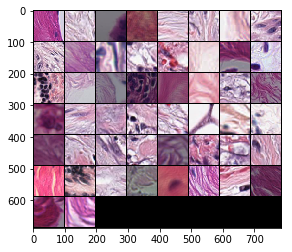

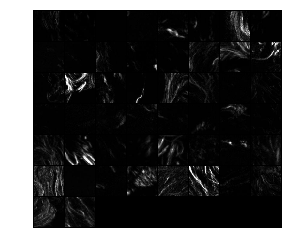

In [8]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 

In [12]:
print('===> Building model')
model = md.Net().to(device)
criterionMSE = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)


===> Building model


In [20]:
def train(epoch, p, windowsize):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
        lossMSE = criterionMSE(output, targetf)      
        lossSSIM = 1-ssim(output, targetf, window_size=windowsize)
        
        # 0.75->0.4 after 3 epochs
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossMSE: " + str(lossMSE.item()) +
                  " " + "lossSSIM: " + str(lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))


In [ ]:
# def test():
#     avg_psnr = 0
#     with torch.no_grad():
#         for batch in testing_data_loader:
#             input, target = batch[0].to(device), batch[1].to(device)

#             prediction = model(input)
#             mse = criterion(prediction, target)
#             psnr = 10 * log10(1 / mse.item())
#             avg_psnr += psnr
#     print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


In [ ]:
# def checkpoint(epoch):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(model, model_out_path)
#     print("Checkpoint saved to {}".format(model_out_path))

In [14]:
for epoch in range(1, 10 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)
#     wanna loss < 0.06

lossMSE: 0.2686838209629059 lossSSIM: 0.9838903546333313
===> Epoch[1](0/16220): Loss: 0.4475
lossMSE: 0.22525112330913544 lossSSIM: 0.949894368648529
===> Epoch[1](50/16220): Loss: 0.4064
lossMSE: 0.21995115280151367 lossSSIM: 0.9486340284347534
===> Epoch[1](100/16220): Loss: 0.4021
lossMSE: 0.2252698391675949 lossSSIM: 0.9594175219535828
===> Epoch[1](150/16220): Loss: 0.4088
lossMSE: 0.2261759340763092 lossSSIM: 0.9554271101951599
===> Epoch[1](200/16220): Loss: 0.4085
lossMSE: 0.21777519583702087 lossSSIM: 0.9472432136535645
===> Epoch[1](250/16220): Loss: 0.4001
lossMSE: 0.21536991000175476 lossSSIM: 0.9469929337501526
===> Epoch[1](300/16220): Loss: 0.3983
lossMSE: 0.22285518050193787 lossSSIM: 0.9540454149246216
===> Epoch[1](350/16220): Loss: 0.4057
lossMSE: 0.21912017464637756 lossSSIM: 0.952680230140686
===> Epoch[1](400/16220): Loss: 0.4025
lossMSE: 0.22066180408000946 lossSSIM: 0.9522578716278076
===> Epoch[1](450/16220): Loss: 0.4036
lossMSE: 0.21234016120433807 lossSSIM:

lossMSE: 0.14789099991321564 lossSSIM: 0.9462420344352722
===> Epoch[1](4250/16220): Loss: 0.3475
lossMSE: 0.14460603892803192 lossSSIM: 0.9419711828231812
===> Epoch[1](4300/16220): Loss: 0.3439
lossMSE: 0.14060118794441223 lossSSIM: 0.9273629784584045
===> Epoch[1](4350/16220): Loss: 0.3373
lossMSE: 0.1449260264635086 lossSSIM: 0.9407814741134644
===> Epoch[1](4400/16220): Loss: 0.3439
lossMSE: 0.13586470484733582 lossSSIM: 0.9343789219856262
===> Epoch[1](4450/16220): Loss: 0.3355
lossMSE: 0.13739699125289917 lossSSIM: 0.937985897064209
===> Epoch[1](4500/16220): Loss: 0.3375
lossMSE: 0.14211112260818481 lossSSIM: 0.9377210736274719
===> Epoch[1](4550/16220): Loss: 0.3410
lossMSE: 0.134311705827713 lossSSIM: 0.9265117049217224
===> Epoch[1](4600/16220): Loss: 0.3324
lossMSE: 0.1400250941514969 lossSSIM: 0.9410459995269775
===> Epoch[1](4650/16220): Loss: 0.3403
lossMSE: 0.13554014265537262 lossSSIM: 0.9326379895210266
===> Epoch[1](4700/16220): Loss: 0.3348
lossMSE: 0.13376313447952

lossMSE: 0.08612508326768875 lossSSIM: 0.9232851266860962
===> Epoch[1](8450/16220): Loss: 0.2954
lossMSE: 0.08555568009614944 lossSSIM: 0.9274564385414124
===> Epoch[1](8500/16220): Loss: 0.2960
lossMSE: 0.08552472293376923 lossSSIM: 0.9216060638427734
===> Epoch[1](8550/16220): Loss: 0.2945
lossMSE: 0.0838325247168541 lossSSIM: 0.9217653274536133
===> Epoch[1](8600/16220): Loss: 0.2933
lossMSE: 0.08586705476045609 lossSSIM: 0.9250525832176208
===> Epoch[1](8650/16220): Loss: 0.2957
lossMSE: 0.0837390199303627 lossSSIM: 0.9175140261650085
===> Epoch[1](8700/16220): Loss: 0.2922
lossMSE: 0.08354274183511734 lossSSIM: 0.9222016930580139
===> Epoch[1](8750/16220): Loss: 0.2932
lossMSE: 0.0842592865228653 lossSSIM: 0.931605875492096
===> Epoch[1](8800/16220): Loss: 0.2961
lossMSE: 0.08313747495412827 lossSSIM: 0.9263900518417358
===> Epoch[1](8850/16220): Loss: 0.2940
lossMSE: 0.08308154344558716 lossSSIM: 0.9226160049438477
===> Epoch[1](8900/16220): Loss: 0.2930
lossMSE: 0.0813042074441

lossMSE: 0.049952395260334015 lossSSIM: 0.906531810760498
===> Epoch[1](12650/16220): Loss: 0.2641
lossMSE: 0.049892064183950424 lossSSIM: 0.9167389273643494
===> Epoch[1](12700/16220): Loss: 0.2666
lossMSE: 0.049255166202783585 lossSSIM: 0.897293210029602
===> Epoch[1](12750/16220): Loss: 0.2613
lossMSE: 0.04797660931944847 lossSSIM: 0.9000298976898193
===> Epoch[1](12800/16220): Loss: 0.2610
lossMSE: 0.048358213156461716 lossSSIM: 0.9012803435325623
===> Epoch[1](12850/16220): Loss: 0.2616
lossMSE: 0.047223083674907684 lossSSIM: 0.8937867283821106
===> Epoch[1](12900/16220): Loss: 0.2589
lossMSE: 0.04766366630792618 lossSSIM: 0.9027027487754822
===> Epoch[1](12950/16220): Loss: 0.2614
lossMSE: 0.046674907207489014 lossSSIM: 0.8893958330154419
===> Epoch[1](13000/16220): Loss: 0.2574
lossMSE: 0.045912966132164 lossSSIM: 0.8926360011100769
===> Epoch[1](13050/16220): Loss: 0.2576
lossMSE: 0.04590074345469475 lossSSIM: 0.8954012989997864
===> Epoch[1](13100/16220): Loss: 0.2583
lossMSE:

lossMSE: 0.03244945406913757 lossSSIM: 0.8563909530639648
===> Epoch[2](550/16220): Loss: 0.2384
lossMSE: 0.02863314189016819 lossSSIM: 0.838603138923645
===> Epoch[2](600/16220): Loss: 0.2311
lossMSE: 0.03010275587439537 lossSSIM: 0.8595458269119263
===> Epoch[2](650/16220): Loss: 0.2375
lossMSE: 0.028056679293513298 lossSSIM: 0.8588104844093323
===> Epoch[2](700/16220): Loss: 0.2357
lossMSE: 0.029201852157711983 lossSSIM: 0.8627672791481018
===> Epoch[2](750/16220): Loss: 0.2376
lossMSE: 0.027453234419226646 lossSSIM: 0.8545235395431519
===> Epoch[2](800/16220): Loss: 0.2342
lossMSE: 0.027857424691319466 lossSSIM: 0.8530617952346802
===> Epoch[2](850/16220): Loss: 0.2342
lossMSE: 0.031360141932964325 lossSSIM: 0.8694453239440918
===> Epoch[2](900/16220): Loss: 0.2409
lossMSE: 0.02955540642142296 lossSSIM: 0.8436737060546875
===> Epoch[2](950/16220): Loss: 0.2331
lossMSE: 0.02830513007938862 lossSSIM: 0.8498611450195312
===> Epoch[2](1000/16220): Loss: 0.2337
lossMSE: 0.02983824349939

lossMSE: 0.01830742321908474 lossSSIM: 0.7891098260879517
===> Epoch[2](4750/16220): Loss: 0.2110
lossMSE: 0.018183570355176926 lossSSIM: 0.7842313051223755
===> Epoch[2](4800/16220): Loss: 0.2097
lossMSE: 0.01911487989127636 lossSSIM: 0.7867437601089478
===> Epoch[2](4850/16220): Loss: 0.2110
lossMSE: 0.02029820717871189 lossSSIM: 0.7658153176307678
===> Epoch[2](4900/16220): Loss: 0.2067
lossMSE: 0.018687404692173004 lossSSIM: 0.7738770246505737
===> Epoch[2](4950/16220): Loss: 0.2075
lossMSE: 0.019674386829137802 lossSSIM: 0.7711533904075623
===> Epoch[2](5000/16220): Loss: 0.2075
lossMSE: 0.021605154499411583 lossSSIM: 0.7761431336402893
===> Epoch[2](5050/16220): Loss: 0.2102
lossMSE: 0.020444335415959358 lossSSIM: 0.7697015404701233
===> Epoch[2](5100/16220): Loss: 0.2078
lossMSE: 0.017309654504060745 lossSSIM: 0.7853811979293823
===> Epoch[2](5150/16220): Loss: 0.2093
lossMSE: 0.018705226480960846 lossSSIM: 0.7630137205123901
===> Epoch[2](5200/16220): Loss: 0.2048
lossMSE: 0.01

lossMSE: 0.016585368663072586 lossSSIM: 0.6746360063552856
===> Epoch[2](8950/16220): Loss: 0.1811
lossMSE: 0.0162068922072649 lossSSIM: 0.648241400718689
===> Epoch[2](9000/16220): Loss: 0.1742
lossMSE: 0.014759431593120098 lossSSIM: 0.6578042507171631
===> Epoch[2](9050/16220): Loss: 0.1755
lossMSE: 0.017667613923549652 lossSSIM: 0.6602840423583984
===> Epoch[2](9100/16220): Loss: 0.1783
lossMSE: 0.014895685017108917 lossSSIM: 0.6490695476531982
===> Epoch[2](9150/16220): Loss: 0.1734
lossMSE: 0.01900082640349865 lossSSIM: 0.6618977189064026
===> Epoch[2](9200/16220): Loss: 0.1797
lossMSE: 0.01627255417406559 lossSSIM: 0.6821324825286865
===> Epoch[2](9250/16220): Loss: 0.1827
lossMSE: 0.015907134860754013 lossSSIM: 0.6548280119895935
===> Epoch[2](9300/16220): Loss: 0.1756
lossMSE: 0.01676258258521557 lossSSIM: 0.6837779879570007
===> Epoch[2](9350/16220): Loss: 0.1835
lossMSE: 0.016198527067899704 lossSSIM: 0.6555655598640442
===> Epoch[2](9400/16220): Loss: 0.1760
lossMSE: 0.01467

lossMSE: 0.016105346381664276 lossSSIM: 0.5484044551849365
===> Epoch[2](13100/16220): Loss: 0.1492
lossMSE: 0.012803493067622185 lossSSIM: 0.5185787677764893
===> Epoch[2](13150/16220): Loss: 0.1392
lossMSE: 0.015132931992411613 lossSSIM: 0.5249291658401489
===> Epoch[2](13200/16220): Loss: 0.1426
lossMSE: 0.015245012007653713 lossSSIM: 0.5288769006729126
===> Epoch[2](13250/16220): Loss: 0.1437
lossMSE: 0.013819761574268341 lossSSIM: 0.515565037727356
===> Epoch[2](13300/16220): Loss: 0.1393
lossMSE: 0.014023590832948685 lossSSIM: 0.5231536030769348
===> Epoch[2](13350/16220): Loss: 0.1413
lossMSE: 0.014634853228926659 lossSSIM: 0.5239889621734619
===> Epoch[2](13400/16220): Loss: 0.1420
lossMSE: 0.015520205721259117 lossSSIM: 0.5369994640350342
===> Epoch[2](13450/16220): Loss: 0.1459
lossMSE: 0.013201657682657242 lossSSIM: 0.4934147000312805
===> Epoch[2](13500/16220): Loss: 0.1333
lossMSE: 0.017148535698652267 lossSSIM: 0.5363218784332275
===> Epoch[2](13550/16220): Loss: 0.1469
l

lossMSE: 0.011050892993807793 lossSSIM: 0.42273473739624023
===> Epoch[3](950/16220): Loss: 0.1140
lossMSE: 0.009799147956073284 lossSSIM: 0.40806037187576294
===> Epoch[3](1000/16220): Loss: 0.1094
lossMSE: 0.011543958447873592 lossSSIM: 0.4445226788520813
===> Epoch[3](1050/16220): Loss: 0.1198
lossMSE: 0.011197250336408615 lossSSIM: 0.44053906202316284
===> Epoch[3](1100/16220): Loss: 0.1185
lossMSE: 0.0116771524772048 lossSSIM: 0.4365527033805847
===> Epoch[3](1150/16220): Loss: 0.1179
lossMSE: 0.011201292276382446 lossSSIM: 0.4629320502281189
===> Epoch[3](1200/16220): Loss: 0.1241
lossMSE: 0.010941836051642895 lossSSIM: 0.45124250650405884
===> Epoch[3](1250/16220): Loss: 0.1210
lossMSE: 0.010608457028865814 lossSSIM: 0.4135127067565918
===> Epoch[3](1300/16220): Loss: 0.1113
lossMSE: 0.013506540097296238 lossSSIM: 0.44614261388778687
===> Epoch[3](1350/16220): Loss: 0.1217
lossMSE: 0.009654281660914421 lossSSIM: 0.44617360830307007
===> Epoch[3](1400/16220): Loss: 0.1188
lossMSE

lossMSE: 0.010546102188527584 lossSSIM: 0.3825463056564331
===> Epoch[3](5100/16220): Loss: 0.1035
lossMSE: 0.009862527251243591 lossSSIM: 0.3687554597854614
===> Epoch[3](5150/16220): Loss: 0.0996
lossMSE: 0.009804933331906796 lossSSIM: 0.3593631386756897
===> Epoch[3](5200/16220): Loss: 0.0972
lossMSE: 0.008825687691569328 lossSSIM: 0.37466204166412354
===> Epoch[3](5250/16220): Loss: 0.1003
lossMSE: 0.009361856617033482 lossSSIM: 0.3507571816444397
===> Epoch[3](5300/16220): Loss: 0.0947
lossMSE: 0.010159638710319996 lossSSIM: 0.38950884342193604
===> Epoch[3](5350/16220): Loss: 0.1050
lossMSE: 0.008369050920009613 lossSSIM: 0.34608983993530273
===> Epoch[3](5400/16220): Loss: 0.0928
lossMSE: 0.008224484510719776 lossSSIM: 0.38282257318496704
===> Epoch[3](5450/16220): Loss: 0.1019
lossMSE: 0.00825442560017109 lossSSIM: 0.372825562953949
===> Epoch[3](5500/16220): Loss: 0.0994
lossMSE: 0.007809847593307495 lossSSIM: 0.36866050958633423
===> Epoch[3](5550/16220): Loss: 0.0980
lossMSE

lossMSE: 0.012884634546935558 lossSSIM: 0.31836944818496704
===> Epoch[3](9250/16220): Loss: 0.0893
lossMSE: 0.005116813350468874 lossSSIM: 0.3225257396697998
===> Epoch[3](9300/16220): Loss: 0.0845
lossMSE: 0.009636116214096546 lossSSIM: 0.32684969902038574
===> Epoch[3](9350/16220): Loss: 0.0889
lossMSE: 0.004891092423349619 lossSSIM: 0.2850959300994873
===> Epoch[3](9400/16220): Loss: 0.0749
lossMSE: 0.00661349156871438 lossSSIM: 0.3325737714767456
===> Epoch[3](9450/16220): Loss: 0.0881
lossMSE: 0.004500777460634708 lossSSIM: 0.27115434408187866
===> Epoch[3](9500/16220): Loss: 0.0712
lossMSE: 0.006059516686946154 lossSSIM: 0.2993534207344055
===> Epoch[3](9550/16220): Loss: 0.0794
lossMSE: 0.009423634968698025 lossSSIM: 0.3405945897102356
===> Epoch[3](9600/16220): Loss: 0.0922
lossMSE: 0.007837469689548016 lossSSIM: 0.30904000997543335
===> Epoch[3](9650/16220): Loss: 0.0831
lossMSE: 0.012616383843123913 lossSSIM: 0.31496119499206543
===> Epoch[3](9700/16220): Loss: 0.0882
lossMS

lossMSE: 0.006354490760713816 lossSSIM: 0.28513556718826294
===> Epoch[3](13350/16220): Loss: 0.0760
lossMSE: 0.009306889027357101 lossSSIM: 0.28692102432250977
===> Epoch[3](13400/16220): Loss: 0.0787
lossMSE: 0.008870860561728477 lossSSIM: 0.30629652738571167
===> Epoch[3](13450/16220): Loss: 0.0832
lossMSE: 0.006192012224346399 lossSSIM: 0.27663737535476685
===> Epoch[3](13500/16220): Loss: 0.0738
lossMSE: 0.008687647990882397 lossSSIM: 0.34900975227355957
===> Epoch[3](13550/16220): Loss: 0.0938
lossMSE: 0.004423017613589764 lossSSIM: 0.28769373893737793
===> Epoch[3](13600/16220): Loss: 0.0752
lossMSE: 0.005374932195991278 lossSSIM: 0.2854378819465637
===> Epoch[3](13650/16220): Loss: 0.0754
lossMSE: 0.007855545729398727 lossSSIM: 0.2972249984741211
===> Epoch[3](13700/16220): Loss: 0.0802
lossMSE: 0.004264888819307089 lossSSIM: 0.28561341762542725
===> Epoch[3](13750/16220): Loss: 0.0746
lossMSE: 0.005283136386424303 lossSSIM: 0.27300459146499634
===> Epoch[3](13800/16220): Loss:

lossMSE: 0.008952596224844456 lossSSIM: 0.2883381247520447
===> Epoch[4](1200/16220): Loss: 0.0788
lossMSE: 0.009370511397719383 lossSSIM: 0.2979791760444641
===> Epoch[4](1250/16220): Loss: 0.0815
lossMSE: 0.007904322817921638 lossSSIM: 0.3040010333061218
===> Epoch[4](1300/16220): Loss: 0.0819
lossMSE: 0.005046415142714977 lossSSIM: 0.26577848196029663
===> Epoch[4](1350/16220): Loss: 0.0702
lossMSE: 0.0074580213986337185 lossSSIM: 0.2668575644493103
===> Epoch[4](1400/16220): Loss: 0.0723
lossMSE: 0.006170579697936773 lossSSIM: 0.26743578910827637
===> Epoch[4](1450/16220): Loss: 0.0715
lossMSE: 0.00680097471922636 lossSSIM: 0.28369981050491333
===> Epoch[4](1500/16220): Loss: 0.0760
lossMSE: 0.0030040566343814135 lossSSIM: 0.2537934184074402
===> Epoch[4](1550/16220): Loss: 0.0657
lossMSE: 0.009736215695738792 lossSSIM: 0.30198192596435547
===> Epoch[4](1600/16220): Loss: 0.0828
lossMSE: 0.012205607257783413 lossSSIM: 0.28758835792541504
===> Epoch[4](1650/16220): Loss: 0.0811
loss

lossMSE: 0.004801003262400627 lossSSIM: 0.2517499327659607
===> Epoch[4](5350/16220): Loss: 0.0665
lossMSE: 0.010186408646404743 lossSSIM: 0.3361494541168213
===> Epoch[4](5400/16220): Loss: 0.0917
lossMSE: 0.0029756338335573673 lossSSIM: 0.22785162925720215
===> Epoch[4](5450/16220): Loss: 0.0592
lossMSE: 0.010353016667068005 lossSSIM: 0.3003593683242798
===> Epoch[4](5500/16220): Loss: 0.0829
lossMSE: 0.009727333672344685 lossSSIM: 0.2695850729942322
===> Epoch[4](5550/16220): Loss: 0.0747
lossMSE: 0.010219733230769634 lossSSIM: 0.27243560552597046
===> Epoch[4](5600/16220): Loss: 0.0758
lossMSE: 0.007242023479193449 lossSSIM: 0.2422025203704834
===> Epoch[4](5650/16220): Loss: 0.0660
lossMSE: 0.009950686246156693 lossSSIM: 0.29974764585494995
===> Epoch[4](5700/16220): Loss: 0.0824
lossMSE: 0.012887467630207539 lossSSIM: 0.35411691665649414
===> Epoch[4](5750/16220): Loss: 0.0982
lossMSE: 0.009096848778426647 lossSSIM: 0.30589789152145386
===> Epoch[4](5800/16220): Loss: 0.0833
loss

lossMSE: 0.011226331815123558 lossSSIM: 0.29269200563430786
===> Epoch[4](9500/16220): Loss: 0.0816
lossMSE: 0.004713943228125572 lossSSIM: 0.25712454319000244
===> Epoch[4](9550/16220): Loss: 0.0678
lossMSE: 0.006175341084599495 lossSSIM: 0.26261550188064575
===> Epoch[4](9600/16220): Loss: 0.0703
lossMSE: 0.007696064189076424 lossSSIM: 0.259394109249115
===> Epoch[4](9650/16220): Loss: 0.0706
lossMSE: 0.0070665511302649975 lossSSIM: 0.32186418771743774
===> Epoch[4](9700/16220): Loss: 0.0858
lossMSE: 0.005361731629818678 lossSSIM: 0.2625042200088501
===> Epoch[4](9750/16220): Loss: 0.0696
lossMSE: 0.004759658128023148 lossSSIM: 0.27142423391342163
===> Epoch[4](9800/16220): Loss: 0.0714
lossMSE: 0.0034676266368478537 lossSSIM: 0.26210832595825195
===> Epoch[4](9850/16220): Loss: 0.0681
lossMSE: 0.012786305509507656 lossSSIM: 0.3139532208442688
===> Epoch[4](9900/16220): Loss: 0.0881
lossMSE: 0.003960392437875271 lossSSIM: 0.2562878727912903
===> Epoch[4](9950/16220): Loss: 0.0670
los

lossMSE: 0.006480597425252199 lossSSIM: 0.2762451171875
===> Epoch[4](13600/16220): Loss: 0.0739
lossMSE: 0.006225192919373512 lossSSIM: 0.2938159108161926
===> Epoch[4](13650/16220): Loss: 0.0781
lossMSE: 0.008763173595070839 lossSSIM: 0.2880653142929077
===> Epoch[4](13700/16220): Loss: 0.0786
lossMSE: 0.012760037556290627 lossSSIM: 0.3244238495826721
===> Epoch[4](13750/16220): Loss: 0.0907
lossMSE: 0.010452721267938614 lossSSIM: 0.32155901193618774
===> Epoch[4](13800/16220): Loss: 0.0882
lossMSE: 0.0071429964154958725 lossSSIM: 0.315826952457428
===> Epoch[4](13850/16220): Loss: 0.0843
lossMSE: 0.004668735433369875 lossSSIM: 0.2678552269935608
===> Epoch[4](13900/16220): Loss: 0.0705
lossMSE: 0.01636204496026039 lossSSIM: 0.25271719694137573
===> Epoch[4](13950/16220): Loss: 0.0755
lossMSE: 0.005139002576470375 lossSSIM: 0.2500873804092407
===> Epoch[4](14000/16220): Loss: 0.0664
lossMSE: 0.007361305877566338 lossSSIM: 0.3147127032279968
===> Epoch[4](14050/16220): Loss: 0.0842
lo

lossMSE: 0.0123574985191226 lossSSIM: 0.3158055543899536
===> Epoch[5](1450/16220): Loss: 0.0882
lossMSE: 0.003325666766613722 lossSSIM: 0.25202369689941406
===> Epoch[5](1500/16220): Loss: 0.0655
lossMSE: 0.010005076415836811 lossSSIM: 0.31132733821868896
===> Epoch[5](1550/16220): Loss: 0.0853
lossMSE: 0.011860121972858906 lossSSIM: 0.29237377643585205
===> Epoch[5](1600/16220): Loss: 0.0820
lossMSE: 0.006270781625062227 lossSSIM: 0.23055541515350342
===> Epoch[5](1650/16220): Loss: 0.0623
lossMSE: 0.004596426617354155 lossSSIM: 0.26218241453170776
===> Epoch[5](1700/16220): Loss: 0.0690
lossMSE: 0.006140777841210365 lossSSIM: 0.2838762402534485
===> Epoch[5](1750/16220): Loss: 0.0756
lossMSE: 0.00481332978233695 lossSSIM: 0.2720879316329956
===> Epoch[5](1800/16220): Loss: 0.0716
lossMSE: 0.012853126972913742 lossSSIM: 0.3307635188102722
===> Epoch[5](1850/16220): Loss: 0.0923
lossMSE: 0.0034341197460889816 lossSSIM: 0.2535156011581421
===> Epoch[5](1900/16220): Loss: 0.0660
lossMSE

lossMSE: 0.006712513975799084 lossSSIM: 0.26386111974716187
===> Epoch[5](5600/16220): Loss: 0.0710
lossMSE: 0.004611757583916187 lossSSIM: 0.2812121510505676
===> Epoch[5](5650/16220): Loss: 0.0738
lossMSE: 0.006068101618438959 lossSSIM: 0.2854938507080078
===> Epoch[5](5700/16220): Loss: 0.0759
lossMSE: 0.007391678169369698 lossSSIM: 0.30000627040863037
===> Epoch[5](5750/16220): Loss: 0.0805
lossMSE: 0.003996878396719694 lossSSIM: 0.23820000886917114
===> Epoch[5](5800/16220): Loss: 0.0625
lossMSE: 0.0078026410192251205 lossSSIM: 0.23709064722061157
===> Epoch[5](5850/16220): Loss: 0.0651
lossMSE: 0.005513911135494709 lossSSIM: 0.2732089161872864
===> Epoch[5](5900/16220): Loss: 0.0724
lossMSE: 0.0036319789942353964 lossSSIM: 0.2527279853820801
===> Epoch[5](5950/16220): Loss: 0.0659
lossMSE: 0.010404485277831554 lossSSIM: 0.29182612895965576
===> Epoch[5](6000/16220): Loss: 0.0808
lossMSE: 0.010230295360088348 lossSSIM: 0.3036363124847412
===> Epoch[5](6050/16220): Loss: 0.0836
los

lossMSE: 0.006257436703890562 lossSSIM: 0.3196924924850464
===> Epoch[5](9750/16220): Loss: 0.0846
lossMSE: 0.004153633024543524 lossSSIM: 0.2542427182197571
===> Epoch[5](9800/16220): Loss: 0.0667
lossMSE: 0.004130172543227673 lossSSIM: 0.2507505416870117
===> Epoch[5](9850/16220): Loss: 0.0658
lossMSE: 0.0062225027941167355 lossSSIM: 0.244756281375885
===> Epoch[5](9900/16220): Loss: 0.0659
lossMSE: 0.008630318567156792 lossSSIM: 0.2546239495277405
===> Epoch[5](9950/16220): Loss: 0.0701
lossMSE: 0.004450710024684668 lossSSIM: 0.2616892457008362
===> Epoch[5](10000/16220): Loss: 0.0688
lossMSE: 0.005006812512874603 lossSSIM: 0.27385324239730835
===> Epoch[5](10050/16220): Loss: 0.0722
lossMSE: 0.007244155742228031 lossSSIM: 0.3006554841995239
===> Epoch[5](10100/16220): Loss: 0.0806
lossMSE: 0.0036766964476555586 lossSSIM: 0.25058966875076294
===> Epoch[5](10150/16220): Loss: 0.0654
lossMSE: 0.004062863066792488 lossSSIM: 0.249394953250885
===> Epoch[5](10200/16220): Loss: 0.0654
los

lossMSE: 0.003866547020152211 lossSSIM: 0.25835973024368286
===> Epoch[5](13850/16220): Loss: 0.0675
lossMSE: 0.003215593984350562 lossSSIM: 0.21222519874572754
===> Epoch[5](13900/16220): Loss: 0.0555
lossMSE: 0.00663388567045331 lossSSIM: 0.28742867708206177
===> Epoch[5](13950/16220): Loss: 0.0768
lossMSE: 0.005068541970103979 lossSSIM: 0.25275856256484985
===> Epoch[5](14000/16220): Loss: 0.0670
lossMSE: 0.007456927094608545 lossSSIM: 0.23573696613311768
===> Epoch[5](14050/16220): Loss: 0.0645
lossMSE: 0.006298830732703209 lossSSIM: 0.27232152223587036
===> Epoch[5](14100/16220): Loss: 0.0728
lossMSE: 0.00873466208577156 lossSSIM: 0.2462267279624939
===> Epoch[5](14150/16220): Loss: 0.0681
lossMSE: 0.0046571362763643265 lossSSIM: 0.2927778363227844
===> Epoch[5](14200/16220): Loss: 0.0767
lossMSE: 0.0051290434785187244 lossSSIM: 0.2514244318008423
===> Epoch[5](14250/16220): Loss: 0.0667
lossMSE: 0.010213780216872692 lossSSIM: 0.30477583408355713
===> Epoch[5](14300/16220): Loss: 

lossMSE: 0.009894877672195435 lossSSIM: 0.3121708631515503
===> Epoch[6](1700/16220): Loss: 0.0855
lossMSE: 0.005779906176030636 lossSSIM: 0.2583770751953125
===> Epoch[6](1750/16220): Loss: 0.0689
lossMSE: 0.007739917375147343 lossSSIM: 0.2519170045852661
===> Epoch[6](1800/16220): Loss: 0.0688
lossMSE: 0.0054600355215370655 lossSSIM: 0.19213932752609253
===> Epoch[6](1850/16220): Loss: 0.0521
lossMSE: 0.00808471255004406 lossSSIM: 0.2662787437438965
===> Epoch[6](1900/16220): Loss: 0.0726
lossMSE: 0.007075801026076078 lossSSIM: 0.26307713985443115
===> Epoch[6](1950/16220): Loss: 0.0711
lossMSE: 0.009599128738045692 lossSSIM: 0.26323384046554565
===> Epoch[6](2000/16220): Loss: 0.0730
lossMSE: 0.0056618256494402885 lossSSIM: 0.2628355026245117
===> Epoch[6](2050/16220): Loss: 0.0700
lossMSE: 0.004528948105871677 lossSSIM: 0.2526644468307495
===> Epoch[6](2100/16220): Loss: 0.0666
lossMSE: 0.004375207703560591 lossSSIM: 0.2812303900718689
===> Epoch[6](2150/16220): Loss: 0.0736
lossMS

lossMSE: 0.005531213711947203 lossSSIM: 0.30379819869995117
===> Epoch[6](5850/16220): Loss: 0.0801
lossMSE: 0.007268623448908329 lossSSIM: 0.2709234356880188
===> Epoch[6](5900/16220): Loss: 0.0732
lossMSE: 0.005079884547740221 lossSSIM: 0.3089505434036255
===> Epoch[6](5950/16220): Loss: 0.0810
lossMSE: 0.008034857921302319 lossSSIM: 0.2975320816040039
===> Epoch[6](6000/16220): Loss: 0.0804
lossMSE: 0.01017681136727333 lossSSIM: 0.2621156573295593
===> Epoch[6](6050/16220): Loss: 0.0732
lossMSE: 0.007293187081813812 lossSSIM: 0.30379974842071533
===> Epoch[6](6100/16220): Loss: 0.0814
lossMSE: 0.010142013430595398 lossSSIM: 0.3005324602127075
===> Epoch[6](6150/16220): Loss: 0.0827
lossMSE: 0.006964992731809616 lossSSIM: 0.27467042207717896
===> Epoch[6](6200/16220): Loss: 0.0739
lossMSE: 0.004746320191770792 lossSSIM: 0.2666175961494446
===> Epoch[6](6250/16220): Loss: 0.0702
lossMSE: 0.008239210583269596 lossSSIM: 0.28269535303115845
===> Epoch[6](6300/16220): Loss: 0.0769
lossMSE

lossMSE: 0.006776647176593542 lossSSIM: 0.3268194794654846
===> Epoch[6](10000/16220): Loss: 0.0868
lossMSE: 0.005708180833607912 lossSSIM: 0.24549657106399536
===> Epoch[6](10050/16220): Loss: 0.0657
lossMSE: 0.006030144169926643 lossSSIM: 0.2600160241127014
===> Epoch[6](10100/16220): Loss: 0.0695
lossMSE: 0.003221797524020076 lossSSIM: 0.22996342182159424
===> Epoch[6](10150/16220): Loss: 0.0599
lossMSE: 0.004815618507564068 lossSSIM: 0.24988162517547607
===> Epoch[6](10200/16220): Loss: 0.0661
lossMSE: 0.006871200166642666 lossSSIM: 0.26708751916885376
===> Epoch[6](10250/16220): Loss: 0.0719
lossMSE: 0.010035715997219086 lossSSIM: 0.30351752042770386
===> Epoch[6](10300/16220): Loss: 0.0834
lossMSE: 0.008368336595594883 lossSSIM: 0.2900739908218384
===> Epoch[6](10350/16220): Loss: 0.0788
lossMSE: 0.01477421447634697 lossSSIM: 0.3003876805305481
===> Epoch[6](10400/16220): Loss: 0.0862
lossMSE: 0.0034275732468813658 lossSSIM: 0.2411332130432129
===> Epoch[6](10450/16220): Loss: 0.

lossMSE: 0.01039261743426323 lossSSIM: 0.3087236285209656
===> Epoch[6](14100/16220): Loss: 0.0850
lossMSE: 0.004507785197347403 lossSSIM: 0.2951051592826843
===> Epoch[6](14150/16220): Loss: 0.0772
lossMSE: 0.004495745059102774 lossSSIM: 0.2531968355178833
===> Epoch[6](14200/16220): Loss: 0.0667
lossMSE: 0.011090965941548347 lossSSIM: 0.27914267778396606
===> Epoch[6](14250/16220): Loss: 0.0781
lossMSE: 0.004267653916031122 lossSSIM: 0.24765151739120483
===> Epoch[6](14300/16220): Loss: 0.0651
lossMSE: 0.01164035964757204 lossSSIM: 0.3112282156944275
===> Epoch[6](14350/16220): Loss: 0.0865
lossMSE: 0.011768332682549953 lossSSIM: 0.2910385727882385
===> Epoch[6](14400/16220): Loss: 0.0816
lossMSE: 0.005050569772720337 lossSSIM: 0.26277124881744385
===> Epoch[6](14450/16220): Loss: 0.0695
lossMSE: 0.010129066184163094 lossSSIM: 0.30716854333877563
===> Epoch[6](14500/16220): Loss: 0.0844
lossMSE: 0.008284388110041618 lossSSIM: 0.29931843280792236
===> Epoch[6](14550/16220): Loss: 0.08

lossMSE: 0.012814505957067013 lossSSIM: 0.316982626914978
===> Epoch[7](1950/16220): Loss: 0.0889
lossMSE: 0.0069290269166231155 lossSSIM: 0.2772926092147827
===> Epoch[7](2000/16220): Loss: 0.0745
lossMSE: 0.003966548014432192 lossSSIM: 0.27604997158050537
===> Epoch[7](2050/16220): Loss: 0.0720
lossMSE: 0.005573554430156946 lossSSIM: 0.27126258611679077
===> Epoch[7](2100/16220): Loss: 0.0720
lossMSE: 0.003704808885231614 lossSSIM: 0.2566004991531372
===> Epoch[7](2150/16220): Loss: 0.0669
lossMSE: 0.013348057866096497 lossSSIM: 0.34172534942626953
===> Epoch[7](2200/16220): Loss: 0.0954
lossMSE: 0.00431131012737751 lossSSIM: 0.24907881021499634
===> Epoch[7](2250/16220): Loss: 0.0655
lossMSE: 0.013562655076384544 lossSSIM: 0.2948721647262573
===> Epoch[7](2300/16220): Loss: 0.0839
lossMSE: 0.0082935132086277 lossSSIM: 0.27774524688720703
===> Epoch[7](2350/16220): Loss: 0.0757
lossMSE: 0.0060516782104969025 lossSSIM: 0.2867496609687805
===> Epoch[7](2400/16220): Loss: 0.0762
lossMSE

lossMSE: 0.0034580968786031008 lossSSIM: 0.2422316074371338
===> Epoch[7](6100/16220): Loss: 0.0632
lossMSE: 0.00470123253762722 lossSSIM: 0.2717583179473877
===> Epoch[7](6150/16220): Loss: 0.0715
lossMSE: 0.006826539523899555 lossSSIM: 0.24848061800003052
===> Epoch[7](6200/16220): Loss: 0.0672
lossMSE: 0.010745931416749954 lossSSIM: 0.31208813190460205
===> Epoch[7](6250/16220): Loss: 0.0861
lossMSE: 0.005843982566148043 lossSSIM: 0.299874484539032
===> Epoch[7](6300/16220): Loss: 0.0794
lossMSE: 0.0050729429349303246 lossSSIM: 0.2734285593032837
===> Epoch[7](6350/16220): Loss: 0.0722
lossMSE: 0.009021646343171597 lossSSIM: 0.2652643322944641
===> Epoch[7](6400/16220): Loss: 0.0731
lossMSE: 0.004639436956495047 lossSSIM: 0.21628481149673462
===> Epoch[7](6450/16220): Loss: 0.0576
lossMSE: 0.0065612830221652985 lossSSIM: 0.30352264642715454
===> Epoch[7](6500/16220): Loss: 0.0808
lossMSE: 0.008069037459790707 lossSSIM: 0.25450819730758667
===> Epoch[7](6550/16220): Loss: 0.0697
loss

lossMSE: 0.0026317269075661898 lossSSIM: 0.21512973308563232
===> Epoch[7](10250/16220): Loss: 0.0558
lossMSE: 0.006521743722259998 lossSSIM: 0.26471394300460815
===> Epoch[7](10300/16220): Loss: 0.0711
lossMSE: 0.002448317827656865 lossSSIM: 0.2032206654548645
===> Epoch[7](10350/16220): Loss: 0.0526
lossMSE: 0.008147214539349079 lossSSIM: 0.24743467569351196
===> Epoch[7](10400/16220): Loss: 0.0680
lossMSE: 0.008417043834924698 lossSSIM: 0.2749779224395752
===> Epoch[7](10450/16220): Loss: 0.0751
lossMSE: 0.007094269152730703 lossSSIM: 0.2664727568626404
===> Epoch[7](10500/16220): Loss: 0.0719
lossMSE: 0.00929015502333641 lossSSIM: 0.27827590703964233
===> Epoch[7](10550/16220): Loss: 0.0765
lossMSE: 0.004405199084430933 lossSSIM: 0.2604096531867981
===> Epoch[7](10600/16220): Loss: 0.0684
lossMSE: 0.011460511945188046 lossSSIM: 0.27405792474746704
===> Epoch[7](10650/16220): Loss: 0.0771
lossMSE: 0.01781674101948738 lossSSIM: 0.3509133458137512
===> Epoch[7](10700/16220): Loss: 0.1

lossMSE: 0.008041555993258953 lossSSIM: 0.2693937420845032
===> Epoch[7](14350/16220): Loss: 0.0734
lossMSE: 0.011314714327454567 lossSSIM: 0.27772247791290283
===> Epoch[7](14400/16220): Loss: 0.0779
lossMSE: 0.009301084093749523 lossSSIM: 0.2857242822647095
===> Epoch[7](14450/16220): Loss: 0.0784
lossMSE: 0.005068222060799599 lossSSIM: 0.2628050446510315
===> Epoch[7](14500/16220): Loss: 0.0695
lossMSE: 0.005790187511593103 lossSSIM: 0.27544957399368286
===> Epoch[7](14550/16220): Loss: 0.0732
lossMSE: 0.005711524747312069 lossSSIM: 0.25580769777297974
===> Epoch[7](14600/16220): Loss: 0.0682
lossMSE: 0.008959409780800343 lossSSIM: 0.2759815454483032
===> Epoch[7](14650/16220): Loss: 0.0757
lossMSE: 0.010087799280881882 lossSSIM: 0.31734925508499146
===> Epoch[7](14700/16220): Loss: 0.0869
lossMSE: 0.012919402681291103 lossSSIM: 0.3544163107872009
===> Epoch[7](14750/16220): Loss: 0.0983
lossMSE: 0.005572526715695858 lossSSIM: 0.28194427490234375
===> Epoch[7](14800/16220): Loss: 0.

lossMSE: 0.005819754209369421 lossSSIM: 0.2847592234611511
===> Epoch[8](2200/16220): Loss: 0.0756
lossMSE: 0.00944232102483511 lossSSIM: 0.28451812267303467
===> Epoch[8](2250/16220): Loss: 0.0782
lossMSE: 0.010743536055088043 lossSSIM: 0.302196204662323
===> Epoch[8](2300/16220): Loss: 0.0836
lossMSE: 0.00472618592903018 lossSSIM: 0.29525548219680786
===> Epoch[8](2350/16220): Loss: 0.0774
lossMSE: 0.006917148362845182 lossSSIM: 0.2746570110321045
===> Epoch[8](2400/16220): Loss: 0.0739
lossMSE: 0.011552168987691402 lossSSIM: 0.27565062046051025
===> Epoch[8](2450/16220): Loss: 0.0776
lossMSE: 0.004698710981756449 lossSSIM: 0.2644311189651489
===> Epoch[8](2500/16220): Loss: 0.0696
lossMSE: 0.00395385455340147 lossSSIM: 0.2580748200416565
===> Epoch[8](2550/16220): Loss: 0.0675
lossMSE: 0.00454504881054163 lossSSIM: 0.2544625401496887
===> Epoch[8](2600/16220): Loss: 0.0670
lossMSE: 0.00745669798925519 lossSSIM: 0.28249114751815796
===> Epoch[8](2650/16220): Loss: 0.0762
lossMSE: 0.0

lossMSE: 0.003223968669772148 lossSSIM: 0.226906418800354
===> Epoch[8](6350/16220): Loss: 0.0591
lossMSE: 0.004187850281596184 lossSSIM: 0.2430332899093628
===> Epoch[8](6400/16220): Loss: 0.0639
lossMSE: 0.009899318218231201 lossSSIM: 0.3025374412536621
===> Epoch[8](6450/16220): Loss: 0.0831
lossMSE: 0.005402959417551756 lossSSIM: 0.26644182205200195
===> Epoch[8](6500/16220): Loss: 0.0707
lossMSE: 0.006015405058860779 lossSSIM: 0.24323517084121704
===> Epoch[8](6550/16220): Loss: 0.0653
lossMSE: 0.007382832467556 lossSSIM: 0.2924608588218689
===> Epoch[8](6600/16220): Loss: 0.0787
lossMSE: 0.006160993594676256 lossSSIM: 0.25795191526412964
===> Epoch[8](6650/16220): Loss: 0.0691
lossMSE: 0.015256527811288834 lossSSIM: 0.30353790521621704
===> Epoch[8](6700/16220): Loss: 0.0873
lossMSE: 0.005359559785574675 lossSSIM: 0.24235564470291138
===> Epoch[8](6750/16220): Loss: 0.0646
lossMSE: 0.007740669418126345 lossSSIM: 0.27973711490631104
===> Epoch[8](6800/16220): Loss: 0.0757
lossMSE:

lossMSE: 0.005756733473390341 lossSSIM: 0.26414406299591064
===> Epoch[8](10500/16220): Loss: 0.0704
lossMSE: 0.010225081816315651 lossSSIM: 0.30774009227752686
===> Epoch[8](10550/16220): Loss: 0.0846
lossMSE: 0.005796458572149277 lossSSIM: 0.29324036836624146
===> Epoch[8](10600/16220): Loss: 0.0777
lossMSE: 0.010850639082491398 lossSSIM: 0.2811286449432373
===> Epoch[8](10650/16220): Loss: 0.0784
lossMSE: 0.021157212555408478 lossSSIM: 0.32216256856918335
===> Epoch[8](10700/16220): Loss: 0.0964
lossMSE: 0.008722127415239811 lossSSIM: 0.2890499234199524
===> Epoch[8](10750/16220): Loss: 0.0788
lossMSE: 0.00824318639934063 lossSSIM: 0.2790400981903076
===> Epoch[8](10800/16220): Loss: 0.0759
lossMSE: 0.007666862104088068 lossSSIM: 0.29108721017837524
===> Epoch[8](10850/16220): Loss: 0.0785
lossMSE: 0.008107131347060204 lossSSIM: 0.2832847237586975
===> Epoch[8](10900/16220): Loss: 0.0769
lossMSE: 0.007939494214951992 lossSSIM: 0.28256821632385254
===> Epoch[8](10950/16220): Loss: 0.

lossMSE: 0.006159669253975153 lossSSIM: 0.2597087621688843
===> Epoch[8](14600/16220): Loss: 0.0695
lossMSE: 0.0029156021773815155 lossSSIM: 0.21628707647323608
===> Epoch[8](14650/16220): Loss: 0.0563
lossMSE: 0.008184387348592281 lossSSIM: 0.25938987731933594
===> Epoch[8](14700/16220): Loss: 0.0710
lossMSE: 0.0038034634198993444 lossSSIM: 0.21718531847000122
===> Epoch[8](14750/16220): Loss: 0.0571
lossMSE: 0.010234227403998375 lossSSIM: 0.2929372787475586
===> Epoch[8](14800/16220): Loss: 0.0809
lossMSE: 0.004567103926092386 lossSSIM: 0.24950361251831055
===> Epoch[8](14850/16220): Loss: 0.0658
lossMSE: 0.005588507279753685 lossSSIM: 0.2725710868835449
===> Epoch[8](14900/16220): Loss: 0.0723
lossMSE: 0.004642101936042309 lossSSIM: 0.2492733597755432
===> Epoch[8](14950/16220): Loss: 0.0658
lossMSE: 0.004930396564304829 lossSSIM: 0.24888944625854492
===> Epoch[8](15000/16220): Loss: 0.0659
lossMSE: 0.005947902798652649 lossSSIM: 0.2505302429199219
===> Epoch[8](15050/16220): Loss: 

lossMSE: 0.006577410269528627 lossSSIM: 0.2554505467414856
===> Epoch[9](2450/16220): Loss: 0.0688
lossMSE: 0.006790380924940109 lossSSIM: 0.251370906829834
===> Epoch[9](2500/16220): Loss: 0.0679
lossMSE: 0.00797953363507986 lossSSIM: 0.3467941880226135
===> Epoch[9](2550/16220): Loss: 0.0927
lossMSE: 0.007402766961604357 lossSSIM: 0.2795625329017639
===> Epoch[9](2600/16220): Loss: 0.0754
lossMSE: 0.006045519839972258 lossSSIM: 0.22610712051391602
===> Epoch[9](2650/16220): Loss: 0.0611
lossMSE: 0.004488919395953417 lossSSIM: 0.26484882831573486
===> Epoch[9](2700/16220): Loss: 0.0696
lossMSE: 0.013199219480156898 lossSSIM: 0.2785772681236267
===> Epoch[9](2750/16220): Loss: 0.0795
lossMSE: 0.004935119301080704 lossSSIM: 0.28054267168045044
===> Epoch[9](2800/16220): Loss: 0.0738
lossMSE: 0.004085630644112825 lossSSIM: 0.26530808210372925
===> Epoch[9](2850/16220): Loss: 0.0694
lossMSE: 0.004498630296438932 lossSSIM: 0.23815691471099854
===> Epoch[9](2900/16220): Loss: 0.0629
lossMSE

lossMSE: 0.006291981320828199 lossSSIM: 0.23290055990219116
===> Epoch[9](6600/16220): Loss: 0.0629
lossMSE: 0.004720406141132116 lossSSIM: 0.22987574338912964
===> Epoch[9](6650/16220): Loss: 0.0610
lossMSE: 0.008855032734572887 lossSSIM: 0.32030004262924194
===> Epoch[9](6700/16220): Loss: 0.0867
lossMSE: 0.006028986070305109 lossSSIM: 0.2737653851509094
===> Epoch[9](6750/16220): Loss: 0.0730
lossMSE: 0.005707103759050369 lossSSIM: 0.2857022285461426
===> Epoch[9](6800/16220): Loss: 0.0757
lossMSE: 0.006538801360875368 lossSSIM: 0.27105867862701416
===> Epoch[9](6850/16220): Loss: 0.0727
lossMSE: 0.007337434682995081 lossSSIM: 0.3073683977127075
===> Epoch[9](6900/16220): Loss: 0.0823
lossMSE: 0.00668326485902071 lossSSIM: 0.2828295826911926
===> Epoch[9](6950/16220): Loss: 0.0757
lossMSE: 0.007970985025167465 lossSSIM: 0.27196818590164185
===> Epoch[9](7000/16220): Loss: 0.0740
lossMSE: 0.004709350410848856 lossSSIM: 0.2555044889450073
===> Epoch[9](7050/16220): Loss: 0.0674
lossMS

lossMSE: 0.006365956272929907 lossSSIM: 0.25082772970199585
===> Epoch[9](10750/16220): Loss: 0.0675
lossMSE: 0.0035404269583523273 lossSSIM: 0.24854683876037598
===> Epoch[9](10800/16220): Loss: 0.0648
lossMSE: 0.007768499199301004 lossSSIM: 0.2395879626274109
===> Epoch[9](10850/16220): Loss: 0.0657
lossMSE: 0.006847282871603966 lossSSIM: 0.26906299591064453
===> Epoch[9](10900/16220): Loss: 0.0724
lossMSE: 0.009841973893344402 lossSSIM: 0.2690540552139282
===> Epoch[9](10950/16220): Loss: 0.0746
lossMSE: 0.004458302166312933 lossSSIM: 0.2643131613731384
===> Epoch[9](11000/16220): Loss: 0.0694
lossMSE: 0.008515440858900547 lossSSIM: 0.26857757568359375
===> Epoch[9](11050/16220): Loss: 0.0735
lossMSE: 0.00813778955489397 lossSSIM: 0.29202747344970703
===> Epoch[9](11100/16220): Loss: 0.0791
lossMSE: 0.003698500106111169 lossSSIM: 0.21699506044387817
===> Epoch[9](11150/16220): Loss: 0.0570
lossMSE: 0.008196880109608173 lossSSIM: 0.277252733707428
===> Epoch[9](11200/16220): Loss: 0.

lossMSE: 0.010434589348733425 lossSSIM: 0.28429460525512695
===> Epoch[9](14850/16220): Loss: 0.0789
lossMSE: 0.008952302858233452 lossSSIM: 0.27824127674102783
===> Epoch[9](14900/16220): Loss: 0.0763
lossMSE: 0.006475344765931368 lossSSIM: 0.29210466146469116
===> Epoch[9](14950/16220): Loss: 0.0779
lossMSE: 0.0062004015780985355 lossSSIM: 0.3027522563934326
===> Epoch[9](15000/16220): Loss: 0.0803
lossMSE: 0.0049616009928286076 lossSSIM: 0.26306551694869995
===> Epoch[9](15050/16220): Loss: 0.0695
lossMSE: 0.008726079016923904 lossSSIM: 0.2608562111854553
===> Epoch[9](15100/16220): Loss: 0.0718
lossMSE: 0.009452849626541138 lossSSIM: 0.28858858346939087
===> Epoch[9](15150/16220): Loss: 0.0792
lossMSE: 0.007317444309592247 lossSSIM: 0.2726948857307434
===> Epoch[9](15200/16220): Loss: 0.0737
lossMSE: 0.00733299320563674 lossSSIM: 0.2836034893989563
===> Epoch[9](15250/16220): Loss: 0.0764
lossMSE: 0.005785869900137186 lossSSIM: 0.2559185028076172
===> Epoch[9](15300/16220): Loss: 0

lossMSE: 0.006610949989408255 lossSSIM: 0.3108314275741577
===> Epoch[10](2700/16220): Loss: 0.0827
lossMSE: 0.004193013533949852 lossSSIM: 0.24020254611968994
===> Epoch[10](2750/16220): Loss: 0.0632
lossMSE: 0.005940999835729599 lossSSIM: 0.2548232674598694
===> Epoch[10](2800/16220): Loss: 0.0682
lossMSE: 0.007204245310276747 lossSSIM: 0.27659350633621216
===> Epoch[10](2850/16220): Loss: 0.0746
lossMSE: 0.005226769484579563 lossSSIM: 0.267849326133728
===> Epoch[10](2900/16220): Loss: 0.0709
lossMSE: 0.008028659038245678 lossSSIM: 0.27038705348968506
===> Epoch[10](2950/16220): Loss: 0.0736
lossMSE: 0.006706238724291325 lossSSIM: 0.2517493963241577
===> Epoch[10](3000/16220): Loss: 0.0680
lossMSE: 0.010874510742723942 lossSSIM: 0.2728232145309448
===> Epoch[10](3050/16220): Loss: 0.0764
lossMSE: 0.0034866100177168846 lossSSIM: 0.2075275182723999
===> Epoch[10](3100/16220): Loss: 0.0545
lossMSE: 0.0049821725115180016 lossSSIM: 0.26350951194763184
===> Epoch[10](3150/16220): Loss: 0.

lossMSE: 0.006274381652474403 lossSSIM: 0.2229006290435791
===> Epoch[10](6800/16220): Loss: 0.0604
lossMSE: 0.007508681155741215 lossSSIM: 0.3120133876800537
===> Epoch[10](6850/16220): Loss: 0.0836
lossMSE: 0.00539783388376236 lossSSIM: 0.2540891766548157
===> Epoch[10](6900/16220): Loss: 0.0676
lossMSE: 0.013410523533821106 lossSSIM: 0.29118555784225464
===> Epoch[10](6950/16220): Loss: 0.0829
lossMSE: 0.006285393610596657 lossSSIM: 0.2923601269721985
===> Epoch[10](7000/16220): Loss: 0.0778
lossMSE: 0.005529978312551975 lossSSIM: 0.233148992061615
===> Epoch[10](7050/16220): Loss: 0.0624
lossMSE: 0.010329445824027061 lossSSIM: 0.2939797043800354
===> Epoch[10](7100/16220): Loss: 0.0812
lossMSE: 0.009104467928409576 lossSSIM: 0.3147081732749939
===> Epoch[10](7150/16220): Loss: 0.0855
lossMSE: 0.005049463361501694 lossSSIM: 0.2601029872894287
===> Epoch[10](7200/16220): Loss: 0.0688
lossMSE: 0.003831044537946582 lossSSIM: 0.25013816356658936
===> Epoch[10](7250/16220): Loss: 0.0654


lossMSE: 0.006215356290340424 lossSSIM: 0.2420107126235962
===> Epoch[10](10900/16220): Loss: 0.0652
lossMSE: 0.009066774509847164 lossSSIM: 0.28351980447769165
===> Epoch[10](10950/16220): Loss: 0.0777
lossMSE: 0.006448704283684492 lossSSIM: 0.27271050214767456
===> Epoch[10](11000/16220): Loss: 0.0730
lossMSE: 0.005838128738105297 lossSSIM: 0.23237937688827515
===> Epoch[10](11050/16220): Loss: 0.0625
lossMSE: 0.009045430459082127 lossSSIM: 0.2796693444252014
===> Epoch[10](11100/16220): Loss: 0.0767
lossMSE: 0.009153205901384354 lossSSIM: 0.3039339780807495
===> Epoch[10](11150/16220): Loss: 0.0828
lossMSE: 0.0035498798824846745 lossSSIM: 0.2177119255065918
===> Epoch[10](11200/16220): Loss: 0.0571
lossMSE: 0.007088159676641226 lossSSIM: 0.3324083685874939
===> Epoch[10](11250/16220): Loss: 0.0884
lossMSE: 0.006066176574677229 lossSSIM: 0.2672847509384155
===> Epoch[10](11300/16220): Loss: 0.0714
lossMSE: 0.005537023767828941 lossSSIM: 0.29285764694213867
===> Epoch[10](11350/16220)

lossMSE: 0.005952611565589905 lossSSIM: 0.27190476655960083
===> Epoch[10](14950/16220): Loss: 0.0724
lossMSE: 0.009555988013744354 lossSSIM: 0.2771320343017578
===> Epoch[10](15000/16220): Loss: 0.0764
lossMSE: 0.005298254545778036 lossSSIM: 0.23892658948898315
===> Epoch[10](15050/16220): Loss: 0.0637
lossMSE: 0.007652996573597193 lossSSIM: 0.2394976019859314
===> Epoch[10](15100/16220): Loss: 0.0656
lossMSE: 0.009835941717028618 lossSSIM: 0.2835826873779297
===> Epoch[10](15150/16220): Loss: 0.0783
lossMSE: 0.006171849090605974 lossSSIM: 0.26418840885162354
===> Epoch[10](15200/16220): Loss: 0.0707
lossMSE: 0.006387907546013594 lossSSIM: 0.27501100301742554
===> Epoch[10](15250/16220): Loss: 0.0735
lossMSE: 0.003414035076275468 lossSSIM: 0.28076881170272827
===> Epoch[10](15300/16220): Loss: 0.0728
lossMSE: 0.00607236847281456 lossSSIM: 0.23118865489959717
===> Epoch[10](15350/16220): Loss: 0.0624
lossMSE: 0.003196975914761424 lossSSIM: 0.25679099559783936
===> Epoch[10](15400/16220

In [42]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
def test():
    avg_psnr = 0
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader):
            input, target = batch['input'].to(device), batch['output'].to(device)
                
            prediction = model(input)

            target = target.float()

            outdataloader = {'input':prediction,'output':target}
            
            print(outdataloader['input'].size(), 
                      outdataloader['output'].size())

            plt.figure()
            input_batch, label_batch = outdataloader['input'], outdataloader['output']
            batch_size = 32
            im_size = input_batch.size(2)
            label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
            print(label_batch.size())
#             for img in input_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)
                            
#             for img in label_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)                           
            grid = utils.make_grid(input).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()
    
            grid = utils.make_grid(input_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()

            grid = utils.make_grid(label_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))

            plt.axis('off')
            plt.ioff()
            plt.show()
            
            targetf = target[:, None]
            
            lossMSE = criterionMSE(prediction, targetf)      
            lossSSIM = -ssim(prediction, targetf)
        
            p = 0.25
            loss = p*lossMSE + (1-p)*lossSSIM
            combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
#             mse = criterion(prediction, target.float())

            psnr = 10 * torch.log10(1 / loss)
            avg_psnr += psnr
            if iteration == 16:
                break
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(dataloader)))

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


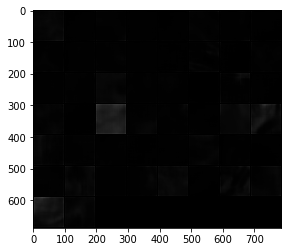

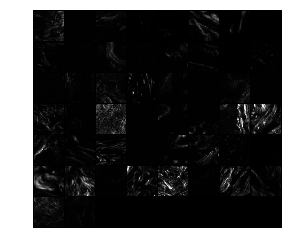

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


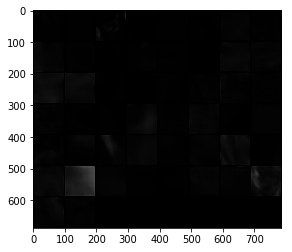

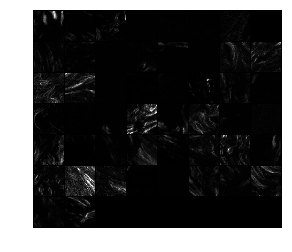

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


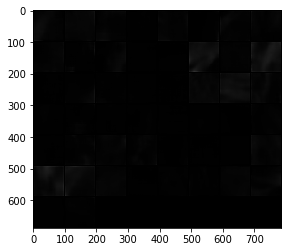

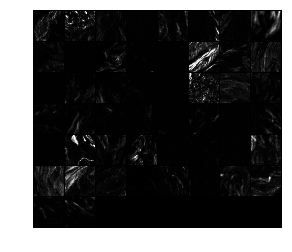

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


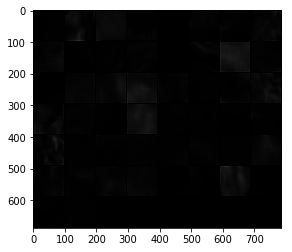

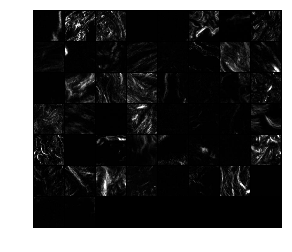

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


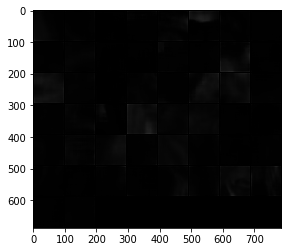

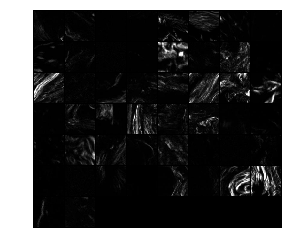

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


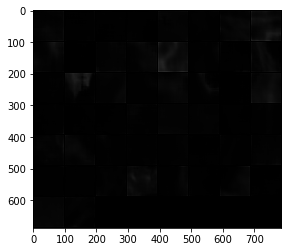

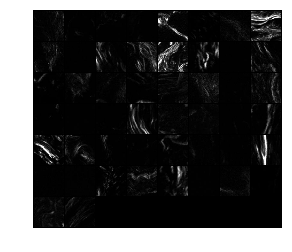

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


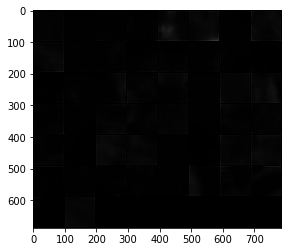

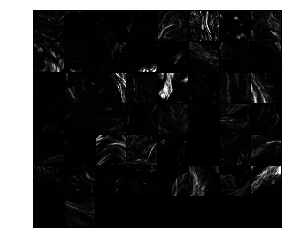

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


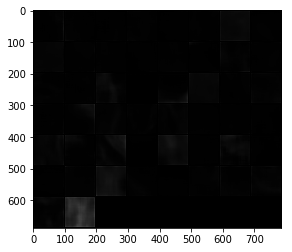

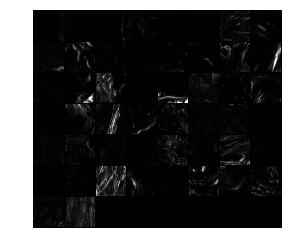

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


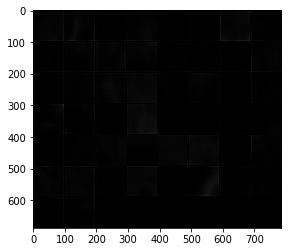

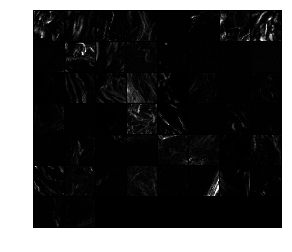

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


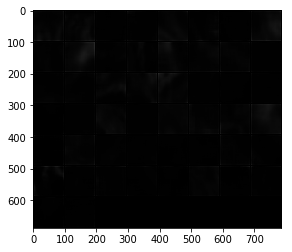

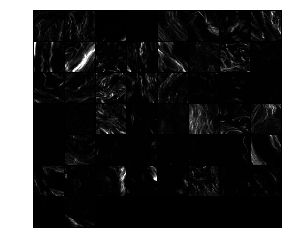

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


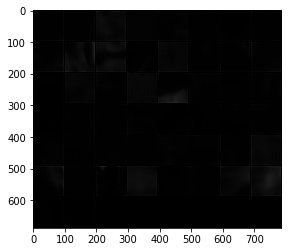

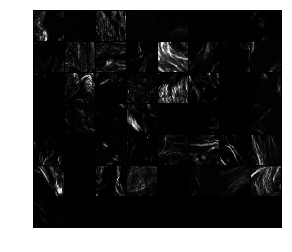

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


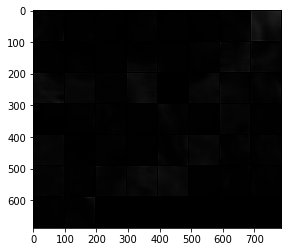

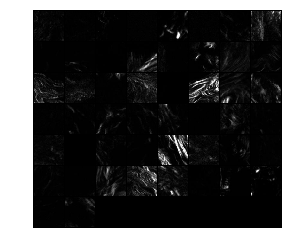

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


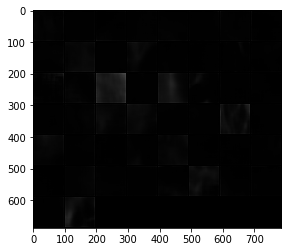

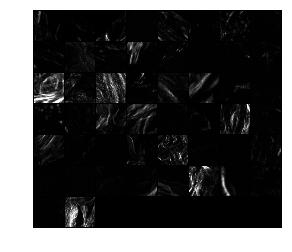

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


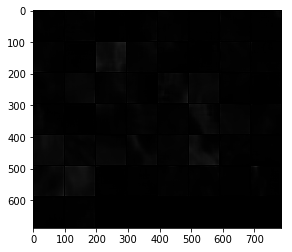

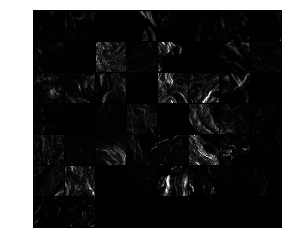

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


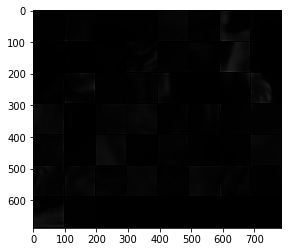

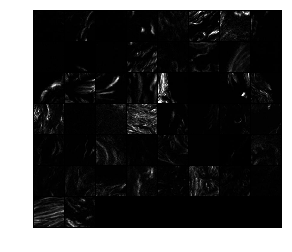

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


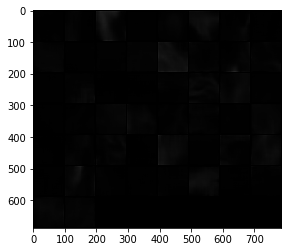

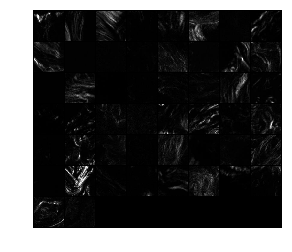

torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


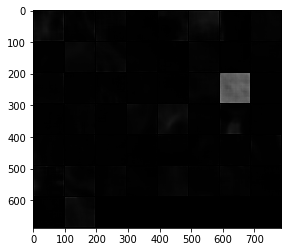

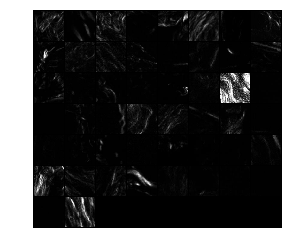

===> Avg. PSNR: nan dB


In [18]:
test()

In [47]:
l = 0.0001
p = 0.5
windowsize = 3
for epoch in range(1, 18 + 1):
    if epoch%2 == 0:
        windowsize = windowsize+1
        p = p*0.8
        l = l*0.2
        if windowsize == 0:
            windowsze = 1
    optimizer = optim.Adam(model.parameters(), lr=l)
        
    train(epoch, p, windowsize)

lossMSE: 0.00720677524805069 lossSSIM: 0.24130576848983765 lossL1: 0.02773176319897175
===> Epoch[1](0/25343): Loss: 0.1243
lossMSE: 0.003974115941673517 lossSSIM: 0.22134780883789062 lossL1: 0.02153882384300232
===> Epoch[1](50/25343): Loss: 0.1127
lossMSE: 0.005241492763161659 lossSSIM: 0.2651212811470032 lossL1: 0.028001870959997177
===> Epoch[1](100/25343): Loss: 0.1352
lossMSE: 0.00484189298003912 lossSSIM: 0.2167465090751648 lossL1: 0.022515706717967987
===> Epoch[1](150/25343): Loss: 0.1108
lossMSE: 0.0016271495260298252 lossSSIM: 0.17634910345077515 lossL1: 0.013887625187635422
===> Epoch[1](200/25343): Loss: 0.0890
lossMSE: 0.0029420959763228893 lossSSIM: 0.19638371467590332 lossL1: 0.017520137131214142
===> Epoch[1](250/25343): Loss: 0.0997
lossMSE: 0.010980169288814068 lossSSIM: 0.2937527298927307 lossL1: 0.03793223202228546
===> Epoch[1](300/25343): Loss: 0.1524
lossMSE: 0.005072477273643017 lossSSIM: 0.1959613561630249 lossL1: 0.020680785179138184
===> Epoch[1](350/25343):

lossMSE: 0.00611221743747592 lossSSIM: 0.23064225912094116 lossL1: 0.02612907439470291
===> Epoch[1](3250/25343): Loss: 0.1184
lossMSE: 0.012419558130204678 lossSSIM: 0.2847210168838501 lossL1: 0.038612257689237595
===> Epoch[1](3300/25343): Loss: 0.1486
lossMSE: 0.003711524186655879 lossSSIM: 0.23055821657180786 lossL1: 0.02233792282640934
===> Epoch[1](3350/25343): Loss: 0.1171
lossMSE: 0.0022020936012268066 lossSSIM: 0.23092001676559448 lossL1: 0.01780414953827858
===> Epoch[1](3400/25343): Loss: 0.1166
lossMSE: 0.0076707652769982815 lossSSIM: 0.2571173906326294 lossL1: 0.030662987381219864
===> Epoch[1](3450/25343): Loss: 0.1324
lossMSE: 0.006383279804140329 lossSSIM: 0.2592034935951233 lossL1: 0.028352592140436172
===> Epoch[1](3500/25343): Loss: 0.1328
lossMSE: 0.006941675674170256 lossSSIM: 0.21169084310531616 lossL1: 0.025570478290319443
===> Epoch[1](3550/25343): Loss: 0.1093
lossMSE: 0.009626459330320358 lossSSIM: 0.3257378935813904 lossL1: 0.039450861513614655
===> Epoch[1](

lossMSE: 0.006573617458343506 lossSSIM: 0.21298789978027344 lossL1: 0.024991115555167198
===> Epoch[1](6500/25343): Loss: 0.1098
lossMSE: 0.004589431453496218 lossSSIM: 0.20603585243225098 lossL1: 0.02002669870853424
===> Epoch[1](6550/25343): Loss: 0.1053
lossMSE: 0.0024832352064549923 lossSSIM: 0.1889328956604004 lossL1: 0.015628356486558914
===> Epoch[1](6600/25343): Loss: 0.0957
lossMSE: 0.0022718978580087423 lossSSIM: 0.22761154174804688 lossL1: 0.018242714926600456
===> Epoch[1](6650/25343): Loss: 0.1149
lossMSE: 0.002415392082184553 lossSSIM: 0.196402907371521 lossL1: 0.01712542399764061
===> Epoch[1](6700/25343): Loss: 0.0994
lossMSE: 0.005802856758236885 lossSSIM: 0.2628215551376343 lossL1: 0.027836114168167114
===> Epoch[1](6750/25343): Loss: 0.1343
lossMSE: 0.005105866119265556 lossSSIM: 0.23250019550323486 lossL1: 0.023827627301216125
===> Epoch[1](6800/25343): Loss: 0.1188
lossMSE: 0.004311782773584127 lossSSIM: 0.21031779050827026 lossL1: 0.019577397033572197
===> Epoch[1

lossMSE: 0.0034922845661640167 lossSSIM: 0.21707606315612793 lossL1: 0.021781278774142265
===> Epoch[1](9700/25343): Loss: 0.1103
lossMSE: 0.002344042295590043 lossSSIM: 0.2111414074897766 lossL1: 0.018213769420981407
===> Epoch[1](9750/25343): Loss: 0.1067
lossMSE: 0.0074272360652685165 lossSSIM: 0.251179575920105 lossL1: 0.029352277517318726
===> Epoch[1](9800/25343): Loss: 0.1293
lossMSE: 0.004470834508538246 lossSSIM: 0.21152377128601074 lossL1: 0.022020023316144943
===> Epoch[1](9850/25343): Loss: 0.1080
lossMSE: 0.003557570744305849 lossSSIM: 0.21447336673736572 lossL1: 0.020646708086133003
===> Epoch[1](9900/25343): Loss: 0.1090
lossMSE: 0.007100685499608517 lossSSIM: 0.2777853012084961 lossL1: 0.031005259603261948
===> Epoch[1](9950/25343): Loss: 0.1424
lossMSE: 0.0026698135770857334 lossSSIM: 0.18759161233901978 lossL1: 0.01767437532544136
===> Epoch[1](10000/25343): Loss: 0.0951
lossMSE: 0.006098092533648014 lossSSIM: 0.24677103757858276 lossL1: 0.025248544290661812
===> Epoc

lossMSE: 0.005908055230975151 lossSSIM: 0.22596657276153564 lossL1: 0.024181369692087173
===> Epoch[1](12900/25343): Loss: 0.1159
lossMSE: 0.011817707680165768 lossSSIM: 0.2360134720802307 lossL1: 0.03391404449939728
===> Epoch[1](12950/25343): Loss: 0.1239
lossMSE: 0.008286494761705399 lossSSIM: 0.23036575317382812 lossL1: 0.027186652645468712
===> Epoch[1](13000/25343): Loss: 0.1193
lossMSE: 0.003966445568948984 lossSSIM: 0.22491717338562012 lossL1: 0.02057252638041973
===> Epoch[1](13050/25343): Loss: 0.1144
lossMSE: 0.001854537520557642 lossSSIM: 0.22212529182434082 lossL1: 0.016982754692435265
===> Epoch[1](13100/25343): Loss: 0.1120
lossMSE: 0.00800444558262825 lossSSIM: 0.2486577033996582 lossL1: 0.02940482646226883
===> Epoch[1](13150/25343): Loss: 0.1283
lossMSE: 0.008442025631666183 lossSSIM: 0.26545125246047974 lossL1: 0.03237041458487511
===> Epoch[1](13200/25343): Loss: 0.1369
lossMSE: 0.003648048499599099 lossSSIM: 0.2000201940536499 lossL1: 0.018585970625281334
===> Epoc

lossMSE: 0.0055757611989974976 lossSSIM: 0.21291685104370117 lossL1: 0.023633664473891258
===> Epoch[1](16100/25343): Loss: 0.1092
lossMSE: 0.00363484350964427 lossSSIM: 0.23542749881744385 lossL1: 0.021867459639906883
===> Epoch[1](16150/25343): Loss: 0.1195
lossMSE: 0.008557092398405075 lossSSIM: 0.28048276901245117 lossL1: 0.034855861216783524
===> Epoch[1](16200/25343): Loss: 0.1445
lossMSE: 0.004605064168572426 lossSSIM: 0.2330867052078247 lossL1: 0.02460635080933571
===> Epoch[1](16250/25343): Loss: 0.1188
lossMSE: 0.008242522366344929 lossSSIM: 0.2357000708580017 lossL1: 0.029507994651794434
===> Epoch[1](16300/25343): Loss: 0.1220
lossMSE: 0.012073959223926067 lossSSIM: 0.32343757152557373 lossL1: 0.04180264472961426
===> Epoch[1](16350/25343): Loss: 0.1678
lossMSE: 0.0060707274824380875 lossSSIM: 0.22950536012649536 lossL1: 0.024025462567806244
===> Epoch[1](16400/25343): Loss: 0.1178
lossMSE: 0.0064378771930933 lossSSIM: 0.23175954818725586 lossL1: 0.027377063408493996
===> E

lossMSE: 0.007990598678588867 lossSSIM: 0.2614249587059021 lossL1: 0.031586408615112305
===> Epoch[1](19300/25343): Loss: 0.1347
lossMSE: 0.00875886157155037 lossSSIM: 0.25595808029174805 lossL1: 0.032394640147686005
===> Epoch[1](19350/25343): Loss: 0.1324
lossMSE: 0.0022848923690617085 lossSSIM: 0.18247562646865845 lossL1: 0.015749597921967506
===> Epoch[1](19400/25343): Loss: 0.0924
lossMSE: 0.005598677787929773 lossSSIM: 0.2243436574935913 lossL1: 0.023047935217618942
===> Epoch[1](19450/25343): Loss: 0.1150
lossMSE: 0.005819415207952261 lossSSIM: 0.23188155889511108 lossL1: 0.02443055436015129
===> Epoch[1](19500/25343): Loss: 0.1189
lossMSE: 0.0022355313412845135 lossSSIM: 0.2109624743461609 lossL1: 0.01648890972137451
===> Epoch[1](19550/25343): Loss: 0.1066
lossMSE: 0.010104339569807053 lossSSIM: 0.238214373588562 lossL1: 0.03248637914657593
===> Epoch[1](19600/25343): Loss: 0.1242
lossMSE: 0.01345903892070055 lossSSIM: 0.2638598680496216 lossL1: 0.03817764297127724
===> Epoch[

lossMSE: 0.0024948769714683294 lossSSIM: 0.22188156843185425 lossL1: 0.018498454242944717
===> Epoch[1](22500/25343): Loss: 0.1122
lossMSE: 0.012016643770039082 lossSSIM: 0.23963677883148193 lossL1: 0.03580109775066376
===> Epoch[1](22550/25343): Loss: 0.1258
lossMSE: 0.004684114828705788 lossSSIM: 0.24530285596847534 lossL1: 0.02439529076218605
===> Epoch[1](22600/25343): Loss: 0.1250
lossMSE: 0.013212651014328003 lossSSIM: 0.23759692907333374 lossL1: 0.0341629721224308
===> Epoch[1](22650/25343): Loss: 0.1254
lossMSE: 0.005656260531395674 lossSSIM: 0.23318970203399658 lossL1: 0.02624848671257496
===> Epoch[1](22700/25343): Loss: 0.1194
lossMSE: 0.012111809104681015 lossSSIM: 0.2984681725502014 lossL1: 0.041904762387275696
===> Epoch[1](22750/25343): Loss: 0.1553
lossMSE: 0.009834700264036655 lossSSIM: 0.2373291254043579 lossL1: 0.03079521656036377
===> Epoch[1](22800/25343): Loss: 0.1236
lossMSE: 0.004807736724615097 lossSSIM: 0.21971219778060913 lossL1: 0.022123143076896667
===> Epo

lossMSE: 0.003965208772569895 lossSSIM: 0.22245264053344727 lossL1: 0.020942747592926025
===> Epoch[2](350/25343): Loss: 0.1351
lossMSE: 0.006964759901165962 lossSSIM: 0.2387273907661438 lossL1: 0.0268040020018816
===> Epoch[2](400/25343): Loss: 0.1460
lossMSE: 0.0046811699867248535 lossSSIM: 0.18884533643722534 lossL1: 0.017809458076953888
===> Epoch[2](450/25343): Loss: 0.1152
lossMSE: 0.007880200631916523 lossSSIM: 0.27378416061401367 lossL1: 0.03040199726819992
===> Epoch[2](500/25343): Loss: 0.1674
lossMSE: 0.01014595478773117 lossSSIM: 0.2670316696166992 lossL1: 0.03298357501626015
===> Epoch[2](550/25343): Loss: 0.1643
lossMSE: 0.005857206881046295 lossSSIM: 0.2107793688774109 lossL1: 0.02307713031768799
===> Epoch[2](600/25343): Loss: 0.1288
lossMSE: 0.004478170070797205 lossSSIM: 0.22795987129211426 lossL1: 0.021746771410107613
===> Epoch[2](650/25343): Loss: 0.1386
lossMSE: 0.009512930177152157 lossSSIM: 0.2981628179550171 lossL1: 0.0359770841896534
===> Epoch[2](700/25343): 

lossMSE: 0.0050291623920202255 lossSSIM: 0.2587410807609558 lossL1: 0.025265464559197426
===> Epoch[2](3600/25343): Loss: 0.1573
lossMSE: 0.005466208793222904 lossSSIM: 0.22769558429718018 lossL1: 0.02258714661002159
===> Epoch[2](3650/25343): Loss: 0.1388
lossMSE: 0.00541645148769021 lossSSIM: 0.20506179332733154 lossL1: 0.02180224284529686
===> Epoch[2](3700/25343): Loss: 0.1252
lossMSE: 0.004948091693222523 lossSSIM: 0.2098451852798462 lossL1: 0.020369429141283035
===> Epoch[2](3750/25343): Loss: 0.1279
lossMSE: 0.0070269289426505566 lossSSIM: 0.2319798469543457 lossL1: 0.026665236800909042
===> Epoch[2](3800/25343): Loss: 0.1420
lossMSE: 0.007160922046750784 lossSSIM: 0.25668442249298096 lossL1: 0.02874496579170227
===> Epoch[2](3850/25343): Loss: 0.1569
lossMSE: 0.005742428824305534 lossSSIM: 0.27533572912216187 lossL1: 0.02805917151272297
===> Epoch[2](3900/25343): Loss: 0.1675
lossMSE: 0.0045347660779953 lossSSIM: 0.21419405937194824 lossL1: 0.02092885598540306
===> Epoch[2](395

lossMSE: 0.016088515520095825 lossSSIM: 0.30935752391815186 lossL1: 0.04341582953929901
===> Epoch[2](6800/25343): Loss: 0.1920
lossMSE: 0.00526807364076376 lossSSIM: 0.2070900797843933 lossL1: 0.019590063020586967
===> Epoch[2](6850/25343): Loss: 0.1264
lossMSE: 0.002756900154054165 lossSSIM: 0.20597916841506958 lossL1: 0.017045583575963974
===> Epoch[2](6900/25343): Loss: 0.1247
lossMSE: 0.007265039719641209 lossSSIM: 0.27844226360321045 lossL1: 0.03157452866435051
===> Epoch[2](6950/25343): Loss: 0.1700
lossMSE: 0.005112227518111467 lossSSIM: 0.26003074645996094 lossL1: 0.026116929948329926
===> Epoch[2](7000/25343): Loss: 0.1581
lossMSE: 0.003503074636682868 lossSSIM: 0.21189641952514648 lossL1: 0.01927216909825802
===> Epoch[2](7050/25343): Loss: 0.1285
lossMSE: 0.00585559755563736 lossSSIM: 0.24121850728988647 lossL1: 0.02503730170428753
===> Epoch[2](7100/25343): Loss: 0.1471
lossMSE: 0.0024680360220372677 lossSSIM: 0.21134942770004272 lossL1: 0.0167397353798151
===> Epoch[2](71

lossMSE: 0.004209004808217287 lossSSIM: 0.21736359596252441 lossL1: 0.020748058333992958
===> Epoch[2](10000/25343): Loss: 0.1321
lossMSE: 0.006388968788087368 lossSSIM: 0.3052126169204712 lossL1: 0.030558228492736816
===> Epoch[2](10050/25343): Loss: 0.1857
lossMSE: 0.008176754228770733 lossSSIM: 0.2327061891555786 lossL1: 0.028584612533450127
===> Epoch[2](10100/25343): Loss: 0.1429
lossMSE: 0.0065573775209486485 lossSSIM: 0.2115219235420227 lossL1: 0.023799031972885132
===> Epoch[2](10150/25343): Loss: 0.1295
lossMSE: 0.0056106653064489365 lossSSIM: 0.24226993322372437 lossL1: 0.024839745834469795
===> Epoch[2](10200/25343): Loss: 0.1476
lossMSE: 0.007633896544575691 lossSSIM: 0.23834574222564697 lossL1: 0.026791103184223175
===> Epoch[2](10250/25343): Loss: 0.1461
lossMSE: 0.006511488929390907 lossSSIM: 0.23527729511260986 lossL1: 0.025871196761727333
===> Epoch[2](10300/25343): Loss: 0.1438
lossMSE: 0.005092387553304434 lossSSIM: 0.2663625478744507 lossL1: 0.024948691949248314
===

lossMSE: 0.0027762344107031822 lossSSIM: 0.22019976377487183 lossL1: 0.018855977803468704
===> Epoch[2](13200/25343): Loss: 0.1332
lossMSE: 0.0030048165936022997 lossSSIM: 0.2620171308517456 lossL1: 0.0226385947316885
===> Epoch[2](13250/25343): Loss: 0.1584
lossMSE: 0.002764957258477807 lossSSIM: 0.20843714475631714 lossL1: 0.01750592142343521
===> Epoch[2](13300/25343): Loss: 0.1262
lossMSE: 0.005260922014713287 lossSSIM: 0.24386447668075562 lossL1: 0.02489873394370079
===> Epoch[2](13350/25343): Loss: 0.1484
lossMSE: 0.00820157304406166 lossSSIM: 0.24040353298187256 lossL1: 0.028602924197912216
===> Epoch[2](13400/25343): Loss: 0.1475
lossMSE: 0.008394747041165829 lossSSIM: 0.2209758162498474 lossL1: 0.025373032316565514
===> Epoch[2](13450/25343): Loss: 0.1359
lossMSE: 0.010505489073693752 lossSSIM: 0.2822575569152832 lossL1: 0.03586914762854576
===> Epoch[2](13500/25343): Loss: 0.1736
lossMSE: 0.00873303972184658 lossSSIM: 0.284731924533844 lossL1: 0.031448714435100555
===> Epoch[

lossMSE: 0.0046946280635893345 lossSSIM: 0.20968103408813477 lossL1: 0.02042650617659092
===> Epoch[2](16400/25343): Loss: 0.1277
lossMSE: 0.0035398313775658607 lossSSIM: 0.23031353950500488 lossL1: 0.02056216262280941
===> Epoch[2](16450/25343): Loss: 0.1396
lossMSE: 0.007580393925309181 lossSSIM: 0.25458210706710815 lossL1: 0.029578132554888725
===> Epoch[2](16500/25343): Loss: 0.1558
lossMSE: 0.00782316830009222 lossSSIM: 0.22417843341827393 lossL1: 0.026173586025834084
===> Epoch[2](16550/25343): Loss: 0.1376
lossMSE: 0.0022367138881236315 lossSSIM: 0.18448036909103394 lossL1: 0.01553057599812746
===> Epoch[2](16600/25343): Loss: 0.1116
lossMSE: 0.003150169737637043 lossSSIM: 0.20342940092086792 lossL1: 0.016664501279592514
===> Epoch[2](16650/25343): Loss: 0.1233
lossMSE: 0.013058836571872234 lossSSIM: 0.22927933931350708 lossL1: 0.03330935537815094
===> Epoch[2](16700/25343): Loss: 0.1428
lossMSE: 0.002932715928182006 lossSSIM: 0.22724312543869019 lossL1: 0.019751032814383507
===

lossMSE: 0.009872598573565483 lossSSIM: 0.2985355854034424 lossL1: 0.03737844526767731
===> Epoch[2](19600/25343): Loss: 0.1831
lossMSE: 0.007707243785262108 lossSSIM: 0.23877346515655518 lossL1: 0.02612840197980404
===> Epoch[2](19650/25343): Loss: 0.1463
lossMSE: 0.01111953891813755 lossSSIM: 0.24598562717437744 lossL1: 0.032623350620269775
===> Epoch[2](19700/25343): Loss: 0.1520
lossMSE: 0.003916737623512745 lossSSIM: 0.24596649408340454 lossL1: 0.022394653409719467
===> Epoch[2](19750/25343): Loss: 0.1491
lossMSE: 0.002583339810371399 lossSSIM: 0.19049960374832153 lossL1: 0.016458768397569656
===> Epoch[2](19800/25343): Loss: 0.1153
lossMSE: 0.0024888080079108477 lossSSIM: 0.22105127573013306 lossL1: 0.01825808733701706
===> Epoch[2](19850/25343): Loss: 0.1336
lossMSE: 0.0036038500256836414 lossSSIM: 0.22899305820465088 lossL1: 0.021407708525657654
===> Epoch[2](19900/25343): Loss: 0.1388
lossMSE: 0.008071133866906166 lossSSIM: 0.28055429458618164 lossL1: 0.032253868877887726
===>

lossMSE: 0.007345331832766533 lossSSIM: 0.23899012804031372 lossL1: 0.025277547538280487
===> Epoch[2](22800/25343): Loss: 0.1463
lossMSE: 0.009920747950673103 lossSSIM: 0.2864683270454407 lossL1: 0.03494328260421753
===> Epoch[2](22850/25343): Loss: 0.1758
lossMSE: 0.0011064473073929548 lossSSIM: 0.1651894450187683 lossL1: 0.011279263533651829
===> Epoch[2](22900/25343): Loss: 0.0996
lossMSE: 0.005818541627377272 lossSSIM: 0.25874269008636475 lossL1: 0.026809433475136757
===> Epoch[2](22950/25343): Loss: 0.1576
lossMSE: 0.0015849339542910457 lossSSIM: 0.17586827278137207 lossL1: 0.012918275780975819
===> Epoch[2](23000/25343): Loss: 0.1062
lossMSE: 0.011817576363682747 lossSSIM: 0.3303847908973694 lossL1: 0.0413675531744957
===> Epoch[2](23050/25343): Loss: 0.2030
lossMSE: 0.005002873484045267 lossSSIM: 0.2268296480178833 lossL1: 0.022046193480491638
===> Epoch[2](23100/25343): Loss: 0.1381
lossMSE: 0.006633889861404896 lossSSIM: 0.2534066438674927 lossL1: 0.027629371732473373
===> Ep

lossMSE: 0.005209097173064947 lossSSIM: 0.23024475574493408 lossL1: 0.0230235755443573
===> Epoch[3](650/25343): Loss: 0.1402
lossMSE: 0.004787534475326538 lossSSIM: 0.24244707822799683 lossL1: 0.023408792912960052
===> Epoch[3](700/25343): Loss: 0.1474
lossMSE: 0.013203077018260956 lossSSIM: 0.23702049255371094 lossL1: 0.03310496360063553
===> Epoch[3](750/25343): Loss: 0.1475
lossMSE: 0.0025904907379299402 lossSSIM: 0.20634835958480835 lossL1: 0.0178491473197937
===> Epoch[3](800/25343): Loss: 0.1248
lossMSE: 0.004161848220974207 lossSSIM: 0.24042737483978271 lossL1: 0.02313719503581524
===> Epoch[3](850/25343): Loss: 0.1459
lossMSE: 0.003217893885448575 lossSSIM: 0.18817681074142456 lossL1: 0.017446152865886688
===> Epoch[3](900/25343): Loss: 0.1142
lossMSE: 0.016181282699108124 lossSSIM: 0.2756745219230652 lossL1: 0.042787179350852966
===> Epoch[3](950/25343): Loss: 0.1719
lossMSE: 0.003092902945354581 lossSSIM: 0.2058861255645752 lossL1: 0.018329977989196777
===> Epoch[3](1000/253

lossMSE: 0.008703293278813362 lossSSIM: 0.22578662633895874 lossL1: 0.028245512396097183
===> Epoch[3](3850/25343): Loss: 0.1390
lossMSE: 0.004688449203968048 lossSSIM: 0.2045556902885437 lossL1: 0.020576655864715576
===> Epoch[3](3900/25343): Loss: 0.1246
lossMSE: 0.006087017711251974 lossSSIM: 0.25039148330688477 lossL1: 0.02813996560871601
===> Epoch[3](3950/25343): Loss: 0.1527
lossMSE: 0.010670073330402374 lossSSIM: 0.2465496063232422 lossL1: 0.030879782512784004
===> Epoch[3](4000/25343): Loss: 0.1522
lossMSE: 0.006150456145405769 lossSSIM: 0.2981985807418823 lossL1: 0.030728118494153023
===> Epoch[3](4050/25343): Loss: 0.1814
lossMSE: 0.016596969217061996 lossSSIM: 0.3541123867034912 lossL1: 0.051682282239198685
===> Epoch[3](4100/25343): Loss: 0.2191
lossMSE: 0.00983026996254921 lossSSIM: 0.29326486587524414 lossL1: 0.03506992384791374
===> Epoch[3](4150/25343): Loss: 0.1799
lossMSE: 0.011103343218564987 lossSSIM: 0.2599000930786133 lossL1: 0.03489531949162483
===> Epoch[3](420

lossMSE: 0.012345473282039165 lossSSIM: 0.24124199151992798 lossL1: 0.03348403796553612
===> Epoch[3](7050/25343): Loss: 0.1497
lossMSE: 0.006991790607571602 lossSSIM: 0.23519927263259888 lossL1: 0.026692917570471764
===> Epoch[3](7100/25343): Loss: 0.1439
lossMSE: 0.0028104372322559357 lossSSIM: 0.18896687030792236 lossL1: 0.016081728041172028
===> Epoch[3](7150/25343): Loss: 0.1145
lossMSE: 0.007863611914217472 lossSSIM: 0.26518547534942627 lossL1: 0.029890146106481552
===> Epoch[3](7200/25343): Loss: 0.1623
lossMSE: 0.003245072439312935 lossSSIM: 0.19107365608215332 lossL1: 0.016387049108743668
===> Epoch[3](7250/25343): Loss: 0.1159
lossMSE: 0.0046997577883303165 lossSSIM: 0.22920620441436768 lossL1: 0.022606831043958664
===> Epoch[3](7300/25343): Loss: 0.1394
lossMSE: 0.008774262852966785 lossSSIM: 0.2677435874938965 lossL1: 0.030968109145760536
===> Epoch[3](7350/25343): Loss: 0.1642
lossMSE: 0.021082185208797455 lossSSIM: 0.29916542768478394 lossL1: 0.04901646450161934
===> Epoc

lossMSE: 0.004275916609913111 lossSSIM: 0.22601383924484253 lossL1: 0.022490721195936203
===> Epoch[3](10250/25343): Loss: 0.1373
lossMSE: 0.0038474106695502996 lossSSIM: 0.24259984493255615 lossL1: 0.02256973460316658
===> Epoch[3](10300/25343): Loss: 0.1471
lossMSE: 0.0030841792467981577 lossSSIM: 0.22483742237091064 lossL1: 0.019867807626724243
===> Epoch[3](10350/25343): Loss: 0.1361
lossMSE: 0.011792387813329697 lossSSIM: 0.21364480257034302 lossL1: 0.02939625270664692
===> Epoch[3](10400/25343): Loss: 0.1329
lossMSE: 0.006766898557543755 lossSSIM: 0.25588297843933105 lossL1: 0.028860874474048615
===> Epoch[3](10450/25343): Loss: 0.1562
lossMSE: 0.012025894597172737 lossSSIM: 0.24625295400619507 lossL1: 0.03579509258270264
===> Epoch[3](10500/25343): Loss: 0.1526
lossMSE: 0.00938394758850336 lossSSIM: 0.254173219203949 lossL1: 0.03179614990949631
===> Epoch[3](10550/25343): Loss: 0.1563
lossMSE: 0.007454382721334696 lossSSIM: 0.28528285026550293 lossL1: 0.030068226158618927
===> E

lossMSE: 0.00965336337685585 lossSSIM: 0.25708603858947754 lossL1: 0.031602390110492706
===> Epoch[3](13450/25343): Loss: 0.1581
lossMSE: 0.004014572128653526 lossSSIM: 0.21462136507034302 lossL1: 0.019812805578112602
===> Epoch[3](13500/25343): Loss: 0.1304
lossMSE: 0.0068297418765723705 lossSSIM: 0.26726436614990234 lossL1: 0.028921177610754967
===> Epoch[3](13550/25343): Loss: 0.1631
lossMSE: 0.003359851660206914 lossSSIM: 0.22556734085083008 lossL1: 0.020631995052099228
===> Epoch[3](13600/25343): Loss: 0.1367
lossMSE: 0.006393382791429758 lossSSIM: 0.26304084062576294 lossL1: 0.028074072673916817
===> Epoch[3](13650/25343): Loss: 0.1604
lossMSE: 0.004382977727800608 lossSSIM: 0.20958709716796875 lossL1: 0.020054137334227562
===> Epoch[3](13700/25343): Loss: 0.1275
lossMSE: 0.003940877038985491 lossSSIM: 0.26943063735961914 lossL1: 0.026026219129562378
===> Epoch[3](13750/25343): Loss: 0.1632
lossMSE: 0.004826939664781094 lossSSIM: 0.23810571432113647 lossL1: 0.0236295685172081
===

lossMSE: 0.010822081938385963 lossSSIM: 0.30963873863220215 lossL1: 0.038584183901548386
===> Epoch[3](16650/25343): Loss: 0.1901
lossMSE: 0.002638866426423192 lossSSIM: 0.22133558988571167 lossL1: 0.017599541693925858
===> Epoch[3](16700/25343): Loss: 0.1339
lossMSE: 0.008272715844213963 lossSSIM: 0.2309558391571045 lossL1: 0.02831992879509926
===> Epoch[3](16750/25343): Loss: 0.1419
lossMSE: 0.003326492151245475 lossSSIM: 0.25062137842178345 lossL1: 0.021826930344104767
===> Epoch[3](16800/25343): Loss: 0.1517
lossMSE: 0.006215343717485666 lossSSIM: 0.342166543006897 lossL1: 0.034058310091495514
===> Epoch[3](16850/25343): Loss: 0.2078
lossMSE: 0.0032912539318203926 lossSSIM: 0.23280102014541626 lossL1: 0.020931648090481758
===> Epoch[3](16900/25343): Loss: 0.1410
lossMSE: 0.002745525212958455 lossSSIM: 0.21047675609588623 lossL1: 0.017931204289197922
===> Epoch[3](16950/25343): Loss: 0.1274
lossMSE: 0.010224360972642899 lossSSIM: 0.2132434844970703 lossL1: 0.028241673484444618
===> 

lossMSE: 0.014018621295690536 lossSSIM: 0.28096020221710205 lossL1: 0.042835548520088196
===> Epoch[3](19850/25343): Loss: 0.1742
lossMSE: 0.0058776396326720715 lossSSIM: 0.22441893815994263 lossL1: 0.023529695346951485
===> Epoch[3](19900/25343): Loss: 0.1370
lossMSE: 0.005049522500485182 lossSSIM: 0.25897443294525146 lossL1: 0.025593513622879982
===> Epoch[3](19950/25343): Loss: 0.1574
lossMSE: 0.008735203184187412 lossSSIM: 0.2537684440612793 lossL1: 0.030788607895374298
===> Epoch[3](20000/25343): Loss: 0.1558
lossMSE: 0.019548574462532997 lossSSIM: 0.25567853450775146 lossL1: 0.041237663477659225
===> Epoch[3](20050/25343): Loss: 0.1612
lossMSE: 0.007353221997618675 lossSSIM: 0.26279008388519287 lossL1: 0.028616037219762802
===> Epoch[3](20100/25343): Loss: 0.1606
lossMSE: 0.007859185338020325 lossSSIM: 0.25502222776412964 lossL1: 0.029360009357333183
===> Epoch[3](20150/25343): Loss: 0.1562
lossMSE: 0.006802378222346306 lossSSIM: 0.24320441484451294 lossL1: 0.025806179270148277
=

lossMSE: 0.010030233301222324 lossSSIM: 0.273262619972229 lossL1: 0.03503013402223587
===> Epoch[3](23050/25343): Loss: 0.1680
lossMSE: 0.007855255156755447 lossSSIM: 0.23977744579315186 lossL1: 0.026931127533316612
===> Epoch[3](23100/25343): Loss: 0.1470
lossMSE: 0.005301017314195633 lossSSIM: 0.20669150352478027 lossL1: 0.022609122097492218
===> Epoch[3](23150/25343): Loss: 0.1261
lossMSE: 0.006895070429891348 lossSSIM: 0.23854988813400269 lossL1: 0.02805708907544613
===> Epoch[3](23200/25343): Loss: 0.1459
lossMSE: 0.006594691891223192 lossSSIM: 0.2663755416870117 lossL1: 0.027426425367593765
===> Epoch[3](23250/25343): Loss: 0.1625
lossMSE: 0.008238870650529861 lossSSIM: 0.2925730347633362 lossL1: 0.031698815524578094
===> Epoch[3](23300/25343): Loss: 0.1788
lossMSE: 0.008325100876390934 lossSSIM: 0.26743823289871216 lossL1: 0.02889396995306015
===> Epoch[3](23350/25343): Loss: 0.1638
lossMSE: 0.002432811539620161 lossSSIM: 0.18297910690307617 lossL1: 0.015106486156582832
===> Epo

lossMSE: 0.008204858750104904 lossSSIM: 0.2861233949661255 lossL1: 0.03244372084736824
===> Epoch[4](900/25343): Loss: 0.1972
lossMSE: 0.00990594457834959 lossSSIM: 0.25911426544189453 lossL1: 0.030392123386263847
===> Epoch[4](950/25343): Loss: 0.1794
lossMSE: 0.007785600144416094 lossSSIM: 0.280521035194397 lossL1: 0.03105706349015236
===> Epoch[4](1000/25343): Loss: 0.1932
lossMSE: 0.0038210845086723566 lossSSIM: 0.2502492070198059 lossL1: 0.02137606032192707
===> Epoch[4](1050/25343): Loss: 0.1714
lossMSE: 0.004886881913989782 lossSSIM: 0.2737888693809509 lossL1: 0.02595409005880356
===> Epoch[4](1100/25343): Loss: 0.1877
lossMSE: 0.007265673950314522 lossSSIM: 0.2766280174255371 lossL1: 0.029957639053463936
===> Epoch[4](1150/25343): Loss: 0.1904
lossMSE: 0.006937133613973856 lossSSIM: 0.2121376395225525 lossL1: 0.023493152111768723
===> Epoch[4](1200/25343): Loss: 0.1465
lossMSE: 0.012301776558160782 lossSSIM: 0.2530078887939453 lossL1: 0.03427784889936447
===> Epoch[4](1250/2534

lossMSE: 0.0026787584647536278 lossSSIM: 0.22083330154418945 lossL1: 0.018432974815368652
===> Epoch[4](4150/25343): Loss: 0.1510
lossMSE: 0.007035651244223118 lossSSIM: 0.28030145168304443 lossL1: 0.029608896002173424
===> Epoch[4](4200/25343): Loss: 0.1929
lossMSE: 0.006194542162120342 lossSSIM: 0.2943153381347656 lossL1: 0.029159337282180786
===> Epoch[4](4250/25343): Loss: 0.2021
lossMSE: 0.009547773748636246 lossSSIM: 0.27751123905181885 lossL1: 0.03317822515964508
===> Epoch[4](4300/25343): Loss: 0.1918
lossMSE: 0.008570647798478603 lossSSIM: 0.33796876668930054 lossL1: 0.0356932207942009
===> Epoch[4](4350/25343): Loss: 0.2326
lossMSE: 0.00908470805734396 lossSSIM: 0.2911841869354248 lossL1: 0.03152139112353325
===> Epoch[4](4400/25343): Loss: 0.2009
lossMSE: 0.004031732678413391 lossSSIM: 0.22263967990875244 lossL1: 0.021149685606360435
===> Epoch[4](4450/25343): Loss: 0.1527
lossMSE: 0.0051576499827206135 lossSSIM: 0.2655160427093506 lossL1: 0.026724934577941895
===> Epoch[4](

lossMSE: 0.012716253288090229 lossSSIM: 0.2959047555923462 lossL1: 0.03914336487650871
===> Epoch[4](7350/25343): Loss: 0.2053
lossMSE: 0.004555020947009325 lossSSIM: 0.2196272611618042 lossL1: 0.021178748458623886
===> Epoch[4](7400/25343): Loss: 0.1508
lossMSE: 0.0040597859770059586 lossSSIM: 0.2538059949874878 lossL1: 0.023107532411813736
===> Epoch[4](7450/25343): Loss: 0.1739
lossMSE: 0.0049212160520255566 lossSSIM: 0.21094226837158203 lossL1: 0.02044486626982689
===> Epoch[4](7500/25343): Loss: 0.1450
lossMSE: 0.0042903004214167595 lossSSIM: 0.21440094709396362 lossL1: 0.020121101289987564
===> Epoch[4](7550/25343): Loss: 0.1472
lossMSE: 0.005573057569563389 lossSSIM: 0.2941244840621948 lossL1: 0.02832748554646969
===> Epoch[4](7600/25343): Loss: 0.2018
lossMSE: 0.007066344376653433 lossSSIM: 0.2453731894493103 lossL1: 0.025773078203201294
===> Epoch[4](7650/25343): Loss: 0.1691
lossMSE: 0.004270663019269705 lossSSIM: 0.20758908987045288 lossL1: 0.01975879818201065
===> Epoch[4](

lossMSE: 0.005419857334345579 lossSSIM: 0.23548436164855957 lossL1: 0.023279719054698944
===> Epoch[4](10550/25343): Loss: 0.1619
lossMSE: 0.0035102060064673424 lossSSIM: 0.23209470510482788 lossL1: 0.019107146188616753
===> Epoch[4](10600/25343): Loss: 0.1589
lossMSE: 0.011227725073695183 lossSSIM: 0.26007652282714844 lossL1: 0.03229376673698425
===> Epoch[4](10650/25343): Loss: 0.1804
lossMSE: 0.007232196629047394 lossSSIM: 0.2362813949584961 lossL1: 0.025376515462994576
===> Epoch[4](10700/25343): Loss: 0.1630
lossMSE: 0.00911816954612732 lossSSIM: 0.2838929295539856 lossL1: 0.0345364585518837
===> Epoch[4](10750/25343): Loss: 0.1960
lossMSE: 0.005014711990952492 lossSSIM: 0.24754828214645386 lossL1: 0.02442135661840439
===> Epoch[4](10800/25343): Loss: 0.1699
lossMSE: 0.0046764882281422615 lossSSIM: 0.2548113465309143 lossL1: 0.023180652409791946
===> Epoch[4](10850/25343): Loss: 0.1748
lossMSE: 0.003664105199277401 lossSSIM: 0.2340037226676941 lossL1: 0.020224545150995255
===> Epo

lossMSE: 0.0019031842239201069 lossSSIM: 0.21332013607025146 lossL1: 0.016286280006170273
===> Epoch[4](13750/25343): Loss: 0.1457
lossMSE: 0.0067848446778953075 lossSSIM: 0.24467945098876953 lossL1: 0.026061899960041046
===> Epoch[4](13800/25343): Loss: 0.1686
lossMSE: 0.006204430479556322 lossSSIM: 0.24713122844696045 lossL1: 0.024861212819814682
===> Epoch[4](13850/25343): Loss: 0.1700
lossMSE: 0.005719453562051058 lossSSIM: 0.2784227728843689 lossL1: 0.02736268937587738
===> Epoch[4](13900/25343): Loss: 0.1912
lossMSE: 0.008587067015469074 lossSSIM: 0.29333561658859253 lossL1: 0.0326877124607563
===> Epoch[4](13950/25343): Loss: 0.2022
lossMSE: 0.005189803894609213 lossSSIM: 0.24145758152008057 lossL1: 0.023087194189429283
===> Epoch[4](14000/25343): Loss: 0.1659
lossMSE: 0.003920612391084433 lossSSIM: 0.2748604416847229 lossL1: 0.024179670959711075
===> Epoch[4](14050/25343): Loss: 0.1882
lossMSE: 0.006058858707547188 lossSSIM: 0.23377132415771484 lossL1: 0.02468327060341835
===> 

lossMSE: 0.0032174803782254457 lossSSIM: 0.2123088240623474 lossL1: 0.018393227830529213
===> Epoch[4](16950/25343): Loss: 0.1454
lossMSE: 0.003244941122829914 lossSSIM: 0.2119736671447754 lossL1: 0.01720600575208664
===> Epoch[4](17000/25343): Loss: 0.1452
lossMSE: 0.011887635104358196 lossSSIM: 0.26659131050109863 lossL1: 0.03427539020776749
===> Epoch[4](17050/25343): Loss: 0.1851
lossMSE: 0.005750747397542 lossSSIM: 0.23341411352157593 lossL1: 0.02467741072177887
===> Epoch[4](17100/25343): Loss: 0.1606
lossMSE: 0.008737748488783836 lossSSIM: 0.26267874240875244 lossL1: 0.030704306438565254
===> Epoch[4](17150/25343): Loss: 0.1814
lossMSE: 0.004609876312315464 lossSSIM: 0.2670256495475769 lossL1: 0.02502211183309555
===> Epoch[4](17200/25343): Loss: 0.1831
lossMSE: 0.0060596829280257225 lossSSIM: 0.26650381088256836 lossL1: 0.025983601808547974
===> Epoch[4](17250/25343): Loss: 0.1832
lossMSE: 0.007416469976305962 lossSSIM: 0.2389984130859375 lossL1: 0.02729492448270321
===> Epoch[

lossMSE: 0.005586585029959679 lossSSIM: 0.2407131791114807 lossL1: 0.025182045996189117
===> Epoch[4](20150/25343): Loss: 0.1655
lossMSE: 0.011811458505690098 lossSSIM: 0.2965480089187622 lossL1: 0.03724709898233414
===> Epoch[4](20200/25343): Loss: 0.2054
lossMSE: 0.011304497718811035 lossSSIM: 0.28140097856521606 lossL1: 0.03397819772362709
===> Epoch[4](20250/25343): Loss: 0.1950
lossMSE: 0.006628028582781553 lossSSIM: 0.20405268669128418 lossL1: 0.02278894931077957
===> Epoch[4](20300/25343): Loss: 0.1409
lossMSE: 0.003875953843817115 lossSSIM: 0.2653183937072754 lossL1: 0.022484183311462402
===> Epoch[4](20350/25343): Loss: 0.1817
lossMSE: 0.004628527909517288 lossSSIM: 0.2564461827278137 lossL1: 0.025273310020565987
===> Epoch[4](20400/25343): Loss: 0.1759
lossMSE: 0.010204940102994442 lossSSIM: 0.3125242590904236 lossL1: 0.03638923540711403
===> Epoch[4](20450/25343): Loss: 0.2158
lossMSE: 0.003951328806579113 lossSSIM: 0.22758382558822632 lossL1: 0.021248716861009598
===> Epoch

lossMSE: 0.005393164232373238 lossSSIM: 0.24885791540145874 lossL1: 0.02506580948829651
===> Epoch[4](23350/25343): Loss: 0.1709
lossMSE: 0.0036130030639469624 lossSSIM: 0.23809361457824707 lossL1: 0.02086716517806053
===> Epoch[4](23400/25343): Loss: 0.1631
lossMSE: 0.0173234473913908 lossSSIM: 0.3015240430831909 lossL1: 0.04483363777399063
===> Epoch[4](23450/25343): Loss: 0.2106
lossMSE: 0.011153155006468296 lossSSIM: 0.3072717785835266 lossL1: 0.038984302431344986
===> Epoch[4](23500/25343): Loss: 0.2125
lossMSE: 0.01098537351936102 lossSSIM: 0.2509535551071167 lossL1: 0.03136851638555527
===> Epoch[4](23550/25343): Loss: 0.1742
lossMSE: 0.0036237919703125954 lossSSIM: 0.24731141328811646 lossL1: 0.021590841934084892
===> Epoch[4](23600/25343): Loss: 0.1693
lossMSE: 0.008684027008712292 lossSSIM: 0.25038522481918335 lossL1: 0.027746528387069702
===> Epoch[4](23650/25343): Loss: 0.1730
lossMSE: 0.0049520451575517654 lossSSIM: 0.22654730081558228 lossL1: 0.02222609892487526
===> Epoc

lossMSE: 0.008636138401925564 lossSSIM: 0.2458728551864624 lossL1: 0.030163615942001343
===> Epoch[5](1200/25343): Loss: 0.1700
lossMSE: 0.005297137424349785 lossSSIM: 0.2844367027282715 lossL1: 0.026968423277139664
===> Epoch[5](1250/25343): Loss: 0.1951
lossMSE: 0.0042355600744485855 lossSSIM: 0.3014674782752991 lossL1: 0.026953265070915222
===> Epoch[5](1300/25343): Loss: 0.2064
lossMSE: 0.009565223008394241 lossSSIM: 0.30309581756591797 lossL1: 0.032862093299627304
===> Epoch[5](1350/25343): Loss: 0.2092
lossMSE: 0.012343594804406166 lossSSIM: 0.3153596520423889 lossL1: 0.03983771800994873
===> Epoch[5](1400/25343): Loss: 0.2184
lossMSE: 0.007004279177635908 lossSSIM: 0.24440640211105347 lossL1: 0.025238385424017906
===> Epoch[5](1450/25343): Loss: 0.1684
lossMSE: 0.005666857585310936 lossSSIM: 0.2719069719314575 lossL1: 0.027486007660627365
===> Epoch[5](1500/25343): Loss: 0.1867
lossMSE: 0.003127090400084853 lossSSIM: 0.22343790531158447 lossL1: 0.018123136833310127
===> Epoch[5]

lossMSE: 0.008615472353994846 lossSSIM: 0.2520151734352112 lossL1: 0.0293751060962677
===> Epoch[5](4400/25343): Loss: 0.1741
lossMSE: 0.011264911852777004 lossSSIM: 0.2690178155899048 lossL1: 0.03450850024819374
===> Epoch[5](4450/25343): Loss: 0.1865
lossMSE: 0.005768529139459133 lossSSIM: 0.2572569251060486 lossL1: 0.024255458265542984
===> Epoch[5](4500/25343): Loss: 0.1768
lossMSE: 0.011026318185031414 lossSSIM: 0.2594914436340332 lossL1: 0.03284567594528198
===> Epoch[5](4550/25343): Loss: 0.1800
lossMSE: 0.005752728320658207 lossSSIM: 0.2745164632797241 lossL1: 0.027764447033405304
===> Epoch[5](4600/25343): Loss: 0.1885
lossMSE: 0.003125556278973818 lossSSIM: 0.2199876308441162 lossL1: 0.019361475482583046
===> Epoch[5](4650/25343): Loss: 0.1506
lossMSE: 0.005603494122624397 lossSSIM: 0.2103099226951599 lossL1: 0.02054186910390854
===> Epoch[5](4700/25343): Loss: 0.1448
lossMSE: 0.006257397588342428 lossSSIM: 0.20780479907989502 lossL1: 0.022546060383319855
===> Epoch[5](4750/2

lossMSE: 0.004188851453363895 lossSSIM: 0.1957099437713623 lossL1: 0.019954264163970947
===> Epoch[5](7600/25343): Loss: 0.1344
lossMSE: 0.005733403842896223 lossSSIM: 0.24305850267410278 lossL1: 0.02395647019147873
===> Epoch[5](7650/25343): Loss: 0.1671
lossMSE: 0.005156147759407759 lossSSIM: 0.22246360778808594 lossL1: 0.020876353606581688
===> Epoch[5](7700/25343): Loss: 0.1529
lossMSE: 0.007158249616622925 lossSSIM: 0.24303185939788818 lossL1: 0.027059227228164673
===> Epoch[5](7750/25343): Loss: 0.1676
lossMSE: 0.006001766305416822 lossSSIM: 0.1961594820022583 lossL1: 0.021527642384171486
===> Epoch[5](7800/25343): Loss: 0.1353
lossMSE: 0.0015704765683040023 lossSSIM: 0.1875687837600708 lossL1: 0.014359742403030396
===> Epoch[5](7850/25343): Loss: 0.1280
lossMSE: 0.006471483968198299 lossSSIM: 0.22817128896713257 lossL1: 0.023939242586493492
===> Epoch[5](7900/25343): Loss: 0.1572
lossMSE: 0.009173553436994553 lossSSIM: 0.2498759627342224 lossL1: 0.02739420160651207
===> Epoch[5]

lossMSE: 0.006041353102773428 lossSSIM: 0.26990729570388794 lossL1: 0.028034478425979614
===> Epoch[5](10800/25343): Loss: 0.1855
lossMSE: 0.014856817200779915 lossSSIM: 0.3524719476699829 lossL1: 0.04696245118975639
===> Epoch[5](10850/25343): Loss: 0.2444
lossMSE: 0.0076625836081802845 lossSSIM: 0.31435757875442505 lossL1: 0.0333528108894825
===> Epoch[5](10900/25343): Loss: 0.2162
lossMSE: 0.010026498697698116 lossSSIM: 0.24435603618621826 lossL1: 0.028933240100741386
===> Epoch[5](10950/25343): Loss: 0.1694
lossMSE: 0.005680909845978022 lossSSIM: 0.24253088235855103 lossL1: 0.025061922147870064
===> Epoch[5](11000/25343): Loss: 0.1667
lossMSE: 0.0036359962541610003 lossSSIM: 0.22384315729141235 lossL1: 0.019719310104846954
===> Epoch[5](11050/25343): Loss: 0.1534
lossMSE: 0.011385854333639145 lossSSIM: 0.24910986423492432 lossL1: 0.032091304659843445
===> Epoch[5](11100/25343): Loss: 0.1730
lossMSE: 0.012507789768278599 lossSSIM: 0.23809874057769775 lossL1: 0.03180212527513504
===>

lossMSE: 0.008771424181759357 lossSSIM: 0.2377873659133911 lossL1: 0.026330597698688507
===> Epoch[5](14000/25343): Loss: 0.1645
lossMSE: 0.004774705972522497 lossSSIM: 0.21612679958343506 lossL1: 0.020605776458978653
===> Epoch[5](14050/25343): Loss: 0.1485
lossMSE: 0.005426137708127499 lossSSIM: 0.26044243574142456 lossL1: 0.025383146479725838
===> Epoch[5](14100/25343): Loss: 0.1788
lossMSE: 0.0047789886593818665 lossSSIM: 0.22111886739730835 lossL1: 0.021631190553307533
===> Epoch[5](14150/25343): Loss: 0.1519
lossMSE: 0.008431660011410713 lossSSIM: 0.2421259880065918 lossL1: 0.030446402728557587
===> Epoch[5](14200/25343): Loss: 0.1673
lossMSE: 0.003974152263253927 lossSSIM: 0.22839480638504028 lossL1: 0.0207732655107975
===> Epoch[5](14250/25343): Loss: 0.1566
lossMSE: 0.007139618042856455 lossSSIM: 0.23258036375045776 lossL1: 0.02359326183795929
===> Epoch[5](14300/25343): Loss: 0.1604
lossMSE: 0.0036249016411602497 lossSSIM: 0.25516074895858765 lossL1: 0.02193448320031166
===> 

lossMSE: 0.004895804449915886 lossSSIM: 0.2756791114807129 lossL1: 0.024870160967111588
===> Epoch[5](17200/25343): Loss: 0.1890
lossMSE: 0.009426974691450596 lossSSIM: 0.26126670837402344 lossL1: 0.031319208443164825
===> Epoch[5](17250/25343): Loss: 0.1807
lossMSE: 0.015782468020915985 lossSSIM: 0.2579631209373474 lossL1: 0.037985749542713165
===> Epoch[5](17300/25343): Loss: 0.1805
lossMSE: 0.013616436161100864 lossSSIM: 0.2539786100387573 lossL1: 0.035296108573675156
===> Epoch[5](17350/25343): Loss: 0.1771
lossMSE: 0.003558174939826131 lossSSIM: 0.2121182680130005 lossL1: 0.01928318291902542
===> Epoch[5](17400/25343): Loss: 0.1454
lossMSE: 0.004545291885733604 lossSSIM: 0.20514053106307983 lossL1: 0.020233022049069405
===> Epoch[5](17450/25343): Loss: 0.1410
lossMSE: 0.006492105778306723 lossSSIM: 0.2747597098350525 lossL1: 0.027891341596841812
===> Epoch[5](17500/25343): Loss: 0.1889
lossMSE: 0.005967362783849239 lossSSIM: 0.26119792461395264 lossL1: 0.02585514634847641
===> Epo

lossMSE: 0.005103820003569126 lossSSIM: 0.24357104301452637 lossL1: 0.02406308799982071
===> Epoch[5](20400/25343): Loss: 0.1673
lossMSE: 0.008631674572825432 lossSSIM: 0.25060534477233887 lossL1: 0.02993931993842125
===> Epoch[5](20450/25343): Loss: 0.1732
lossMSE: 0.004760541953146458 lossSSIM: 0.27483969926834106 lossL1: 0.02548268809914589
===> Epoch[5](20500/25343): Loss: 0.1884
lossMSE: 0.006775908172130585 lossSSIM: 0.2680531144142151 lossL1: 0.027192529290914536
===> Epoch[5](20550/25343): Loss: 0.1844
lossMSE: 0.0071538398042321205 lossSSIM: 0.2396697998046875 lossL1: 0.026202086359262466
===> Epoch[5](20600/25343): Loss: 0.1653
lossMSE: 0.004402919206768274 lossSSIM: 0.2714003920555115 lossL1: 0.024576907977461815
===> Epoch[5](20650/25343): Loss: 0.1860
lossMSE: 0.005366319790482521 lossSSIM: 0.2543579936027527 lossL1: 0.023483434692025185
===> Epoch[5](20700/25343): Loss: 0.1747
lossMSE: 0.009329610504209995 lossSSIM: 0.2568187117576599 lossL1: 0.028580639511346817
===> Epo

lossMSE: 0.004706443287432194 lossSSIM: 0.21571147441864014 lossL1: 0.020463861525058746
===> Epoch[5](23600/25343): Loss: 0.1482
lossMSE: 0.003131379373371601 lossSSIM: 0.22200167179107666 lossL1: 0.018743254244327545
===> Epoch[5](23650/25343): Loss: 0.1520
lossMSE: 0.004770323168486357 lossSSIM: 0.24344360828399658 lossL1: 0.022617820650339127
===> Epoch[5](23700/25343): Loss: 0.1671
lossMSE: 0.007674979045987129 lossSSIM: 0.28274017572402954 lossL1: 0.029269568622112274
===> Epoch[5](23750/25343): Loss: 0.1947
lossMSE: 0.003419805783778429 lossSSIM: 0.2178676724433899 lossL1: 0.01930813677608967
===> Epoch[5](23800/25343): Loss: 0.1492
lossMSE: 0.004154049791395664 lossSSIM: 0.21491676568984985 lossL1: 0.01930397003889084
===> Epoch[5](23850/25343): Loss: 0.1475
lossMSE: 0.015306385233998299 lossSSIM: 0.35166990756988525 lossL1: 0.047154348343610764
===> Epoch[5](23900/25343): Loss: 0.2440
lossMSE: 0.003696662373840809 lossSSIM: 0.20327633619308472 lossL1: 0.019165363162755966
===>

lossMSE: 0.004223683848977089 lossSSIM: 0.23840010166168213 lossL1: 0.021678747609257698
===> Epoch[6](1450/25343): Loss: 0.1785
lossMSE: 0.009747768752276897 lossSSIM: 0.3055894374847412 lossL1: 0.03487838804721832
===> Epoch[6](1500/25343): Loss: 0.2299
lossMSE: 0.004607630427926779 lossSSIM: 0.24120032787322998 lossL1: 0.021318234503269196
===> Epoch[6](1550/25343): Loss: 0.1806
lossMSE: 0.010706106200814247 lossSSIM: 0.32030636072158813 lossL1: 0.03936779126524925
===> Epoch[6](1600/25343): Loss: 0.2410
lossMSE: 0.0062780012376606464 lossSSIM: 0.24903547763824463 lossL1: 0.025496862828731537
===> Epoch[6](1650/25343): Loss: 0.1869
lossMSE: 0.00679129920899868 lossSSIM: 0.3141079545021057 lossL1: 0.030782924965023994
===> Epoch[6](1700/25343): Loss: 0.2354
lossMSE: 0.006802106276154518 lossSSIM: 0.2839975953102112 lossL1: 0.028849363327026367
===> Epoch[6](1750/25343): Loss: 0.2130
lossMSE: 0.00720597617328167 lossSSIM: 0.2709047794342041 lossL1: 0.0301978662610054
===> Epoch[6](180

lossMSE: 0.005008989945054054 lossSSIM: 0.26665979623794556 lossL1: 0.024730456992983818
===> Epoch[6](4650/25343): Loss: 0.1997
lossMSE: 0.004554960876703262 lossSSIM: 0.278980553150177 lossL1: 0.024677699431777
===> Epoch[6](4700/25343): Loss: 0.2087
lossMSE: 0.007820067927241325 lossSSIM: 0.2563241124153137 lossL1: 0.027642665430903435
===> Epoch[6](4750/25343): Loss: 0.1927
lossMSE: 0.005336708389222622 lossSSIM: 0.21993941068649292 lossL1: 0.022564413025975227
===> Epoch[6](4800/25343): Loss: 0.1650
lossMSE: 0.0034216309431940317 lossSSIM: 0.2199144959449768 lossL1: 0.018612533807754517
===> Epoch[6](4850/25343): Loss: 0.1645
lossMSE: 0.011273052543401718 lossSSIM: 0.26017481088638306 lossL1: 0.03282393887639046
===> Epoch[6](4900/25343): Loss: 0.1965
lossMSE: 0.009901739656925201 lossSSIM: 0.26409751176834106 lossL1: 0.03067759983241558
===> Epoch[6](4950/25343): Loss: 0.1990
lossMSE: 0.005468050949275494 lossSSIM: 0.24898946285247803 lossL1: 0.026063842698931694
===> Epoch[6](50

lossMSE: 0.005630383267998695 lossSSIM: 0.2578357458114624 lossL1: 0.025806844234466553
===> Epoch[6](7850/25343): Loss: 0.1933
lossMSE: 0.003174633951857686 lossSSIM: 0.2375606894493103 lossL1: 0.019606919959187508
===> Epoch[6](7900/25343): Loss: 0.1776
lossMSE: 0.0032712286338210106 lossSSIM: 0.22093242406845093 lossL1: 0.01840357668697834
===> Epoch[6](7950/25343): Loss: 0.1652
lossMSE: 0.003266418818384409 lossSSIM: 0.26179420948028564 lossL1: 0.022036131471395493
===> Epoch[6](8000/25343): Loss: 0.1956
lossMSE: 0.0021520336158573627 lossSSIM: 0.22260379791259766 lossL1: 0.016092870384454727
===> Epoch[6](8050/25343): Loss: 0.1662
lossMSE: 0.006364092230796814 lossSSIM: 0.26301515102386475 lossL1: 0.025915183126926422
===> Epoch[6](8100/25343): Loss: 0.1973
lossMSE: 0.0053382739424705505 lossSSIM: 0.26321011781692505 lossL1: 0.02605358697474003
===> Epoch[6](8150/25343): Loss: 0.1972
lossMSE: 0.013816660270094872 lossSSIM: 0.26749831438064575 lossL1: 0.03592295944690704
===> Epoch

lossMSE: 0.009059097617864609 lossSSIM: 0.2771029472351074 lossL1: 0.031016405671834946
===> Epoch[6](11050/25343): Loss: 0.2085
lossMSE: 0.005094701424241066 lossSSIM: 0.2488730549812317 lossL1: 0.02428700402379036
===> Epoch[6](11100/25343): Loss: 0.1865
lossMSE: 0.008868063800036907 lossSSIM: 0.3135155439376831 lossL1: 0.033397410064935684
===> Epoch[6](11150/25343): Loss: 0.2355
lossMSE: 0.01002766378223896 lossSSIM: 0.2883920669555664 lossL1: 0.03370911628007889
===> Epoch[6](11200/25343): Loss: 0.2171
lossMSE: 0.0070822471752762794 lossSSIM: 0.22134125232696533 lossL1: 0.023889746516942978
===> Epoch[6](11250/25343): Loss: 0.1665
lossMSE: 0.005347616039216518 lossSSIM: 0.21870136260986328 lossL1: 0.023128556087613106
===> Epoch[6](11300/25343): Loss: 0.1641
lossMSE: 0.007278103847056627 lossSSIM: 0.28424739837646484 lossL1: 0.029459185898303986
===> Epoch[6](11350/25343): Loss: 0.2133
lossMSE: 0.004580542910844088 lossSSIM: 0.26060694456100464 lossL1: 0.023853367194533348
===> Ep

lossMSE: 0.005462522152811289 lossSSIM: 0.21739166975021362 lossL1: 0.021485166624188423
===> Epoch[6](14250/25343): Loss: 0.1631
lossMSE: 0.011866367422044277 lossSSIM: 0.2620324492454529 lossL1: 0.034171946346759796
===> Epoch[6](14300/25343): Loss: 0.1980
lossMSE: 0.00507954740896821 lossSSIM: 0.25294971466064453 lossL1: 0.02374946139752865
===> Epoch[6](14350/25343): Loss: 0.1895
lossMSE: 0.0027286263648420572 lossSSIM: 0.2465885877609253 lossL1: 0.01946929469704628
===> Epoch[6](14400/25343): Loss: 0.1842
lossMSE: 0.006578928325325251 lossSSIM: 0.27062880992889404 lossL1: 0.028459258377552032
===> Epoch[6](14450/25343): Loss: 0.2030
lossMSE: 0.008476081304252148 lossSSIM: 0.2681649327278137 lossL1: 0.030391547828912735
===> Epoch[6](14500/25343): Loss: 0.2017
lossMSE: 0.0035512361209839582 lossSSIM: 0.2997550368309021 lossL1: 0.024161428213119507
===> Epoch[6](14550/25343): Loss: 0.2239
lossMSE: 0.007852060720324516 lossSSIM: 0.24439698457717896 lossL1: 0.0259049404412508
===> Epo

lossMSE: 0.012727338820695877 lossSSIM: 0.30095356702804565 lossL1: 0.037425048649311066
===> Epoch[6](17450/25343): Loss: 0.2272
lossMSE: 0.004328826908022165 lossSSIM: 0.20946455001831055 lossL1: 0.02066482976078987
===> Epoch[6](17500/25343): Loss: 0.1569
lossMSE: 0.0074541643261909485 lossSSIM: 0.2708247900009155 lossL1: 0.02854805439710617
===> Epoch[6](17550/25343): Loss: 0.2034
lossMSE: 0.00834185816347599 lossSSIM: 0.2389104962348938 lossL1: 0.027475323528051376
===> Epoch[6](17600/25343): Loss: 0.1799
lossMSE: 0.00930914655327797 lossSSIM: 0.3094820976257324 lossL1: 0.03362131863832474
===> Epoch[6](17650/25343): Loss: 0.2326
lossMSE: 0.006821818649768829 lossSSIM: 0.23061299324035645 lossL1: 0.02597987651824951
===> Epoch[6](17700/25343): Loss: 0.1733
lossMSE: 0.005673871375620365 lossSSIM: 0.21535581350326538 lossL1: 0.021170366555452347
===> Epoch[6](17750/25343): Loss: 0.1617
lossMSE: 0.007384474854916334 lossSSIM: 0.29060864448547363 lossL1: 0.030647380277514458
===> Epoc

lossMSE: 0.004154209513217211 lossSSIM: 0.23892652988433838 lossL1: 0.021169506013393402
===> Epoch[6](20650/25343): Loss: 0.1788
lossMSE: 0.004953228402882814 lossSSIM: 0.24804061651229858 lossL1: 0.02270571142435074
===> Epoch[6](20700/25343): Loss: 0.1858
lossMSE: 0.01034880056977272 lossSSIM: 0.29434841871261597 lossL1: 0.0340997651219368
===> Epoch[6](20750/25343): Loss: 0.2216
lossMSE: 0.005910834297537804 lossSSIM: 0.2842860817909241 lossL1: 0.027590222656726837
===> Epoch[6](20800/25343): Loss: 0.2130
lossMSE: 0.002784055657684803 lossSSIM: 0.263945996761322 lossL1: 0.02013898268342018
===> Epoch[6](20850/25343): Loss: 0.1971
lossMSE: 0.009512866847217083 lossSSIM: 0.27224206924438477 lossL1: 0.03214529901742935
===> Epoch[6](20900/25343): Loss: 0.2050
lossMSE: 0.002937361365184188 lossSSIM: 0.21396273374557495 lossL1: 0.01834390126168728
===> Epoch[6](20950/25343): Loss: 0.1599
lossMSE: 0.00584622286260128 lossSSIM: 0.2457457184791565 lossL1: 0.025312993675470352
===> Epoch[6]

lossMSE: 0.009085376746952534 lossSSIM: 0.2771366834640503 lossL1: 0.032006341964006424
===> Epoch[6](23850/25343): Loss: 0.2085
lossMSE: 0.006808372214436531 lossSSIM: 0.28499817848205566 lossL1: 0.029731830582022667
===> Epoch[6](23900/25343): Loss: 0.2138
lossMSE: 0.010502362623810768 lossSSIM: 0.2901911735534668 lossL1: 0.036180026829242706
===> Epoch[6](23950/25343): Loss: 0.2186
lossMSE: 0.00966434832662344 lossSSIM: 0.26172828674316406 lossL1: 0.030785024166107178
===> Epoch[6](24000/25343): Loss: 0.1972
lossMSE: 0.0035354727879166603 lossSSIM: 0.20641851425170898 lossL1: 0.01828031614422798
===> Epoch[6](24050/25343): Loss: 0.1545
lossMSE: 0.004016145132482052 lossSSIM: 0.23710906505584717 lossL1: 0.02138819545507431
===> Epoch[6](24100/25343): Loss: 0.1774
lossMSE: 0.007285096682608128 lossSSIM: 0.23807013034820557 lossL1: 0.02501988224685192
===> Epoch[6](24150/25343): Loss: 0.1790
lossMSE: 0.0027726544067263603 lossSSIM: 0.2398548126220703 lossL1: 0.018928177654743195
===> E

lossMSE: 0.0060948836617171764 lossSSIM: 0.2477630376815796 lossL1: 0.025385580956935883
===> Epoch[7](1700/25343): Loss: 0.1859
lossMSE: 0.009840648621320724 lossSSIM: 0.2612205743789673 lossL1: 0.028927378356456757
===> Epoch[7](1750/25343): Loss: 0.1969
lossMSE: 0.0030561829917132854 lossSSIM: 0.26825010776519775 lossL1: 0.021924559026956558
===> Epoch[7](1800/25343): Loss: 0.2004
lossMSE: 0.00659919111058116 lossSSIM: 0.2738306522369385 lossL1: 0.02834736555814743
===> Epoch[7](1850/25343): Loss: 0.2054
lossMSE: 0.004113172180950642 lossSSIM: 0.24747580289840698 lossL1: 0.02228977344930172
===> Epoch[7](1900/25343): Loss: 0.1852
lossMSE: 0.006599484011530876 lossSSIM: 0.2806832194328308 lossL1: 0.02934667095541954
===> Epoch[7](1950/25343): Loss: 0.2105
lossMSE: 0.0059939902275800705 lossSSIM: 0.25078707933425903 lossL1: 0.02464519999921322
===> Epoch[7](2000/25343): Loss: 0.1881
lossMSE: 0.0022980039939284325 lossSSIM: 0.21562659740447998 lossL1: 0.017458995804190636
===> Epoch[7]

lossMSE: 0.008126921020448208 lossSSIM: 0.27389299869537354 lossL1: 0.029780205339193344
===> Epoch[7](4950/25343): Loss: 0.2059
lossMSE: 0.0029574239160865545 lossSSIM: 0.2342839241027832 lossL1: 0.019218729808926582
===> Epoch[7](5000/25343): Loss: 0.1751
lossMSE: 0.004872323013842106 lossSSIM: 0.2049608826637268 lossL1: 0.019764674827456474
===> Epoch[7](5050/25343): Loss: 0.1537
lossMSE: 0.005340456496924162 lossSSIM: 0.24501943588256836 lossL1: 0.022890757769346237
===> Epoch[7](5100/25343): Loss: 0.1837
lossMSE: 0.006375018507242203 lossSSIM: 0.2228659987449646 lossL1: 0.022477950900793076
===> Epoch[7](5150/25343): Loss: 0.1674
lossMSE: 0.0038004592061042786 lossSSIM: 0.22665011882781982 lossL1: 0.019562050700187683
===> Epoch[7](5200/25343): Loss: 0.1696
lossMSE: 0.007922391407191753 lossSSIM: 0.290890634059906 lossL1: 0.03247984126210213
===> Epoch[7](5250/25343): Loss: 0.2185
lossMSE: 0.0031595462933182716 lossSSIM: 0.2102847695350647 lossL1: 0.018542591482400894
===> Epoch[7

lossMSE: 0.007191913202404976 lossSSIM: 0.29373234510421753 lossL1: 0.030695684254169464
===> Epoch[7](8150/25343): Loss: 0.2204
lossMSE: 0.00320382509380579 lossSSIM: 0.20676851272583008 lossL1: 0.01829957403242588
===> Epoch[7](8200/25343): Loss: 0.1547
lossMSE: 0.002918169368058443 lossSSIM: 0.2344353199005127 lossL1: 0.019581526517868042
===> Epoch[7](8250/25343): Loss: 0.1752
lossMSE: 0.013013249263167381 lossSSIM: 0.3001146912574768 lossL1: 0.039025623351335526
===> Epoch[7](8300/25343): Loss: 0.2266
lossMSE: 0.0056768748909235 lossSSIM: 0.24875116348266602 lossL1: 0.025348259136080742
===> Epoch[7](8350/25343): Loss: 0.1865
lossMSE: 0.004560510627925396 lossSSIM: 0.20374566316604614 lossL1: 0.019950535148382187
===> Epoch[7](8400/25343): Loss: 0.1528
lossMSE: 0.007816123776137829 lossSSIM: 0.26161885261535645 lossL1: 0.027470141649246216
===> Epoch[7](8450/25343): Loss: 0.1966
lossMSE: 0.00558035634458065 lossSSIM: 0.24298697710037231 lossL1: 0.02300366386771202
===> Epoch[7](85

lossMSE: 0.008683201856911182 lossSSIM: 0.28305429220199585 lossL1: 0.031097419559955597
===> Epoch[7](11350/25343): Loss: 0.2128
lossMSE: 0.006020238623023033 lossSSIM: 0.2665252685546875 lossL1: 0.025452427566051483
===> Epoch[7](11400/25343): Loss: 0.1998
lossMSE: 0.004822933580726385 lossSSIM: 0.24459457397460938 lossL1: 0.02197442390024662
===> Epoch[7](11450/25343): Loss: 0.1832
lossMSE: 0.00783211924135685 lossSSIM: 0.2521160840988159 lossL1: 0.028419043868780136
===> Epoch[7](11500/25343): Loss: 0.1896
lossMSE: 0.0034478798042982817 lossSSIM: 0.256802499294281 lossL1: 0.021471207961440086
===> Epoch[7](11550/25343): Loss: 0.1919
lossMSE: 0.007043404038995504 lossSSIM: 0.23166298866271973 lossL1: 0.024605268612504005
===> Epoch[7](11600/25343): Loss: 0.1742
lossMSE: 0.0027696387842297554 lossSSIM: 0.23022550344467163 lossL1: 0.0177772119641304
===> Epoch[7](11650/25343): Loss: 0.1720
lossMSE: 0.004340804181993008 lossSSIM: 0.2503131628036499 lossL1: 0.022726355120539665
===> Epo

lossMSE: 0.004123351536691189 lossSSIM: 0.24422204494476318 lossL1: 0.02162097580730915
===> Epoch[7](14550/25343): Loss: 0.1828
lossMSE: 0.006205642595887184 lossSSIM: 0.3000142574310303 lossL1: 0.030871979892253876
===> Epoch[7](14600/25343): Loss: 0.2248
lossMSE: 0.0033587829675525427 lossSSIM: 0.21956926584243774 lossL1: 0.018889624625444412
===> Epoch[7](14650/25343): Loss: 0.1642
lossMSE: 0.0044127292931079865 lossSSIM: 0.2503003478050232 lossL1: 0.02174798958003521
===> Epoch[7](14700/25343): Loss: 0.1874
lossMSE: 0.0065524037927389145 lossSSIM: 0.2313951849937439 lossL1: 0.02308359183371067
===> Epoch[7](14750/25343): Loss: 0.1738
lossMSE: 0.005512322764843702 lossSSIM: 0.25774043798446655 lossL1: 0.024201445281505585
===> Epoch[7](14800/25343): Loss: 0.1932
lossMSE: 0.00756225548684597 lossSSIM: 0.2683382034301758 lossL1: 0.030380096286535263
===> Epoch[7](14850/25343): Loss: 0.2016
lossMSE: 0.0030741936061531305 lossSSIM: 0.2146817445755005 lossL1: 0.018166087567806244
===> E

lossMSE: 0.00682028429582715 lossSSIM: 0.24078160524368286 lossL1: 0.025092465803027153
===> Epoch[7](17750/25343): Loss: 0.1809
lossMSE: 0.009300081990659237 lossSSIM: 0.29692769050598145 lossL1: 0.03486989438533783
===> Epoch[7](17800/25343): Loss: 0.2233
lossMSE: 0.009228535927832127 lossSSIM: 0.31513190269470215 lossL1: 0.03435681760311127
===> Epoch[7](17850/25343): Loss: 0.2368
lossMSE: 0.008865966461598873 lossSSIM: 0.2595341205596924 lossL1: 0.028798077255487442
===> Epoch[7](17900/25343): Loss: 0.1954
lossMSE: 0.013314609415829182 lossSSIM: 0.3290194869041443 lossL1: 0.040433481335639954
===> Epoch[7](17950/25343): Loss: 0.2482
lossMSE: 0.008672128431499004 lossSSIM: 0.31211674213409424 lossL1: 0.033408209681510925
===> Epoch[7](18000/25343): Loss: 0.2344
lossMSE: 0.0040875812992453575 lossSSIM: 0.23277568817138672 lossL1: 0.021459169685840607
===> Epoch[7](18050/25343): Loss: 0.1742
lossMSE: 0.005193047691136599 lossSSIM: 0.27654337882995605 lossL1: 0.02619069069623947
===> E

lossMSE: 0.007862189784646034 lossSSIM: 0.27007967233657837 lossL1: 0.030157990753650665
===> Epoch[7](20950/25343): Loss: 0.2030
lossMSE: 0.016800880432128906 lossSSIM: 0.3047124743461609 lossL1: 0.041360098868608475
===> Epoch[7](21000/25343): Loss: 0.2310
lossMSE: 0.004350136965513229 lossSSIM: 0.26919686794281006 lossL1: 0.023951133713126183
===> Epoch[7](21050/25343): Loss: 0.2014
lossMSE: 0.011563349515199661 lossSSIM: 0.26991498470306396 lossL1: 0.03241870552301407
===> Epoch[7](21100/25343): Loss: 0.2038
lossMSE: 0.005528658628463745 lossSSIM: 0.25578129291534424 lossL1: 0.024642547592520714
===> Epoch[7](21150/25343): Loss: 0.1917
lossMSE: 0.006407754495739937 lossSSIM: 0.2296978235244751 lossL1: 0.02488316223025322
===> Epoch[7](21200/25343): Loss: 0.1725
lossMSE: 0.004349498078227043 lossSSIM: 0.21533942222595215 lossL1: 0.020090341567993164
===> Epoch[7](21250/25343): Loss: 0.1613
lossMSE: 0.004901580512523651 lossSSIM: 0.24853813648223877 lossL1: 0.02325926162302494
===> E

lossMSE: 0.007747158408164978 lossSSIM: 0.2649132013320923 lossL1: 0.02845599316060543
===> Epoch[7](24150/25343): Loss: 0.1991
lossMSE: 0.005141847766935825 lossSSIM: 0.20684599876403809 lossL1: 0.020573550835251808
===> Epoch[7](24200/25343): Loss: 0.1552
lossMSE: 0.008237476460635662 lossSSIM: 0.24683457612991333 lossL1: 0.02827349677681923
===> Epoch[7](24250/25343): Loss: 0.1858
lossMSE: 0.009848261252045631 lossSSIM: 0.24941277503967285 lossL1: 0.031295958906412125
===> Epoch[7](24300/25343): Loss: 0.1881
lossMSE: 0.003720682580024004 lossSSIM: 0.2586326599121094 lossL1: 0.02278776280581951
===> Epoch[7](24350/25343): Loss: 0.1934
lossMSE: 0.0037172255106270313 lossSSIM: 0.26348263025283813 lossL1: 0.022114289924502373
===> Epoch[7](24400/25343): Loss: 0.1970
lossMSE: 0.00511365057900548 lossSSIM: 0.254125714302063 lossL1: 0.02465103380382061
===> Epoch[7](24450/25343): Loss: 0.1904
lossMSE: 0.0060780663043260574 lossSSIM: 0.2187812328338623 lossL1: 0.02390296384692192
===> Epoch

lossMSE: 0.00828548613935709 lossSSIM: 0.2792425751686096 lossL1: 0.02970314957201481
===> Epoch[8](2000/25343): Loss: 0.2238
lossMSE: 0.013918595388531685 lossSSIM: 0.3476908802986145 lossL1: 0.044779036194086075
===> Epoch[8](2050/25343): Loss: 0.2793
lossMSE: 0.005292974412441254 lossSSIM: 0.28815382719039917 lossL1: 0.027000311762094498
===> Epoch[8](2100/25343): Loss: 0.2302
lossMSE: 0.010122320614755154 lossSSIM: 0.25181353092193604 lossL1: 0.031762249767780304
===> Epoch[8](2150/25343): Loss: 0.2023
lossMSE: 0.0057130539789795876 lossSSIM: 0.26003342866897583 lossL1: 0.02593768946826458
===> Epoch[8](2200/25343): Loss: 0.2079
lossMSE: 0.00678602559491992 lossSSIM: 0.2717374563217163 lossL1: 0.02784378081560135
===> Epoch[8](2250/25343): Loss: 0.2175
lossMSE: 0.0036255791783332825 lossSSIM: 0.2103344202041626 lossL1: 0.019169948995113373
===> Epoch[8](2300/25343): Loss: 0.1680
lossMSE: 0.008235540241003036 lossSSIM: 0.25291991233825684 lossL1: 0.028452184051275253
===> Epoch[8](2

lossMSE: 0.002506423741579056 lossSSIM: 0.23660916090011597 lossL1: 0.018300890922546387
===> Epoch[8](5200/25343): Loss: 0.1887
lossMSE: 0.007816102355718613 lossSSIM: 0.29904043674468994 lossL1: 0.03119543194770813
===> Epoch[8](5250/25343): Loss: 0.2394
lossMSE: 0.01050872728228569 lossSSIM: 0.34603697061538696 lossL1: 0.04058949276804924
===> Epoch[8](5300/25343): Loss: 0.2773
lossMSE: 0.005220306105911732 lossSSIM: 0.2476438283920288 lossL1: 0.02393386699259281
===> Epoch[8](5350/25343): Loss: 0.1980
lossMSE: 0.009505842812359333 lossSSIM: 0.32982903718948364 lossL1: 0.036450691521167755
===> Epoch[8](5400/25343): Loss: 0.2642
lossMSE: 0.005284060724079609 lossSSIM: 0.2086506485939026 lossL1: 0.020145444199442863
===> Epoch[8](5450/25343): Loss: 0.1670
lossMSE: 0.010246525518596172 lossSSIM: 0.29127413034439087 lossL1: 0.03318718448281288
===> Epoch[8](5500/25343): Loss: 0.2337
lossMSE: 0.005295875947922468 lossSSIM: 0.3127515912055969 lossL1: 0.02960696443915367
===> Epoch[8](555

lossMSE: 0.004135686904191971 lossSSIM: 0.19166970252990723 lossL1: 0.01779681257903576
===> Epoch[8](8400/25343): Loss: 0.1533
lossMSE: 0.004879243206232786 lossSSIM: 0.2551608085632324 lossL1: 0.022894173860549927
===> Epoch[8](8450/25343): Loss: 0.2039
lossMSE: 0.007023206911981106 lossSSIM: 0.2757364511489868 lossL1: 0.02936035394668579
===> Epoch[8](8500/25343): Loss: 0.2207
lossMSE: 0.0028417594730854034 lossSSIM: 0.21934235095977783 lossL1: 0.017643816769123077
===> Epoch[8](8550/25343): Loss: 0.1750
lossMSE: 0.011666391044855118 lossSSIM: 0.291151762008667 lossL1: 0.03500470891594887
===> Epoch[8](8600/25343): Loss: 0.2339
lossMSE: 0.006646332796663046 lossSSIM: 0.28824448585510254 lossL1: 0.029270462691783905
===> Epoch[8](8650/25343): Loss: 0.2306
lossMSE: 0.004176408983767033 lossSSIM: 0.23407548666000366 lossL1: 0.020949281752109528
===> Epoch[8](8700/25343): Loss: 0.1870
lossMSE: 0.007178862113505602 lossSSIM: 0.2732508182525635 lossL1: 0.02796471118927002
===> Epoch[8](87

lossMSE: 0.0065325177274644375 lossSSIM: 0.2859840393066406 lossL1: 0.0275573767721653
===> Epoch[8](11600/25343): Loss: 0.2288
lossMSE: 0.001775821903720498 lossSSIM: 0.19063431024551392 lossL1: 0.014342225156724453
===> Epoch[8](11650/25343): Loss: 0.1520
lossMSE: 0.010834142565727234 lossSSIM: 0.32436126470565796 lossL1: 0.03707936406135559
===> Epoch[8](11700/25343): Loss: 0.2602
lossMSE: 0.010827858000993729 lossSSIM: 0.23588204383850098 lossL1: 0.030000243335962296
===> Epoch[8](11750/25343): Loss: 0.1898
lossMSE: 0.007714649196714163 lossSSIM: 0.2732531428337097 lossL1: 0.02971431240439415
===> Epoch[8](11800/25343): Loss: 0.2189
lossMSE: 0.005191932898014784 lossSSIM: 0.2241770625114441 lossL1: 0.0213254913687706
===> Epoch[8](11850/25343): Loss: 0.1793
lossMSE: 0.007435086648911238 lossSSIM: 0.3173636198043823 lossL1: 0.0316760390996933
===> Epoch[8](11900/25343): Loss: 0.2539
lossMSE: 0.006667069159448147 lossSSIM: 0.3032315969467163 lossL1: 0.029049158096313477
===> Epoch[8]

lossMSE: 0.008964582346379757 lossSSIM: 0.3351336717605591 lossL1: 0.03453565388917923
===> Epoch[8](14800/25343): Loss: 0.2683
lossMSE: 0.005659138783812523 lossSSIM: 0.29468095302581787 lossL1: 0.028454504907131195
===> Epoch[8](14850/25343): Loss: 0.2355
lossMSE: 0.0035809369292110205 lossSSIM: 0.2649126648902893 lossL1: 0.021827811375260353
===> Epoch[8](14900/25343): Loss: 0.2114
lossMSE: 0.005142810754477978 lossSSIM: 0.2183665633201599 lossL1: 0.0223238468170166
===> Epoch[8](14950/25343): Loss: 0.1747
lossMSE: 0.006540302652865648 lossSSIM: 0.23005175590515137 lossL1: 0.02374120242893696
===> Epoch[8](15000/25343): Loss: 0.1843
lossMSE: 0.006881948094815016 lossSSIM: 0.25811028480529785 lossL1: 0.02560531534254551
===> Epoch[8](15050/25343): Loss: 0.2067
lossMSE: 0.01029894594103098 lossSSIM: 0.28516435623168945 lossL1: 0.03393011912703514
===> Epoch[8](15100/25343): Loss: 0.2289
lossMSE: 0.0035540445242077112 lossSSIM: 0.24355417490005493 lossL1: 0.019688768312335014
===> Epoc

lossMSE: 0.01359543576836586 lossSSIM: 0.34534013271331787 lossL1: 0.043375421315431595
===> Epoch[8](18000/25343): Loss: 0.2774
lossMSE: 0.00925186276435852 lossSSIM: 0.28994983434677124 lossL1: 0.03557233139872551
===> Epoch[8](18050/25343): Loss: 0.2325
lossMSE: 0.0025533675216138363 lossSSIM: 0.22455906867980957 lossL1: 0.018433693796396255
===> Epoch[8](18100/25343): Loss: 0.1791
lossMSE: 0.0069596897810697556 lossSSIM: 0.3095642924308777 lossL1: 0.031122110784053802
===> Epoch[8](18150/25343): Loss: 0.2476
lossMSE: 0.00784219428896904 lossSSIM: 0.27456969022750854 lossL1: 0.0285725686699152
===> Epoch[8](18200/25343): Loss: 0.2199
lossMSE: 0.0039042113348841667 lossSSIM: 0.27869367599487305 lossL1: 0.023996321484446526
===> Epoch[8](18250/25343): Loss: 0.2224
lossMSE: 0.004554410930722952 lossSSIM: 0.21859484910964966 lossL1: 0.021764885634183884
===> Epoch[8](18300/25343): Loss: 0.1748
lossMSE: 0.002578211948275566 lossSSIM: 0.22719842195510864 lossL1: 0.018439505249261856
===> 

lossMSE: 0.006055251229554415 lossSSIM: 0.31203073263168335 lossL1: 0.029515432193875313
===> Epoch[8](21200/25343): Loss: 0.2494
lossMSE: 0.011573771014809608 lossSSIM: 0.27952736616134644 lossL1: 0.03513652831315994
===> Epoch[8](21250/25343): Loss: 0.2247
lossMSE: 0.004451005719602108 lossSSIM: 0.2395496964454651 lossL1: 0.022469166666269302
===> Epoch[8](21300/25343): Loss: 0.1914
lossMSE: 0.010526149533689022 lossSSIM: 0.30372154712677 lossL1: 0.037103913724422455
===> Epoch[8](21350/25343): Loss: 0.2437
lossMSE: 0.007276501040905714 lossSSIM: 0.2441946268081665 lossL1: 0.025806281715631485
===> Epoch[8](21400/25343): Loss: 0.1957
lossMSE: 0.002057829173281789 lossSSIM: 0.20903527736663818 lossL1: 0.015338655561208725
===> Epoch[8](21450/25343): Loss: 0.1666
lossMSE: 0.0038842346984893084 lossSSIM: 0.23180830478668213 lossL1: 0.020279547199606895
===> Epoch[8](21500/25343): Loss: 0.1851
lossMSE: 0.003202717751264572 lossSSIM: 0.20515179634094238 lossL1: 0.0171345304697752
===> Epo

lossMSE: 0.005604896228760481 lossSSIM: 0.25295913219451904 lossL1: 0.024635009467601776
===> Epoch[8](24400/25343): Loss: 0.2023
lossMSE: 0.0039157141000032425 lossSSIM: 0.24894976615905762 lossL1: 0.021636471152305603
===> Epoch[8](24450/25343): Loss: 0.1988
lossMSE: 0.003239191137254238 lossSSIM: 0.21839803457260132 lossL1: 0.01821434125304222
===> Epoch[8](24500/25343): Loss: 0.1743
lossMSE: 0.007521241903305054 lossSSIM: 0.31773316860198975 lossL1: 0.030351821333169937
===> Epoch[8](24550/25343): Loss: 0.2542
lossMSE: 0.005850404966622591 lossSSIM: 0.21212977170944214 lossL1: 0.0222150981426239
===> Epoch[8](24600/25343): Loss: 0.1699
lossMSE: 0.007682769559323788 lossSSIM: 0.34609031677246094 lossL1: 0.0345245786011219
===> Epoch[8](24650/25343): Loss: 0.2768
lossMSE: 0.0058160447515547276 lossSSIM: 0.2992561459541321 lossL1: 0.02778695710003376
===> Epoch[8](24700/25343): Loss: 0.2392
lossMSE: 0.007784042041748762 lossSSIM: 0.27838844060897827 lossL1: 0.028316544368863106
===> E

lossMSE: 0.006543336436152458 lossSSIM: 0.3292781710624695 lossL1: 0.03157372027635574
===> Epoch[9](2250/25343): Loss: 0.2632
lossMSE: 0.015666399151086807 lossSSIM: 0.31073856353759766 lossL1: 0.04260457307100296
===> Epoch[9](2300/25343): Loss: 0.2503
lossMSE: 0.005432622507214546 lossSSIM: 0.257418155670166 lossL1: 0.026221012696623802
===> Epoch[9](2350/25343): Loss: 0.2058
lossMSE: 0.006585260387510061 lossSSIM: 0.2732331156730652 lossL1: 0.02861429937183857
===> Epoch[9](2400/25343): Loss: 0.2186
lossMSE: 0.008512604050338268 lossSSIM: 0.282156765460968 lossL1: 0.030790511518716812
===> Epoch[9](2450/25343): Loss: 0.2261
lossMSE: 0.0049115014262497425 lossSSIM: 0.24335718154907227 lossL1: 0.02235294319689274
===> Epoch[9](2500/25343): Loss: 0.1945
lossMSE: 0.0038482530508190393 lossSSIM: 0.25004279613494873 lossL1: 0.02241821214556694
===> Epoch[9](2550/25343): Loss: 0.1996
lossMSE: 0.012008678168058395 lossSSIM: 0.27559202909469604 lossL1: 0.03380884230136871
===> Epoch[9](2600

lossMSE: 0.007791740819811821 lossSSIM: 0.2511128783226013 lossL1: 0.027293546125292778
===> Epoch[9](5450/25343): Loss: 0.2013
lossMSE: 0.0032812468707561493 lossSSIM: 0.24377334117889404 lossL1: 0.019447823986411095
===> Epoch[9](5500/25343): Loss: 0.1945
lossMSE: 0.008319267071783543 lossSSIM: 0.3114156126976013 lossL1: 0.033621057868003845
===> Epoch[9](5550/25343): Loss: 0.2493
lossMSE: 0.0034416483249515295 lossSSIM: 0.21134835481643677 lossL1: 0.018507083877921104
===> Epoch[9](5600/25343): Loss: 0.1688
lossMSE: 0.009542431682348251 lossSSIM: 0.3132142424583435 lossL1: 0.03543628752231598
===> Epoch[9](5650/25343): Loss: 0.2510
lossMSE: 0.002740277675911784 lossSSIM: 0.20135563611984253 lossL1: 0.017142392694950104
===> Epoch[9](5700/25343): Loss: 0.1607
lossMSE: 0.008407809771597385 lossSSIM: 0.27897459268569946 lossL1: 0.02932671085000038
===> Epoch[9](5750/25343): Loss: 0.2236
lossMSE: 0.011350948363542557 lossSSIM: 0.3036165237426758 lossL1: 0.03782939165830612
===> Epoch[9]

lossMSE: 0.007388363126665354 lossSSIM: 0.2488117218017578 lossL1: 0.028683606535196304
===> Epoch[9](8650/25343): Loss: 0.1994
lossMSE: 0.008630952797830105 lossSSIM: 0.23516404628753662 lossL1: 0.02700820006430149
===> Epoch[9](8700/25343): Loss: 0.1888
lossMSE: 0.01263926737010479 lossSSIM: 0.22079896926879883 lossL1: 0.028944551944732666
===> Epoch[9](8750/25343): Loss: 0.1782
lossMSE: 0.004729991313070059 lossSSIM: 0.2989966869354248 lossL1: 0.02753298357129097
===> Epoch[9](8800/25343): Loss: 0.2387
lossMSE: 0.004992356523871422 lossSSIM: 0.24981987476348877 lossL1: 0.024007396772503853
===> Epoch[9](8850/25343): Loss: 0.1997
lossMSE: 0.01294951792806387 lossSSIM: 0.24745887517929077 lossL1: 0.03427378088235855
===> Epoch[9](8900/25343): Loss: 0.1994
lossMSE: 0.004789421334862709 lossSSIM: 0.25417423248291016 lossL1: 0.022473730146884918
===> Epoch[9](8950/25343): Loss: 0.2031
lossMSE: 0.006347707472741604 lossSSIM: 0.25820422172546387 lossL1: 0.025439193472266197
===> Epoch[9](9

lossMSE: 0.0060368194244802 lossSSIM: 0.2633785605430603 lossL1: 0.025077588856220245
===> Epoch[9](11850/25343): Loss: 0.2107
lossMSE: 0.0047291857190430164 lossSSIM: 0.3000277280807495 lossL1: 0.02813812717795372
===> Epoch[9](11900/25343): Loss: 0.2396
lossMSE: 0.004472305532544851 lossSSIM: 0.21718382835388184 lossL1: 0.019177088513970375
===> Epoch[9](11950/25343): Loss: 0.1736
lossMSE: 0.0077024903148412704 lossSSIM: 0.3146306872367859 lossL1: 0.03350178897380829
===> Epoch[9](12000/25343): Loss: 0.2518
lossMSE: 0.0052876826375722885 lossSSIM: 0.2483348846435547 lossL1: 0.025406280532479286
===> Epoch[9](12050/25343): Loss: 0.1986
lossMSE: 0.004603734239935875 lossSSIM: 0.23465895652770996 lossL1: 0.022312236949801445
===> Epoch[9](12100/25343): Loss: 0.1875
lossMSE: 0.012858281843364239 lossSSIM: 0.31356626749038696 lossL1: 0.03848547488451004
===> Epoch[9](12150/25343): Loss: 0.2520
lossMSE: 0.007558867335319519 lossSSIM: 0.26431113481521606 lossL1: 0.026794739067554474
===> Ep

lossMSE: 0.0048150354996323586 lossSSIM: 0.24493670463562012 lossL1: 0.0232975073158741
===> Epoch[9](15050/25343): Loss: 0.1958
lossMSE: 0.009142003953456879 lossSSIM: 0.2792055606842041 lossL1: 0.0315873958170414
===> Epoch[9](15100/25343): Loss: 0.2239
lossMSE: 0.0072654495015740395 lossSSIM: 0.23391515016555786 lossL1: 0.026946373283863068
===> Epoch[9](15150/25343): Loss: 0.1875
lossMSE: 0.007975760847330093 lossSSIM: 0.259773313999176 lossL1: 0.028774894773960114
===> Epoch[9](15200/25343): Loss: 0.2082
lossMSE: 0.0046128276735544205 lossSSIM: 0.2712050676345825 lossL1: 0.024934940040111542
===> Epoch[9](15250/25343): Loss: 0.2166
lossMSE: 0.0028991224244236946 lossSSIM: 0.27712029218673706 lossL1: 0.02139025554060936
===> Epoch[9](15300/25343): Loss: 0.2210
lossMSE: 0.006196613889187574 lossSSIM: 0.268061101436615 lossL1: 0.027398237958550453
===> Epoch[9](15350/25343): Loss: 0.2144
lossMSE: 0.020313123241066933 lossSSIM: 0.3494667410850525 lossL1: 0.053106922656297684
===> Epoc

lossMSE: 0.002264578826725483 lossSSIM: 0.24665474891662598 lossL1: 0.018263788893818855
===> Epoch[9](18250/25343): Loss: 0.1966
lossMSE: 0.0037495014257729053 lossSSIM: 0.23422318696975708 lossL1: 0.019876455888152122
===> Epoch[9](18300/25343): Loss: 0.1870
lossMSE: 0.013657894916832447 lossSSIM: 0.2639346718788147 lossL1: 0.03508470952510834
===> Epoch[9](18350/25343): Loss: 0.2127
lossMSE: 0.006460513919591904 lossSSIM: 0.2969551682472229 lossL1: 0.027694476768374443
===> Epoch[9](18400/25343): Loss: 0.2375
lossMSE: 0.004903910215944052 lossSSIM: 0.2388972043991089 lossL1: 0.02207871899008751
===> Epoch[9](18450/25343): Loss: 0.1910
lossMSE: 0.004253501072525978 lossSSIM: 0.29031407833099365 lossL1: 0.025045156478881836
===> Epoch[9](18500/25343): Loss: 0.2317
lossMSE: 0.0023779026232659817 lossSSIM: 0.22670644521713257 lossL1: 0.017106862738728523
===> Epoch[9](18550/25343): Loss: 0.1808
lossMSE: 0.003618862945586443 lossSSIM: 0.23515385389328003 lossL1: 0.020584329962730408
===>

KeyboardInterrupt: 

In [35]:
criterionL1L = nn.L1Loss()
def train(epoch, p, windowsize):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
        lossMSE = criterionMSE(output, targetf)
        lossL1 = criterionL1L(output, targetf)
        lossSSIM = 1-ssim(output, targetf, window_size=windowsize)
        
        # 0.75->0.4 after 3 epochs
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossMSE: " + str(lossMSE.item()) +
                  " " + "lossSSIM: " + str(lossSSIM.item()) +
                 " " + "lossL1: " + str(lossL1.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


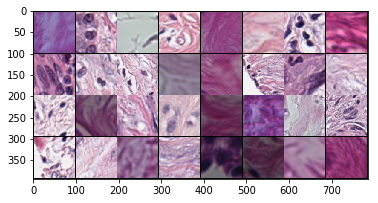

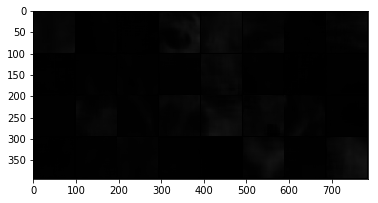

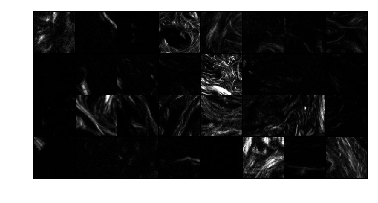

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


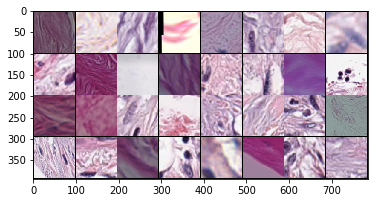

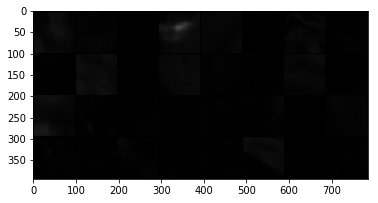

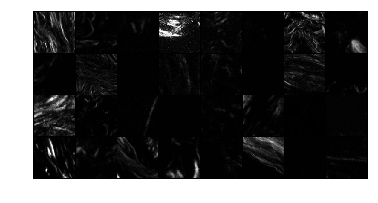

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


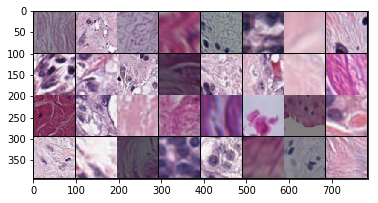

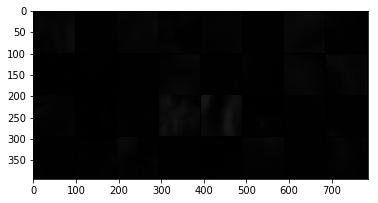

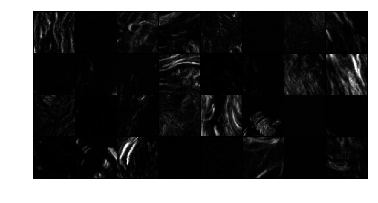

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


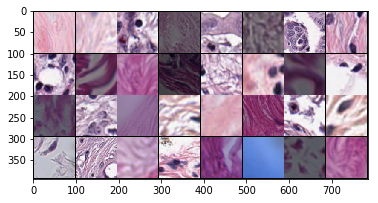

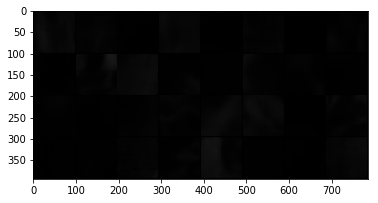

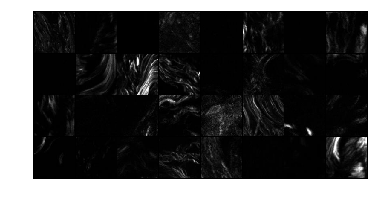

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


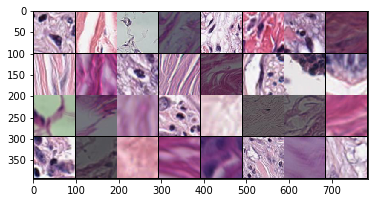

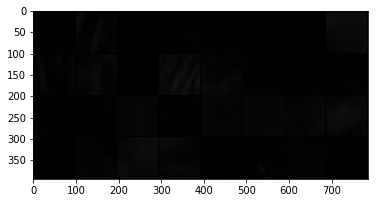

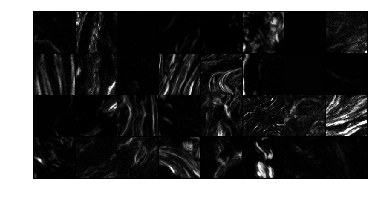

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


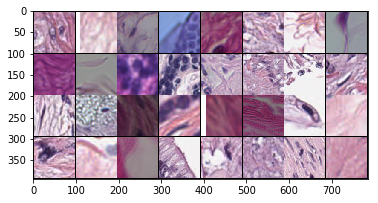

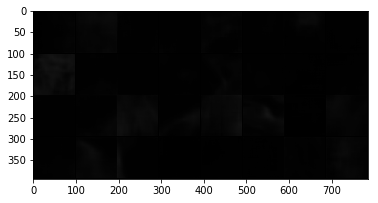

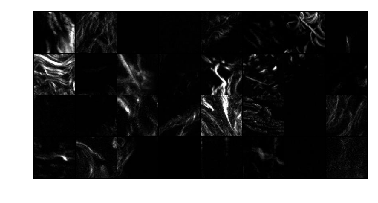

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


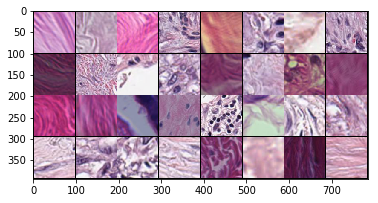

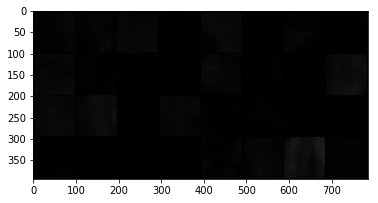

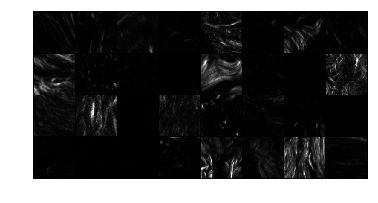

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


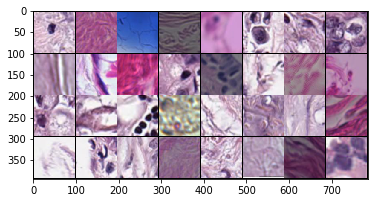

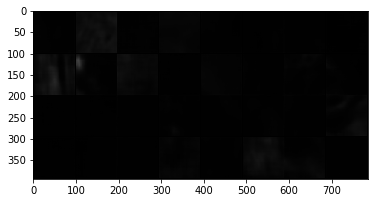

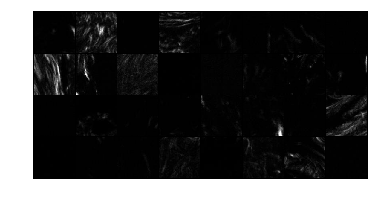

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


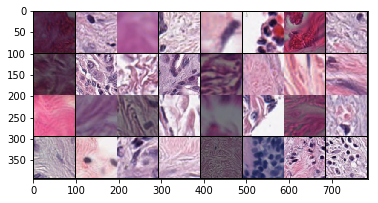

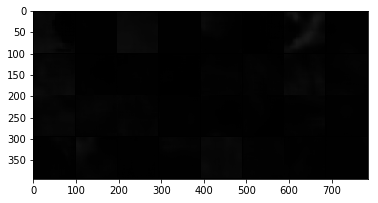

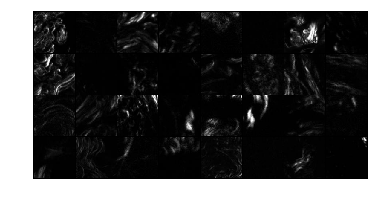

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


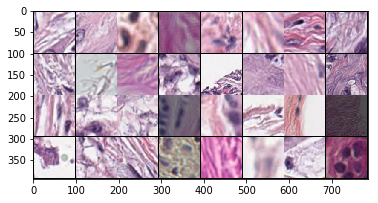

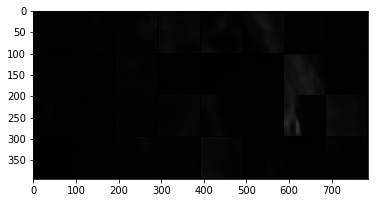

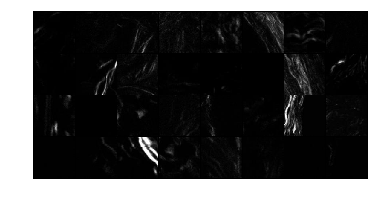

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


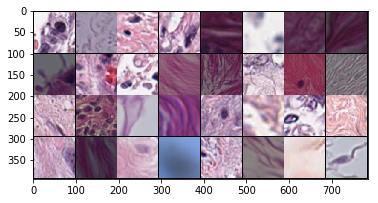

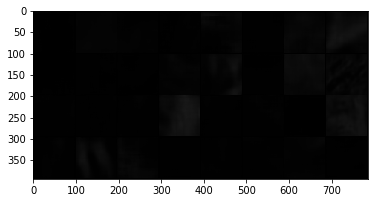

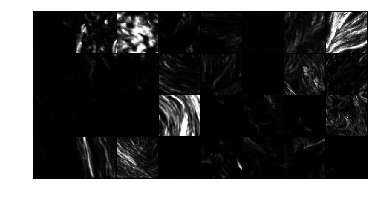

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


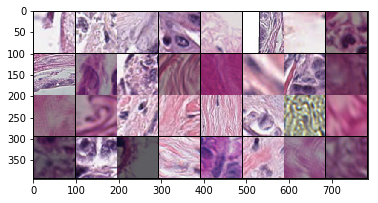

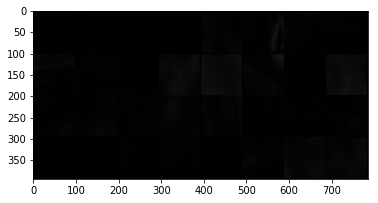

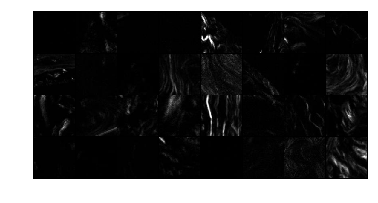

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


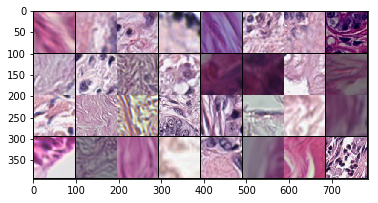

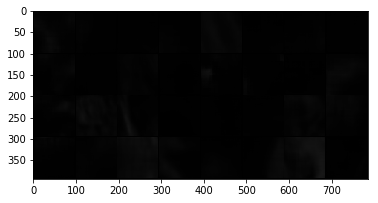

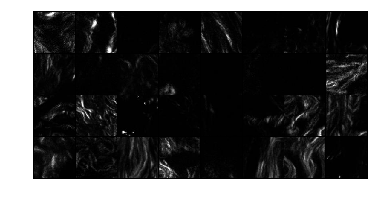

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


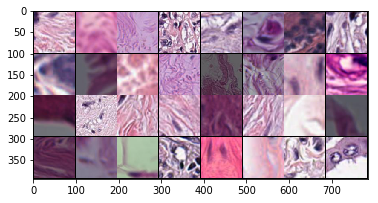

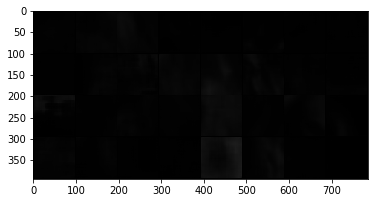

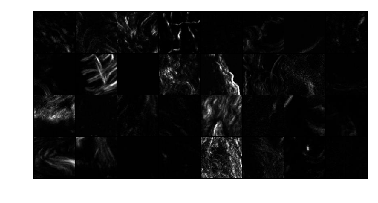

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


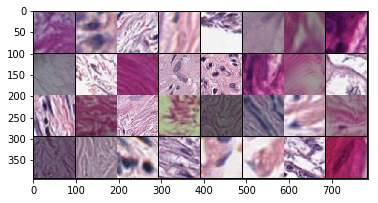

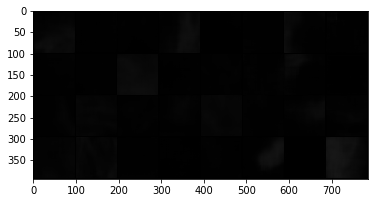

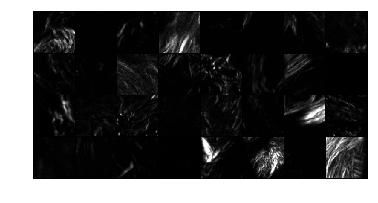

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


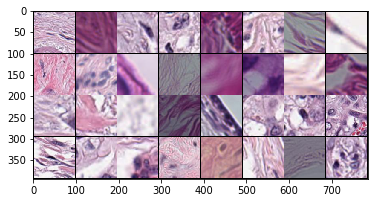

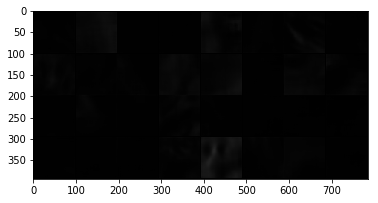

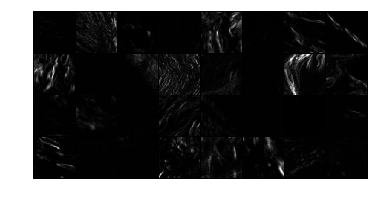

torch.Size([32, 1, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


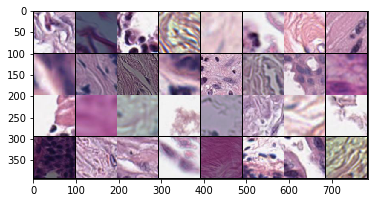

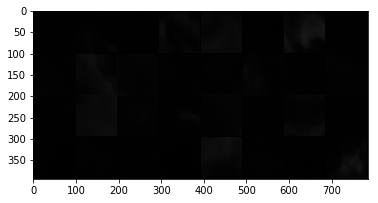

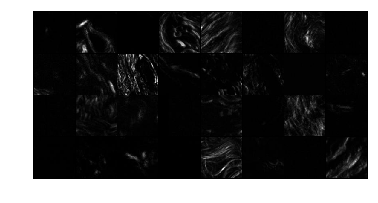

===> Avg. PSNR: nan dB


In [44]:
test()

In [46]:
import os
cwd = os.getcwd();
path = os.path.join(cwd, 'Saved model', 'encoderresinfo.pth')
torch.save(model.state_dict(), path)

In [48]:
l = 0.0001
p = 0
windowsize = 4
for epoch in range(1, 20 + 1):
    if epoch%5 == 0:
        windowsize = windowsize+1
        p = p*1
        l = l*0.2
        if windowsize == 0:
            windowsze = 1
    optimizer = optim.Adam(model.parameters(), lr=l)
        
    train(epoch, p, windowsize)

lossMSE: 0.006488034967333078 lossSSIM: 0.24839013814926147 lossL1: 0.02575402520596981
===> Epoch[1](0/25343): Loss: 0.2484
lossMSE: 0.00475524365901947 lossSSIM: 0.2181624174118042 lossL1: 0.020397797226905823
===> Epoch[1](50/25343): Loss: 0.2182
lossMSE: 0.005407797638326883 lossSSIM: 0.20804542303085327 lossL1: 0.021889541298151016
===> Epoch[1](100/25343): Loss: 0.2080
lossMSE: 0.011599608696997166 lossSSIM: 0.3082011938095093 lossL1: 0.038441505283117294
===> Epoch[1](150/25343): Loss: 0.3082
lossMSE: 0.007665978744626045 lossSSIM: 0.28864091634750366 lossL1: 0.031208058819174767
===> Epoch[1](200/25343): Loss: 0.2886
lossMSE: 0.008812407031655312 lossSSIM: 0.2503913640975952 lossL1: 0.03127649053931236
===> Epoch[1](250/25343): Loss: 0.2504
lossMSE: 0.0027581220492720604 lossSSIM: 0.2096760869026184 lossL1: 0.018576685339212418
===> Epoch[1](300/25343): Loss: 0.2097
lossMSE: 0.008248461410403252 lossSSIM: 0.26458263397216797 lossL1: 0.02952749840915203
===> Epoch[1](350/25343):

lossMSE: 0.00544686708599329 lossSSIM: 0.238583505153656 lossL1: 0.024975154548883438
===> Epoch[1](3250/25343): Loss: 0.2386
lossMSE: 0.00570768304169178 lossSSIM: 0.29959946870803833 lossL1: 0.02901449427008629
===> Epoch[1](3300/25343): Loss: 0.2996
lossMSE: 0.0025418726727366447 lossSSIM: 0.21669453382492065 lossL1: 0.017998652532696724
===> Epoch[1](3350/25343): Loss: 0.2167
lossMSE: 0.002853670157492161 lossSSIM: 0.17737311124801636 lossL1: 0.01463506929576397
===> Epoch[1](3400/25343): Loss: 0.1774
lossMSE: 0.008935166522860527 lossSSIM: 0.28720641136169434 lossL1: 0.035042040050029755
===> Epoch[1](3450/25343): Loss: 0.2872
lossMSE: 0.00871485099196434 lossSSIM: 0.25366902351379395 lossL1: 0.03217300400137901
===> Epoch[1](3500/25343): Loss: 0.2537
lossMSE: 0.015461210161447525 lossSSIM: 0.29689139127731323 lossL1: 0.041684314608573914
===> Epoch[1](3550/25343): Loss: 0.2969
lossMSE: 0.010123362764716148 lossSSIM: 0.2550046443939209 lossL1: 0.03405843302607536
===> Epoch[1](360

lossMSE: 0.002694115974009037 lossSSIM: 0.18675225973129272 lossL1: 0.01651311293244362
===> Epoch[1](6450/25343): Loss: 0.1868
lossMSE: 0.007350679021328688 lossSSIM: 0.23447299003601074 lossL1: 0.02733788825571537
===> Epoch[1](6500/25343): Loss: 0.2345
lossMSE: 0.004411125089973211 lossSSIM: 0.2562355399131775 lossL1: 0.02569558471441269
===> Epoch[1](6550/25343): Loss: 0.2562
lossMSE: 0.004713643342256546 lossSSIM: 0.2472628951072693 lossL1: 0.02408543974161148
===> Epoch[1](6600/25343): Loss: 0.2473
lossMSE: 0.01090533658862114 lossSSIM: 0.2847396731376648 lossL1: 0.0348341204226017
===> Epoch[1](6650/25343): Loss: 0.2847
lossMSE: 0.008912937715649605 lossSSIM: 0.23919695615768433 lossL1: 0.028628133237361908
===> Epoch[1](6700/25343): Loss: 0.2392
lossMSE: 0.006700144615024328 lossSSIM: 0.2352338433265686 lossL1: 0.02666494809091091
===> Epoch[1](6750/25343): Loss: 0.2352
lossMSE: 0.007916622795164585 lossSSIM: 0.2956467866897583 lossL1: 0.03169698268175125
===> Epoch[1](6800/253

lossMSE: 0.007145102601498365 lossSSIM: 0.21531158685684204 lossL1: 0.02520463615655899
===> Epoch[1](9650/25343): Loss: 0.2153
lossMSE: 0.005646383389830589 lossSSIM: 0.2137213945388794 lossL1: 0.02356587164103985
===> Epoch[1](9700/25343): Loss: 0.2137
lossMSE: 0.001538046752102673 lossSSIM: 0.16797327995300293 lossL1: 0.013287522830069065
===> Epoch[1](9750/25343): Loss: 0.1680
lossMSE: 0.005240203812718391 lossSSIM: 0.24256664514541626 lossL1: 0.022810421884059906
===> Epoch[1](9800/25343): Loss: 0.2426
lossMSE: 0.02222130447626114 lossSSIM: 0.3293663263320923 lossL1: 0.05390290915966034
===> Epoch[1](9850/25343): Loss: 0.3294
lossMSE: 0.004191602114588022 lossSSIM: 0.23625105619430542 lossL1: 0.022856906056404114
===> Epoch[1](9900/25343): Loss: 0.2363
lossMSE: 0.007130164187401533 lossSSIM: 0.21430397033691406 lossL1: 0.025247221812605858
===> Epoch[1](9950/25343): Loss: 0.2143
lossMSE: 0.004178228322416544 lossSSIM: 0.23413348197937012 lossL1: 0.02229628711938858
===> Epoch[1](1

lossMSE: 0.002516495995223522 lossSSIM: 0.19779574871063232 lossL1: 0.017170770093798637
===> Epoch[1](12850/25343): Loss: 0.1978
lossMSE: 0.00830848328769207 lossSSIM: 0.28977692127227783 lossL1: 0.03334039822220802
===> Epoch[1](12900/25343): Loss: 0.2898
lossMSE: 0.005419572815299034 lossSSIM: 0.22624635696411133 lossL1: 0.022604666650295258
===> Epoch[1](12950/25343): Loss: 0.2262
lossMSE: 0.005022627767175436 lossSSIM: 0.22969895601272583 lossL1: 0.023623671382665634
===> Epoch[1](13000/25343): Loss: 0.2297
lossMSE: 0.0038104099221527576 lossSSIM: 0.2056593894958496 lossL1: 0.01870931126177311
===> Epoch[1](13050/25343): Loss: 0.2057
lossMSE: 0.005745100788772106 lossSSIM: 0.23625260591506958 lossL1: 0.024520713835954666
===> Epoch[1](13100/25343): Loss: 0.2363
lossMSE: 0.014950254000723362 lossSSIM: 0.3213779330253601 lossL1: 0.044719722121953964
===> Epoch[1](13150/25343): Loss: 0.3214
lossMSE: 0.0066570318304002285 lossSSIM: 0.24445974826812744 lossL1: 0.02719126082956791
===> 

lossMSE: 0.0047820573672652245 lossSSIM: 0.24302548170089722 lossL1: 0.023536711931228638
===> Epoch[1](16050/25343): Loss: 0.2430
lossMSE: 0.007037025410681963 lossSSIM: 0.28008943796157837 lossL1: 0.029970215633511543
===> Epoch[1](16100/25343): Loss: 0.2801
lossMSE: 0.006406450644135475 lossSSIM: 0.22283053398132324 lossL1: 0.023507706820964813
===> Epoch[1](16150/25343): Loss: 0.2228
lossMSE: 0.0043088523671031 lossSSIM: 0.25561028718948364 lossL1: 0.024351000785827637
===> Epoch[1](16200/25343): Loss: 0.2556
lossMSE: 0.007372932508587837 lossSSIM: 0.26442021131515503 lossL1: 0.027982957661151886
===> Epoch[1](16250/25343): Loss: 0.2644
lossMSE: 0.005717359017580748 lossSSIM: 0.2777271866798401 lossL1: 0.027717087417840958
===> Epoch[1](16300/25343): Loss: 0.2777
lossMSE: 0.005422885064035654 lossSSIM: 0.2499598264694214 lossL1: 0.025677714496850967
===> Epoch[1](16350/25343): Loss: 0.2500
lossMSE: 0.0027305171824991703 lossSSIM: 0.19940489530563354 lossL1: 0.016949238255620003
===

lossMSE: 0.005485210567712784 lossSSIM: 0.27153754234313965 lossL1: 0.027682432904839516
===> Epoch[1](19250/25343): Loss: 0.2715
lossMSE: 0.012486009858548641 lossSSIM: 0.2671782374382019 lossL1: 0.03559417277574539
===> Epoch[1](19300/25343): Loss: 0.2672
lossMSE: 0.00513779791072011 lossSSIM: 0.25816410779953003 lossL1: 0.025134693831205368
===> Epoch[1](19350/25343): Loss: 0.2582
lossMSE: 0.002887409646064043 lossSSIM: 0.20624607801437378 lossL1: 0.01706612855195999
===> Epoch[1](19400/25343): Loss: 0.2062
lossMSE: 0.0026100766845047474 lossSSIM: 0.17201191186904907 lossL1: 0.014286760240793228
===> Epoch[1](19450/25343): Loss: 0.1720
lossMSE: 0.0025694849900901318 lossSSIM: 0.21388208866119385 lossL1: 0.01815679483115673
===> Epoch[1](19500/25343): Loss: 0.2139
lossMSE: 0.00938672199845314 lossSSIM: 0.28068435192108154 lossL1: 0.033566199243068695
===> Epoch[1](19550/25343): Loss: 0.2807
lossMSE: 0.0035867111291736364 lossSSIM: 0.20724081993103027 lossL1: 0.018969854339957237
===>

lossMSE: 0.005109706893563271 lossSSIM: 0.2574276924133301 lossL1: 0.026160435751080513
===> Epoch[1](22450/25343): Loss: 0.2574
lossMSE: 0.006418109871447086 lossSSIM: 0.20662689208984375 lossL1: 0.023964254185557365
===> Epoch[1](22500/25343): Loss: 0.2066
lossMSE: 0.010662333108484745 lossSSIM: 0.27686065435409546 lossL1: 0.03461660444736481
===> Epoch[1](22550/25343): Loss: 0.2769
lossMSE: 0.011080915108323097 lossSSIM: 0.2860656976699829 lossL1: 0.035218462347984314
===> Epoch[1](22600/25343): Loss: 0.2861
lossMSE: 0.0032930823508650064 lossSSIM: 0.18846243619918823 lossL1: 0.015585296787321568
===> Epoch[1](22650/25343): Loss: 0.1885
lossMSE: 0.010752145200967789 lossSSIM: 0.2697153687477112 lossL1: 0.032662417739629745
===> Epoch[1](22700/25343): Loss: 0.2697
lossMSE: 0.006155550479888916 lossSSIM: 0.2706374526023865 lossL1: 0.027290932834148407
===> Epoch[1](22750/25343): Loss: 0.2706
lossMSE: 0.009347363375127316 lossSSIM: 0.30748802423477173 lossL1: 0.037469930946826935
===> 

lossMSE: 0.005747606977820396 lossSSIM: 0.2743217349052429 lossL1: 0.028103573247790337
===> Epoch[2](300/25343): Loss: 0.2743
lossMSE: 0.006897902116179466 lossSSIM: 0.2771010398864746 lossL1: 0.029569651931524277
===> Epoch[2](350/25343): Loss: 0.2771
lossMSE: 0.004526922013610601 lossSSIM: 0.1924799084663391 lossL1: 0.01955239288508892
===> Epoch[2](400/25343): Loss: 0.1925
lossMSE: 0.007256914395838976 lossSSIM: 0.22657597064971924 lossL1: 0.026205768808722496
===> Epoch[2](450/25343): Loss: 0.2266
lossMSE: 0.004197402857244015 lossSSIM: 0.2532602548599243 lossL1: 0.024075008928775787
===> Epoch[2](500/25343): Loss: 0.2533
lossMSE: 0.0033466017339378595 lossSSIM: 0.21603673696517944 lossL1: 0.019659515470266342
===> Epoch[2](550/25343): Loss: 0.2160
lossMSE: 0.005308876279741526 lossSSIM: 0.2179703712463379 lossL1: 0.02271835319697857
===> Epoch[2](600/25343): Loss: 0.2180
lossMSE: 0.0030114827677607536 lossSSIM: 0.20372939109802246 lossL1: 0.01725827343761921
===> Epoch[2](650/253

lossMSE: 0.006765863858163357 lossSSIM: 0.23208701610565186 lossL1: 0.025979377329349518
===> Epoch[2](3550/25343): Loss: 0.2321
lossMSE: 0.005953708663582802 lossSSIM: 0.2762530446052551 lossL1: 0.028253456577658653
===> Epoch[2](3600/25343): Loss: 0.2763
lossMSE: 0.004733038134872913 lossSSIM: 0.2569326162338257 lossL1: 0.025794722139835358
===> Epoch[2](3650/25343): Loss: 0.2569
lossMSE: 0.0029563114512711763 lossSSIM: 0.24172210693359375 lossL1: 0.02066781185567379
===> Epoch[2](3700/25343): Loss: 0.2417
lossMSE: 0.012604677118360996 lossSSIM: 0.31023991107940674 lossL1: 0.03895258158445358
===> Epoch[2](3750/25343): Loss: 0.3102
lossMSE: 0.01302940770983696 lossSSIM: 0.3028167486190796 lossL1: 0.03791089355945587
===> Epoch[2](3800/25343): Loss: 0.3028
lossMSE: 0.010447503067553043 lossSSIM: 0.3179991841316223 lossL1: 0.038286492228507996
===> Epoch[2](3850/25343): Loss: 0.3180
lossMSE: 0.006386168301105499 lossSSIM: 0.23582404851913452 lossL1: 0.02553142048418522
===> Epoch[2](39

lossMSE: 0.011720534414052963 lossSSIM: 0.27243781089782715 lossL1: 0.03684847429394722
===> Epoch[2](6750/25343): Loss: 0.2724
lossMSE: 0.007162605877965689 lossSSIM: 0.2577288746833801 lossL1: 0.027831805869936943
===> Epoch[2](6800/25343): Loss: 0.2577
lossMSE: 0.0016192367766052485 lossSSIM: 0.1978074312210083 lossL1: 0.015423602424561977
===> Epoch[2](6850/25343): Loss: 0.1978
lossMSE: 0.0048082973808050156 lossSSIM: 0.2141895294189453 lossL1: 0.021614572033286095
===> Epoch[2](6900/25343): Loss: 0.2142
lossMSE: 0.006157668307423592 lossSSIM: 0.2782335877418518 lossL1: 0.029621263965964317
===> Epoch[2](6950/25343): Loss: 0.2782
lossMSE: 0.004650197457522154 lossSSIM: 0.2426735758781433 lossL1: 0.02194523811340332
===> Epoch[2](7000/25343): Loss: 0.2427
lossMSE: 0.009065285325050354 lossSSIM: 0.26215505599975586 lossL1: 0.030471669510006905
===> Epoch[2](7050/25343): Loss: 0.2622
lossMSE: 0.004350668750703335 lossSSIM: 0.23462003469467163 lossL1: 0.023262789472937584
===> Epoch[2]

lossMSE: 0.008790246210992336 lossSSIM: 0.25288814306259155 lossL1: 0.028840111568570137
===> Epoch[2](9950/25343): Loss: 0.2529
lossMSE: 0.006850268226116896 lossSSIM: 0.2574297785758972 lossL1: 0.02739514410495758
===> Epoch[2](10000/25343): Loss: 0.2574
lossMSE: 0.007271638140082359 lossSSIM: 0.2345561981201172 lossL1: 0.02494257315993309
===> Epoch[2](10050/25343): Loss: 0.2346
lossMSE: 0.004070409573614597 lossSSIM: 0.2194422483444214 lossL1: 0.021250717341899872
===> Epoch[2](10100/25343): Loss: 0.2194
lossMSE: 0.0026132683269679546 lossSSIM: 0.23710966110229492 lossL1: 0.019022632390260696
===> Epoch[2](10150/25343): Loss: 0.2371
lossMSE: 0.0060637095011770725 lossSSIM: 0.32082420587539673 lossL1: 0.032716259360313416
===> Epoch[2](10200/25343): Loss: 0.3208
lossMSE: 0.008417371660470963 lossSSIM: 0.27997666597366333 lossL1: 0.032124534249305725
===> Epoch[2](10250/25343): Loss: 0.2800
lossMSE: 0.008973426185548306 lossSSIM: 0.3230915069580078 lossL1: 0.03781495988368988
===> Ep

lossMSE: 0.004812524653971195 lossSSIM: 0.22218406200408936 lossL1: 0.022773660719394684
===> Epoch[2](13150/25343): Loss: 0.2222
lossMSE: 0.0040156785398721695 lossSSIM: 0.2393527626991272 lossL1: 0.021776149049401283
===> Epoch[2](13200/25343): Loss: 0.2394
lossMSE: 0.00663517601788044 lossSSIM: 0.2897643446922302 lossL1: 0.03217752277851105
===> Epoch[2](13250/25343): Loss: 0.2898
lossMSE: 0.004800216294825077 lossSSIM: 0.2653522491455078 lossL1: 0.02564575895667076
===> Epoch[2](13300/25343): Loss: 0.2654
lossMSE: 0.0030536961276084185 lossSSIM: 0.2459017038345337 lossL1: 0.020579718053340912
===> Epoch[2](13350/25343): Loss: 0.2459
lossMSE: 0.00453557725995779 lossSSIM: 0.2736351490020752 lossL1: 0.025274204090237617
===> Epoch[2](13400/25343): Loss: 0.2736
lossMSE: 0.011904174461960793 lossSSIM: 0.25296878814697266 lossL1: 0.03242116421461105
===> Epoch[2](13450/25343): Loss: 0.2530
lossMSE: 0.006672981660813093 lossSSIM: 0.255845308303833 lossL1: 0.027296505868434906
===> Epoch[

lossMSE: 0.0034220917150378227 lossSSIM: 0.1782737374305725 lossL1: 0.01681107096374035
===> Epoch[2](16350/25343): Loss: 0.1783
lossMSE: 0.005576259922236204 lossSSIM: 0.21828699111938477 lossL1: 0.023802747949957848
===> Epoch[2](16400/25343): Loss: 0.2183
lossMSE: 0.00459331925958395 lossSSIM: 0.23262977600097656 lossL1: 0.021446026861667633
===> Epoch[2](16450/25343): Loss: 0.2326
lossMSE: 0.007972081191837788 lossSSIM: 0.28212159872055054 lossL1: 0.03273804113268852
===> Epoch[2](16500/25343): Loss: 0.2821
lossMSE: 0.006523335352540016 lossSSIM: 0.21101081371307373 lossL1: 0.023084189742803574
===> Epoch[2](16550/25343): Loss: 0.2110
lossMSE: 0.005697045940905809 lossSSIM: 0.268924355506897 lossL1: 0.027270296588540077
===> Epoch[2](16600/25343): Loss: 0.2689
lossMSE: 0.004198733251541853 lossSSIM: 0.23704028129577637 lossL1: 0.022703679278492928
===> Epoch[2](16650/25343): Loss: 0.2370
lossMSE: 0.00680035213008523 lossSSIM: 0.21417135000228882 lossL1: 0.024400250986218452
===> Ep

lossMSE: 0.013125550001859665 lossSSIM: 0.26154083013534546 lossL1: 0.0360134057700634
===> Epoch[2](19550/25343): Loss: 0.2615
lossMSE: 0.00923869013786316 lossSSIM: 0.24350208044052124 lossL1: 0.02870917320251465
===> Epoch[2](19600/25343): Loss: 0.2435
lossMSE: 0.005212233401834965 lossSSIM: 0.28304523229599 lossL1: 0.0289969053119421
===> Epoch[2](19650/25343): Loss: 0.2830
lossMSE: 0.004678284749388695 lossSSIM: 0.21930116415023804 lossL1: 0.023099644109606743
===> Epoch[2](19700/25343): Loss: 0.2193
lossMSE: 0.0040978798642754555 lossSSIM: 0.22373098134994507 lossL1: 0.0214694757014513
===> Epoch[2](19750/25343): Loss: 0.2237
lossMSE: 0.007724811788648367 lossSSIM: 0.28334474563598633 lossL1: 0.030043257400393486
===> Epoch[2](19800/25343): Loss: 0.2833
lossMSE: 0.0062768287025392056 lossSSIM: 0.21669775247573853 lossL1: 0.023357344791293144
===> Epoch[2](19850/25343): Loss: 0.2167
lossMSE: 0.005711456295102835 lossSSIM: 0.2454615831375122 lossL1: 0.024913903325796127
===> Epoch[

lossMSE: 0.004587734118103981 lossSSIM: 0.23557424545288086 lossL1: 0.023533718660473824
===> Epoch[2](22750/25343): Loss: 0.2356
lossMSE: 0.002580172847956419 lossSSIM: 0.21708369255065918 lossL1: 0.018264293670654297
===> Epoch[2](22800/25343): Loss: 0.2171
lossMSE: 0.0022102470975369215 lossSSIM: 0.22281140089035034 lossL1: 0.01692044734954834
===> Epoch[2](22850/25343): Loss: 0.2228
lossMSE: 0.005050892475992441 lossSSIM: 0.21952807903289795 lossL1: 0.020567450672388077
===> Epoch[2](22900/25343): Loss: 0.2195
lossMSE: 0.016598965972661972 lossSSIM: 0.29896116256713867 lossL1: 0.04448593407869339
===> Epoch[2](22950/25343): Loss: 0.2990
lossMSE: 0.005958124995231628 lossSSIM: 0.24160611629486084 lossL1: 0.025476019829511642
===> Epoch[2](23000/25343): Loss: 0.2416
lossMSE: 0.014484680257737637 lossSSIM: 0.25425511598587036 lossL1: 0.03615123778581619
===> Epoch[2](23050/25343): Loss: 0.2543
lossMSE: 0.0034667188301682472 lossSSIM: 0.2272370457649231 lossL1: 0.02021109312772751
===>

lossMSE: 0.005365968681871891 lossSSIM: 0.25106602907180786 lossL1: 0.025912735611200333
===> Epoch[3](600/25343): Loss: 0.2511
lossMSE: 0.004480043891817331 lossSSIM: 0.24504798650741577 lossL1: 0.023056939244270325
===> Epoch[3](650/25343): Loss: 0.2450
lossMSE: 0.013013695366680622 lossSSIM: 0.24282872676849365 lossL1: 0.03250695765018463
===> Epoch[3](700/25343): Loss: 0.2428
lossMSE: 0.004875103943049908 lossSSIM: 0.23884034156799316 lossL1: 0.024512648582458496
===> Epoch[3](750/25343): Loss: 0.2388
lossMSE: 0.004778025671839714 lossSSIM: 0.23422330617904663 lossL1: 0.022973038256168365
===> Epoch[3](800/25343): Loss: 0.2342
lossMSE: 0.018015597015619278 lossSSIM: 0.334339439868927 lossL1: 0.04849819466471672
===> Epoch[3](850/25343): Loss: 0.3343
lossMSE: 0.007309512235224247 lossSSIM: 0.2612569332122803 lossL1: 0.03071359172463417
===> Epoch[3](900/25343): Loss: 0.2613
lossMSE: 0.004832467995584011 lossSSIM: 0.251836895942688 lossL1: 0.02563130483031273
===> Epoch[3](950/25343)

lossMSE: 0.005025735590606928 lossSSIM: 0.2586749196052551 lossL1: 0.024280879646539688
===> Epoch[3](3850/25343): Loss: 0.2587
lossMSE: 0.0040048654191195965 lossSSIM: 0.22054201364517212 lossL1: 0.018554653972387314
===> Epoch[3](3900/25343): Loss: 0.2205
lossMSE: 0.0030213426798582077 lossSSIM: 0.23332864046096802 lossL1: 0.01943853683769703
===> Epoch[3](3950/25343): Loss: 0.2333
lossMSE: 0.00336372759193182 lossSSIM: 0.21745461225509644 lossL1: 0.020069947466254234
===> Epoch[3](4000/25343): Loss: 0.2175
lossMSE: 0.005289074033498764 lossSSIM: 0.20800769329071045 lossL1: 0.022623354569077492
===> Epoch[3](4050/25343): Loss: 0.2080
lossMSE: 0.007976795546710491 lossSSIM: 0.20685160160064697 lossL1: 0.02587422914803028
===> Epoch[3](4100/25343): Loss: 0.2069
lossMSE: 0.006203763652592897 lossSSIM: 0.24341177940368652 lossL1: 0.02634998969733715
===> Epoch[3](4150/25343): Loss: 0.2434
lossMSE: 0.004202067852020264 lossSSIM: 0.22707748413085938 lossL1: 0.022885087877511978
===> Epoch[

lossMSE: 0.006136071402579546 lossSSIM: 0.22810471057891846 lossL1: 0.02388046495616436
===> Epoch[3](7050/25343): Loss: 0.2281
lossMSE: 0.01640133373439312 lossSSIM: 0.2565935254096985 lossL1: 0.04006871208548546
===> Epoch[3](7100/25343): Loss: 0.2566
lossMSE: 0.005511543247848749 lossSSIM: 0.2899392247200012 lossL1: 0.027942605316638947
===> Epoch[3](7150/25343): Loss: 0.2899
lossMSE: 0.0034871213138103485 lossSSIM: 0.19950884580612183 lossL1: 0.016710378229618073
===> Epoch[3](7200/25343): Loss: 0.1995
lossMSE: 0.010550680570304394 lossSSIM: 0.2943565249443054 lossL1: 0.036423392593860626
===> Epoch[3](7250/25343): Loss: 0.2944
lossMSE: 0.005829725880175829 lossSSIM: 0.22802937030792236 lossL1: 0.023188143968582153
===> Epoch[3](7300/25343): Loss: 0.2280
lossMSE: 0.004676906391978264 lossSSIM: 0.19130080938339233 lossL1: 0.019413556903600693
===> Epoch[3](7350/25343): Loss: 0.1913
lossMSE: 0.0077836234122514725 lossSSIM: 0.26247215270996094 lossL1: 0.030824873596429825
===> Epoch[3

lossMSE: 0.002493140986189246 lossSSIM: 0.19721126556396484 lossL1: 0.016827590763568878
===> Epoch[3](10250/25343): Loss: 0.1972
lossMSE: 0.00934648048132658 lossSSIM: 0.24070996046066284 lossL1: 0.02810085564851761
===> Epoch[3](10300/25343): Loss: 0.2407
lossMSE: 0.006073376163840294 lossSSIM: 0.2681499123573303 lossL1: 0.027618374675512314
===> Epoch[3](10350/25343): Loss: 0.2681
lossMSE: 0.005674854852259159 lossSSIM: 0.24929344654083252 lossL1: 0.02598387748003006
===> Epoch[3](10400/25343): Loss: 0.2493
lossMSE: 0.006855976302176714 lossSSIM: 0.22245246171951294 lossL1: 0.024158570915460587
===> Epoch[3](10450/25343): Loss: 0.2225
lossMSE: 0.00825311429798603 lossSSIM: 0.24062132835388184 lossL1: 0.026653174310922623
===> Epoch[3](10500/25343): Loss: 0.2406
lossMSE: 0.0024098260328173637 lossSSIM: 0.17281794548034668 lossL1: 0.015056699514389038
===> Epoch[3](10550/25343): Loss: 0.1728
lossMSE: 0.01302577555179596 lossSSIM: 0.25366997718811035 lossL1: 0.0339098758995533
===> Epo

lossMSE: 0.004419740289449692 lossSSIM: 0.2078576683998108 lossL1: 0.02211078815162182
===> Epoch[3](13450/25343): Loss: 0.2079
lossMSE: 0.014691142365336418 lossSSIM: 0.24652081727981567 lossL1: 0.03752492740750313
===> Epoch[3](13500/25343): Loss: 0.2465
lossMSE: 0.004332683049142361 lossSSIM: 0.2421945333480835 lossL1: 0.02174483984708786
===> Epoch[3](13550/25343): Loss: 0.2422
lossMSE: 0.007035661023110151 lossSSIM: 0.2591620683670044 lossL1: 0.030032234266400337
===> Epoch[3](13600/25343): Loss: 0.2592
lossMSE: 0.007386708632111549 lossSSIM: 0.27072733640670776 lossL1: 0.029758267104625702
===> Epoch[3](13650/25343): Loss: 0.2707
lossMSE: 0.00415551383048296 lossSSIM: 0.24431216716766357 lossL1: 0.022893359884619713
===> Epoch[3](13700/25343): Loss: 0.2443
lossMSE: 0.0028333328664302826 lossSSIM: 0.24783575534820557 lossL1: 0.021439122036099434
===> Epoch[3](13750/25343): Loss: 0.2478
lossMSE: 0.006920313462615013 lossSSIM: 0.27010053396224976 lossL1: 0.028273962438106537
===> Ep

lossMSE: 0.0024230596609413624 lossSSIM: 0.18999862670898438 lossL1: 0.015639901161193848
===> Epoch[3](16650/25343): Loss: 0.1900
lossMSE: 0.008200626820325851 lossSSIM: 0.2205788493156433 lossL1: 0.0266115702688694
===> Epoch[3](16700/25343): Loss: 0.2206
lossMSE: 0.006475894246250391 lossSSIM: 0.23025041818618774 lossL1: 0.024772096425294876
===> Epoch[3](16750/25343): Loss: 0.2303
lossMSE: 0.0029846196994185448 lossSSIM: 0.21841424703598022 lossL1: 0.02028806321322918
===> Epoch[3](16800/25343): Loss: 0.2184
lossMSE: 0.012575570493936539 lossSSIM: 0.25133228302001953 lossL1: 0.03682311996817589
===> Epoch[3](16850/25343): Loss: 0.2513
lossMSE: 0.007347111124545336 lossSSIM: 0.28082454204559326 lossL1: 0.03002934716641903
===> Epoch[3](16900/25343): Loss: 0.2808
lossMSE: 0.002219412475824356 lossSSIM: 0.22402215003967285 lossL1: 0.01704256422817707
===> Epoch[3](16950/25343): Loss: 0.2240
lossMSE: 0.008465616963803768 lossSSIM: 0.27638155221939087 lossL1: 0.03276072070002556
===> Ep

lossMSE: 0.007577282842248678 lossSSIM: 0.2648298144340515 lossL1: 0.029296420514583588
===> Epoch[3](19850/25343): Loss: 0.2648
lossMSE: 0.005382341332733631 lossSSIM: 0.20969170331954956 lossL1: 0.020979998633265495
===> Epoch[3](19900/25343): Loss: 0.2097
lossMSE: 0.001992079894989729 lossSSIM: 0.19516855478286743 lossL1: 0.014988790266215801
===> Epoch[3](19950/25343): Loss: 0.1952
lossMSE: 0.006204240024089813 lossSSIM: 0.28262847661972046 lossL1: 0.029231898486614227
===> Epoch[3](20000/25343): Loss: 0.2826
lossMSE: 0.0064992886036634445 lossSSIM: 0.2467067837715149 lossL1: 0.026216762140393257
===> Epoch[3](20050/25343): Loss: 0.2467
lossMSE: 0.004892321769148111 lossSSIM: 0.2579684257507324 lossL1: 0.024446360766887665
===> Epoch[3](20100/25343): Loss: 0.2580
lossMSE: 0.010980064049363136 lossSSIM: 0.23760324716567993 lossL1: 0.0316990464925766
===> Epoch[3](20150/25343): Loss: 0.2376
lossMSE: 0.01103563979268074 lossSSIM: 0.2574436664581299 lossL1: 0.032391972839832306
===> Ep

lossMSE: 0.003647052915766835 lossSSIM: 0.23126059770584106 lossL1: 0.019480612128973007
===> Epoch[3](23050/25343): Loss: 0.2313
lossMSE: 0.006044622976332903 lossSSIM: 0.22920066118240356 lossL1: 0.024725738912820816
===> Epoch[3](23100/25343): Loss: 0.2292
lossMSE: 0.00891178473830223 lossSSIM: 0.2630312442779541 lossL1: 0.03309283405542374
===> Epoch[3](23150/25343): Loss: 0.2630
lossMSE: 0.004132261034101248 lossSSIM: 0.2532764673233032 lossL1: 0.02353314310312271
===> Epoch[3](23200/25343): Loss: 0.2533
lossMSE: 0.004044646397233009 lossSSIM: 0.24213790893554688 lossL1: 0.021952565759420395
===> Epoch[3](23250/25343): Loss: 0.2421
lossMSE: 0.002701031044125557 lossSSIM: 0.22966384887695312 lossL1: 0.018122665584087372
===> Epoch[3](23300/25343): Loss: 0.2297
lossMSE: 0.01161658950150013 lossSSIM: 0.26991087198257446 lossL1: 0.03566071763634682
===> Epoch[3](23350/25343): Loss: 0.2699
lossMSE: 0.007311610504984856 lossSSIM: 0.2441939115524292 lossL1: 0.028371496126055717
===> Epoc

lossMSE: 0.008206918835639954 lossSSIM: 0.24519014358520508 lossL1: 0.02984747663140297
===> Epoch[4](900/25343): Loss: 0.2452
lossMSE: 0.002569390693679452 lossSSIM: 0.2363128662109375 lossL1: 0.02001388743519783
===> Epoch[4](950/25343): Loss: 0.2363
lossMSE: 0.004105299711227417 lossSSIM: 0.2198622226715088 lossL1: 0.021110232919454575
===> Epoch[4](1000/25343): Loss: 0.2199
lossMSE: 0.004243950359523296 lossSSIM: 0.20015627145767212 lossL1: 0.019042059779167175
===> Epoch[4](1050/25343): Loss: 0.2002
lossMSE: 0.0046737417578697205 lossSSIM: 0.26108241081237793 lossL1: 0.0252235010266304
===> Epoch[4](1100/25343): Loss: 0.2611
lossMSE: 0.007569414097815752 lossSSIM: 0.24154239892959595 lossL1: 0.02723018266260624
===> Epoch[4](1150/25343): Loss: 0.2415
lossMSE: 0.0049653733149170876 lossSSIM: 0.21586686372756958 lossL1: 0.021072570234537125
===> Epoch[4](1200/25343): Loss: 0.2159
lossMSE: 0.0036160829477012157 lossSSIM: 0.19641023874282837 lossL1: 0.017017118632793427
===> Epoch[4](

lossMSE: 0.007120306137949228 lossSSIM: 0.2575837969779968 lossL1: 0.027307387441396713
===> Epoch[4](4150/25343): Loss: 0.2576
lossMSE: 0.006681263912469149 lossSSIM: 0.2460898756980896 lossL1: 0.0282564889639616
===> Epoch[4](4200/25343): Loss: 0.2461
lossMSE: 0.006584893446415663 lossSSIM: 0.28640109300613403 lossL1: 0.02995569258928299
===> Epoch[4](4250/25343): Loss: 0.2864
lossMSE: 0.0030579152517020702 lossSSIM: 0.1967567801475525 lossL1: 0.01742292381823063
===> Epoch[4](4300/25343): Loss: 0.1968
lossMSE: 0.003682821523398161 lossSSIM: 0.2453317642211914 lossL1: 0.022823169827461243
===> Epoch[4](4350/25343): Loss: 0.2453
lossMSE: 0.007311294320970774 lossSSIM: 0.26056843996047974 lossL1: 0.02873115800321102
===> Epoch[4](4400/25343): Loss: 0.2606
lossMSE: 0.004058423917740583 lossSSIM: 0.20222514867782593 lossL1: 0.019705098122358322
===> Epoch[4](4450/25343): Loss: 0.2022
lossMSE: 0.009451348334550858 lossSSIM: 0.25704920291900635 lossL1: 0.031385865062475204
===> Epoch[4](45

lossMSE: 0.004427196923643351 lossSSIM: 0.23238521814346313 lossL1: 0.023414257913827896
===> Epoch[4](7350/25343): Loss: 0.2324
lossMSE: 0.011984114535152912 lossSSIM: 0.25232189893722534 lossL1: 0.033610180020332336
===> Epoch[4](7400/25343): Loss: 0.2523
lossMSE: 0.002644938649609685 lossSSIM: 0.19479018449783325 lossL1: 0.017122022807598114
===> Epoch[4](7450/25343): Loss: 0.1948
lossMSE: 0.005116267129778862 lossSSIM: 0.21674543619155884 lossL1: 0.021449357271194458
===> Epoch[4](7500/25343): Loss: 0.2167
lossMSE: 0.002234996762126684 lossSSIM: 0.21736359596252441 lossL1: 0.01789672113955021
===> Epoch[4](7550/25343): Loss: 0.2174
lossMSE: 0.006511824205517769 lossSSIM: 0.20572209358215332 lossL1: 0.023143792524933815
===> Epoch[4](7600/25343): Loss: 0.2057
lossMSE: 0.0062698740512132645 lossSSIM: 0.25399500131607056 lossL1: 0.026367342099547386
===> Epoch[4](7650/25343): Loss: 0.2540
lossMSE: 0.006093502044677734 lossSSIM: 0.26315927505493164 lossL1: 0.027755791321396828
===> Epo

lossMSE: 0.005601947661489248 lossSSIM: 0.2320879101753235 lossL1: 0.02465226501226425
===> Epoch[4](10550/25343): Loss: 0.2321
lossMSE: 0.010168002918362617 lossSSIM: 0.2507924437522888 lossL1: 0.03302493318915367
===> Epoch[4](10600/25343): Loss: 0.2508
lossMSE: 0.011328437365591526 lossSSIM: 0.2863246202468872 lossL1: 0.036443691700696945
===> Epoch[4](10650/25343): Loss: 0.2863
lossMSE: 0.004319740459322929 lossSSIM: 0.2508678436279297 lossL1: 0.022782938554883003
===> Epoch[4](10700/25343): Loss: 0.2509
lossMSE: 0.00410245917737484 lossSSIM: 0.21031200885772705 lossL1: 0.020345374941825867
===> Epoch[4](10750/25343): Loss: 0.2103
lossMSE: 0.00964288879185915 lossSSIM: 0.2997611165046692 lossL1: 0.03514200076460838
===> Epoch[4](10800/25343): Loss: 0.2998
lossMSE: 0.004504968877881765 lossSSIM: 0.26384681463241577 lossL1: 0.02508932538330555
===> Epoch[4](10850/25343): Loss: 0.2638
lossMSE: 0.003492949763312936 lossSSIM: 0.20412397384643555 lossL1: 0.019256165251135826
===> Epoch[4

lossMSE: 0.006172130350023508 lossSSIM: 0.25380152463912964 lossL1: 0.02831210009753704
===> Epoch[4](13750/25343): Loss: 0.2538
lossMSE: 0.004000914748758078 lossSSIM: 0.21937435865402222 lossL1: 0.021277211606502533
===> Epoch[4](13800/25343): Loss: 0.2194
lossMSE: 0.006528107449412346 lossSSIM: 0.25764304399490356 lossL1: 0.0277484729886055
===> Epoch[4](13850/25343): Loss: 0.2576
lossMSE: 0.008859487250447273 lossSSIM: 0.2837945222854614 lossL1: 0.03359166160225868
===> Epoch[4](13900/25343): Loss: 0.2838
lossMSE: 0.005024761892855167 lossSSIM: 0.24674397706985474 lossL1: 0.02411242388188839
===> Epoch[4](13950/25343): Loss: 0.2467
lossMSE: 0.0071390485391020775 lossSSIM: 0.26091641187667847 lossL1: 0.02910822629928589
===> Epoch[4](14000/25343): Loss: 0.2609
lossMSE: 0.007441381458193064 lossSSIM: 0.24457067251205444 lossL1: 0.028839852660894394
===> Epoch[4](14050/25343): Loss: 0.2446
lossMSE: 0.01168490294367075 lossSSIM: 0.24460840225219727 lossL1: 0.033384911715984344
===> Epo

lossMSE: 0.007699674926698208 lossSSIM: 0.23711085319519043 lossL1: 0.027957133948802948
===> Epoch[4](16950/25343): Loss: 0.2371
lossMSE: 0.0019103878876194358 lossSSIM: 0.193353533744812 lossL1: 0.015797005966305733
===> Epoch[4](17000/25343): Loss: 0.1934
lossMSE: 0.009540178813040257 lossSSIM: 0.2905498147010803 lossL1: 0.035445015877485275
===> Epoch[4](17050/25343): Loss: 0.2905
lossMSE: 0.004096934571862221 lossSSIM: 0.23517149686813354 lossL1: 0.01985878497362137
===> Epoch[4](17100/25343): Loss: 0.2352
lossMSE: 0.005600625649094582 lossSSIM: 0.231276273727417 lossL1: 0.02354438044130802
===> Epoch[4](17150/25343): Loss: 0.2313
lossMSE: 0.0063715409487485886 lossSSIM: 0.2916905879974365 lossL1: 0.03094724752008915
===> Epoch[4](17200/25343): Loss: 0.2917
lossMSE: 0.012116540223360062 lossSSIM: 0.30859142541885376 lossL1: 0.040391791611909866
===> Epoch[4](17250/25343): Loss: 0.3086
lossMSE: 0.008040093816816807 lossSSIM: 0.2674729824066162 lossL1: 0.030556758865714073
===> Epoc

lossMSE: 0.009541084058582783 lossSSIM: 0.2121748924255371 lossL1: 0.025409039109945297
===> Epoch[4](20150/25343): Loss: 0.2122
lossMSE: 0.003239012323319912 lossSSIM: 0.24122977256774902 lossL1: 0.021393414586782455
===> Epoch[4](20200/25343): Loss: 0.2412
lossMSE: 0.007169937714934349 lossSSIM: 0.25461286306381226 lossL1: 0.029179880395531654
===> Epoch[4](20250/25343): Loss: 0.2546
lossMSE: 0.008332901634275913 lossSSIM: 0.32031846046447754 lossL1: 0.03677879273891449
===> Epoch[4](20300/25343): Loss: 0.3203
lossMSE: 0.0030079111456871033 lossSSIM: 0.226487934589386 lossL1: 0.019341861829161644
===> Epoch[4](20350/25343): Loss: 0.2265
lossMSE: 0.0030065877363085747 lossSSIM: 0.18327152729034424 lossL1: 0.016275055706501007
===> Epoch[4](20400/25343): Loss: 0.1833
lossMSE: 0.005890584550797939 lossSSIM: 0.2860427498817444 lossL1: 0.02901488170027733
===> Epoch[4](20450/25343): Loss: 0.2860
lossMSE: 0.006403552368283272 lossSSIM: 0.24313455820083618 lossL1: 0.025797827169299126
===> 

lossMSE: 0.0075343153439462185 lossSSIM: 0.22125428915023804 lossL1: 0.026249371469020844
===> Epoch[4](23350/25343): Loss: 0.2213
lossMSE: 0.017592307180166245 lossSSIM: 0.2853979468345642 lossL1: 0.044029515236616135
===> Epoch[4](23400/25343): Loss: 0.2854
lossMSE: 0.006638214457780123 lossSSIM: 0.1913713812828064 lossL1: 0.021252378821372986
===> Epoch[4](23450/25343): Loss: 0.1914
lossMSE: 0.0024843141436576843 lossSSIM: 0.1941899061203003 lossL1: 0.017422299832105637
===> Epoch[4](23500/25343): Loss: 0.1942
lossMSE: 0.00527094816789031 lossSSIM: 0.24432426691055298 lossL1: 0.023764295503497124
===> Epoch[4](23550/25343): Loss: 0.2443
lossMSE: 0.005974847357720137 lossSSIM: 0.23008137941360474 lossL1: 0.02486961893737316
===> Epoch[4](23600/25343): Loss: 0.2301
lossMSE: 0.006176908500492573 lossSSIM: 0.23931658267974854 lossL1: 0.02560872957110405
===> Epoch[4](23650/25343): Loss: 0.2393
lossMSE: 0.009817345067858696 lossSSIM: 0.2833402752876282 lossL1: 0.03512021526694298
===> Ep

lossMSE: 0.0029901915695518255 lossSSIM: 0.21686327457427979 lossL1: 0.01848132349550724
===> Epoch[5](1200/25343): Loss: 0.2169
lossMSE: 0.008334764279425144 lossSSIM: 0.33328771591186523 lossL1: 0.03566285967826843
===> Epoch[5](1250/25343): Loss: 0.3333
lossMSE: 0.010088732466101646 lossSSIM: 0.28678083419799805 lossL1: 0.033534273505210876
===> Epoch[5](1300/25343): Loss: 0.2868
lossMSE: 0.008050895296037197 lossSSIM: 0.20678049325942993 lossL1: 0.02432488463819027
===> Epoch[5](1350/25343): Loss: 0.2068
lossMSE: 0.004632356110960245 lossSSIM: 0.22260361909866333 lossL1: 0.020960340276360512
===> Epoch[5](1400/25343): Loss: 0.2226
lossMSE: 0.0036610481329262257 lossSSIM: 0.201463520526886 lossL1: 0.01907891035079956
===> Epoch[5](1450/25343): Loss: 0.2015
lossMSE: 0.006863534450531006 lossSSIM: 0.23064351081848145 lossL1: 0.024528568610548973
===> Epoch[5](1500/25343): Loss: 0.2306
lossMSE: 0.010424263775348663 lossSSIM: 0.3167882561683655 lossL1: 0.038593314588069916
===> Epoch[5]

lossMSE: 0.00928599014878273 lossSSIM: 0.23195964097976685 lossL1: 0.027655789628624916
===> Epoch[5](4450/25343): Loss: 0.2320
lossMSE: 0.016239570453763008 lossSSIM: 0.20904552936553955 lossL1: 0.031909313052892685
===> Epoch[5](4500/25343): Loss: 0.2090
lossMSE: 0.0033242155332118273 lossSSIM: 0.21047145128250122 lossL1: 0.018022440373897552
===> Epoch[5](4550/25343): Loss: 0.2105
lossMSE: 0.002596532925963402 lossSSIM: 0.21884489059448242 lossL1: 0.017796168103814125
===> Epoch[5](4600/25343): Loss: 0.2188
lossMSE: 0.005927865859121084 lossSSIM: 0.2724617123603821 lossL1: 0.02768472209572792
===> Epoch[5](4650/25343): Loss: 0.2725
lossMSE: 0.009359462186694145 lossSSIM: 0.3000911474227905 lossL1: 0.03569035604596138
===> Epoch[5](4700/25343): Loss: 0.3001
lossMSE: 0.0071924724616110325 lossSSIM: 0.2100769281387329 lossL1: 0.0234181210398674
===> Epoch[5](4750/25343): Loss: 0.2101
lossMSE: 0.005217039957642555 lossSSIM: 0.26704472303390503 lossL1: 0.025770829990506172
===> Epoch[5](

lossMSE: 0.005462377332150936 lossSSIM: 0.20496279001235962 lossL1: 0.019415490329265594
===> Epoch[5](7650/25343): Loss: 0.2050
lossMSE: 0.009700585156679153 lossSSIM: 0.3019096255302429 lossL1: 0.03509952872991562
===> Epoch[5](7700/25343): Loss: 0.3019
lossMSE: 0.004837182816118002 lossSSIM: 0.2680553197860718 lossL1: 0.024291252717375755
===> Epoch[5](7750/25343): Loss: 0.2681
lossMSE: 0.004521855153143406 lossSSIM: 0.2372894287109375 lossL1: 0.02196233719587326
===> Epoch[5](7800/25343): Loss: 0.2373
lossMSE: 0.004983777180314064 lossSSIM: 0.229547917842865 lossL1: 0.02156936191022396
===> Epoch[5](7850/25343): Loss: 0.2295
lossMSE: 0.00930583942681551 lossSSIM: 0.28267860412597656 lossL1: 0.03443200886249542
===> Epoch[5](7900/25343): Loss: 0.2827
lossMSE: 0.00636428315192461 lossSSIM: 0.24902987480163574 lossL1: 0.024638772010803223
===> Epoch[5](7950/25343): Loss: 0.2490
lossMSE: 0.004854109603911638 lossSSIM: 0.22710669040679932 lossL1: 0.02242976799607277
===> Epoch[5](8000/2

lossMSE: 0.008715358562767506 lossSSIM: 0.23602241277694702 lossL1: 0.027803262695670128
===> Epoch[5](10850/25343): Loss: 0.2360
lossMSE: 0.0056851571425795555 lossSSIM: 0.2513120770454407 lossL1: 0.026669124141335487
===> Epoch[5](10900/25343): Loss: 0.2513
lossMSE: 0.0030807582661509514 lossSSIM: 0.22232294082641602 lossL1: 0.017832301557064056
===> Epoch[5](10950/25343): Loss: 0.2223
lossMSE: 0.008529651910066605 lossSSIM: 0.29475468397140503 lossL1: 0.033110424876213074
===> Epoch[5](11000/25343): Loss: 0.2948
lossMSE: 0.004197744652628899 lossSSIM: 0.26550453901290894 lossL1: 0.0240310151129961
===> Epoch[5](11050/25343): Loss: 0.2655
lossMSE: 0.001986653311178088 lossSSIM: 0.17945802211761475 lossL1: 0.013334032148122787
===> Epoch[5](11100/25343): Loss: 0.1795
lossMSE: 0.004070071503520012 lossSSIM: 0.25735223293304443 lossL1: 0.02362123876810074
===> Epoch[5](11150/25343): Loss: 0.2574
lossMSE: 0.004475153982639313 lossSSIM: 0.2619882822036743 lossL1: 0.024183370172977448
===>

lossMSE: 0.004679486155509949 lossSSIM: 0.23251301050186157 lossL1: 0.023300737142562866
===> Epoch[5](14050/25343): Loss: 0.2325
lossMSE: 0.009926404803991318 lossSSIM: 0.36559736728668213 lossL1: 0.040554869920015335
===> Epoch[5](14100/25343): Loss: 0.3656
lossMSE: 0.00947443675249815 lossSSIM: 0.2503143548965454 lossL1: 0.030131777748465538
===> Epoch[5](14150/25343): Loss: 0.2503
lossMSE: 0.005259993951767683 lossSSIM: 0.23558449745178223 lossL1: 0.02362113818526268
===> Epoch[5](14200/25343): Loss: 0.2356
lossMSE: 0.003597080707550049 lossSSIM: 0.2412850260734558 lossL1: 0.021088995039463043
===> Epoch[5](14250/25343): Loss: 0.2413
lossMSE: 0.005438231863081455 lossSSIM: 0.2620707154273987 lossL1: 0.02606721594929695
===> Epoch[5](14300/25343): Loss: 0.2621
lossMSE: 0.009138913825154305 lossSSIM: 0.2727587819099426 lossL1: 0.03222346305847168
===> Epoch[5](14350/25343): Loss: 0.2728
lossMSE: 0.00635458854958415 lossSSIM: 0.272289514541626 lossL1: 0.027642928063869476
===> Epoch[5

lossMSE: 0.010523137636482716 lossSSIM: 0.2740069031715393 lossL1: 0.03387046977877617
===> Epoch[5](17250/25343): Loss: 0.2740
lossMSE: 0.006122823338955641 lossSSIM: 0.26885396242141724 lossL1: 0.02556922473013401
===> Epoch[5](17300/25343): Loss: 0.2689
lossMSE: 0.007388991769403219 lossSSIM: 0.2851795554161072 lossL1: 0.03174373880028725
===> Epoch[5](17350/25343): Loss: 0.2852
lossMSE: 0.008039165288209915 lossSSIM: 0.23392730951309204 lossL1: 0.02708914503455162
===> Epoch[5](17400/25343): Loss: 0.2339
lossMSE: 0.004425932187587023 lossSSIM: 0.23335552215576172 lossL1: 0.021944493055343628
===> Epoch[5](17450/25343): Loss: 0.2334
lossMSE: 0.0041093286126852036 lossSSIM: 0.2402052879333496 lossL1: 0.02144262008368969
===> Epoch[5](17500/25343): Loss: 0.2402
lossMSE: 0.011207152158021927 lossSSIM: 0.28823381662368774 lossL1: 0.035161808133125305
===> Epoch[5](17550/25343): Loss: 0.2882
lossMSE: 0.004096038173884153 lossSSIM: 0.24032163619995117 lossL1: 0.022474190220236778
===> Epo

lossMSE: 0.005596647970378399 lossSSIM: 0.22102737426757812 lossL1: 0.022193921729922295
===> Epoch[5](20450/25343): Loss: 0.2210
lossMSE: 0.009780586697161198 lossSSIM: 0.2955784797668457 lossL1: 0.035628534853458405
===> Epoch[5](20500/25343): Loss: 0.2956
lossMSE: 0.008291617967188358 lossSSIM: 0.25305068492889404 lossL1: 0.029633112251758575
===> Epoch[5](20550/25343): Loss: 0.2531
lossMSE: 0.004534986801445484 lossSSIM: 0.22415226697921753 lossL1: 0.021419581025838852
===> Epoch[5](20600/25343): Loss: 0.2242
lossMSE: 0.004638418555259705 lossSSIM: 0.23368620872497559 lossL1: 0.02248234674334526
===> Epoch[5](20650/25343): Loss: 0.2337
lossMSE: 0.0091220922768116 lossSSIM: 0.28426021337509155 lossL1: 0.03195397928357124
===> Epoch[5](20700/25343): Loss: 0.2843
lossMSE: 0.008054346777498722 lossSSIM: 0.2796490788459778 lossL1: 0.03058105707168579
===> Epoch[5](20750/25343): Loss: 0.2796
lossMSE: 0.006734127178788185 lossSSIM: 0.21031421422958374 lossL1: 0.02244221232831478
===> Epoc

lossMSE: 0.004950266797095537 lossSSIM: 0.2459753155708313 lossL1: 0.024022186174988747
===> Epoch[5](23650/25343): Loss: 0.2460
lossMSE: 0.0016002884367480874 lossSSIM: 0.16990810632705688 lossL1: 0.01278973650187254
===> Epoch[5](23700/25343): Loss: 0.1699
lossMSE: 0.0036631126422435045 lossSSIM: 0.2258397936820984 lossL1: 0.019186781719326973
===> Epoch[5](23750/25343): Loss: 0.2258
lossMSE: 0.007786213420331478 lossSSIM: 0.23811036348342896 lossL1: 0.026840876787900925
===> Epoch[5](23800/25343): Loss: 0.2381
lossMSE: 0.008646917529404163 lossSSIM: 0.2975648045539856 lossL1: 0.033064037561416626
===> Epoch[5](23850/25343): Loss: 0.2976
lossMSE: 0.0073446729220449924 lossSSIM: 0.2922399044036865 lossL1: 0.029696974903345108
===> Epoch[5](23900/25343): Loss: 0.2922
lossMSE: 0.005561319645494223 lossSSIM: 0.21160554885864258 lossL1: 0.021360639482736588
===> Epoch[5](23950/25343): Loss: 0.2116
lossMSE: 0.0044897389598190784 lossSSIM: 0.2708885669708252 lossL1: 0.02636713720858097
===>

lossMSE: 0.004258565604686737 lossSSIM: 0.22927987575531006 lossL1: 0.020182976499199867
===> Epoch[6](1500/25343): Loss: 0.2293
lossMSE: 0.0066237011924386024 lossSSIM: 0.26053696870803833 lossL1: 0.026117507368326187
===> Epoch[6](1550/25343): Loss: 0.2605
lossMSE: 0.011842738837003708 lossSSIM: 0.28373533487319946 lossL1: 0.037268850952386856
===> Epoch[6](1600/25343): Loss: 0.2837
lossMSE: 0.004626330453902483 lossSSIM: 0.24771136045455933 lossL1: 0.023447470739483833
===> Epoch[6](1650/25343): Loss: 0.2477
lossMSE: 0.008067669346928596 lossSSIM: 0.2497807741165161 lossL1: 0.02936662919819355
===> Epoch[6](1700/25343): Loss: 0.2498
lossMSE: 0.0053075626492500305 lossSSIM: 0.2817932963371277 lossL1: 0.026610147207975388
===> Epoch[6](1750/25343): Loss: 0.2818
lossMSE: 0.005861354526132345 lossSSIM: 0.2981055974960327 lossL1: 0.029516909271478653
===> Epoch[6](1800/25343): Loss: 0.2981
lossMSE: 0.007548572961241007 lossSSIM: 0.2646849751472473 lossL1: 0.029034418985247612
===> Epoch[

lossMSE: 0.00939880684018135 lossSSIM: 0.290571391582489 lossL1: 0.03431367129087448
===> Epoch[6](4700/25343): Loss: 0.2906
lossMSE: 0.007267611566931009 lossSSIM: 0.2699326276779175 lossL1: 0.02895704284310341
===> Epoch[6](4750/25343): Loss: 0.2699
lossMSE: 0.005193739198148251 lossSSIM: 0.24960720539093018 lossL1: 0.024826087057590485
===> Epoch[6](4800/25343): Loss: 0.2496
lossMSE: 0.010985794477164745 lossSSIM: 0.28401273488998413 lossL1: 0.03416270762681961
===> Epoch[6](4850/25343): Loss: 0.2840
lossMSE: 0.012056868523359299 lossSSIM: 0.31456536054611206 lossL1: 0.040206924080848694
===> Epoch[6](4900/25343): Loss: 0.3146
lossMSE: 0.005038571078330278 lossSSIM: 0.26021164655685425 lossL1: 0.024046793580055237
===> Epoch[6](4950/25343): Loss: 0.2602
lossMSE: 0.0029684272594749928 lossSSIM: 0.243341863155365 lossL1: 0.02088572271168232
===> Epoch[6](5000/25343): Loss: 0.2433
lossMSE: 0.006198133807629347 lossSSIM: 0.23297274112701416 lossL1: 0.02379910834133625
===> Epoch[6](5050

lossMSE: 0.004333228338509798 lossSSIM: 0.22504353523254395 lossL1: 0.021285973489284515
===> Epoch[6](7900/25343): Loss: 0.2250
lossMSE: 0.004571105353534222 lossSSIM: 0.23296374082565308 lossL1: 0.021580271422863007
===> Epoch[6](7950/25343): Loss: 0.2330
lossMSE: 0.003659767797216773 lossSSIM: 0.20232927799224854 lossL1: 0.017815425992012024
===> Epoch[6](8000/25343): Loss: 0.2023
lossMSE: 0.009667035192251205 lossSSIM: 0.3428208827972412 lossL1: 0.03740779682993889
===> Epoch[6](8050/25343): Loss: 0.3428
lossMSE: 0.010719186626374722 lossSSIM: 0.25372159481048584 lossL1: 0.030924178659915924
===> Epoch[6](8100/25343): Loss: 0.2537
lossMSE: 0.004636999685317278 lossSSIM: 0.23900187015533447 lossL1: 0.022691786289215088
===> Epoch[6](8150/25343): Loss: 0.2390
lossMSE: 0.009492640383541584 lossSSIM: 0.24108344316482544 lossL1: 0.02993645891547203
===> Epoch[6](8200/25343): Loss: 0.2411
lossMSE: 0.003668467979878187 lossSSIM: 0.21701180934906006 lossL1: 0.020867647603154182
===> Epoch[

lossMSE: 0.006062463857233524 lossSSIM: 0.25464046001434326 lossL1: 0.025663409382104874
===> Epoch[6](11100/25343): Loss: 0.2546
lossMSE: 0.004292475990951061 lossSSIM: 0.2553415298461914 lossL1: 0.023328062146902084
===> Epoch[6](11150/25343): Loss: 0.2553
lossMSE: 0.004027986433357 lossSSIM: 0.22739380598068237 lossL1: 0.022222965955734253
===> Epoch[6](11200/25343): Loss: 0.2274
lossMSE: 0.002438412746414542 lossSSIM: 0.2511366605758667 lossL1: 0.020272545516490936
===> Epoch[6](11250/25343): Loss: 0.2511
lossMSE: 0.0032336011063307524 lossSSIM: 0.2196778655052185 lossL1: 0.018744170665740967
===> Epoch[6](11300/25343): Loss: 0.2197
lossMSE: 0.0056958855129778385 lossSSIM: 0.29623836278915405 lossL1: 0.0281144417822361
===> Epoch[6](11350/25343): Loss: 0.2962
lossMSE: 0.005177134647965431 lossSSIM: 0.22795993089675903 lossL1: 0.021724123507738113
===> Epoch[6](11400/25343): Loss: 0.2280
lossMSE: 0.004294148646295071 lossSSIM: 0.22882431745529175 lossL1: 0.02196616306900978
===> Epo

lossMSE: 0.008341536857187748 lossSSIM: 0.26699239015579224 lossL1: 0.029456131160259247
===> Epoch[6](14300/25343): Loss: 0.2670
lossMSE: 0.0037442604079842567 lossSSIM: 0.22214269638061523 lossL1: 0.020421549677848816
===> Epoch[6](14350/25343): Loss: 0.2221
lossMSE: 0.006630962714552879 lossSSIM: 0.2691485285758972 lossL1: 0.029032031074166298
===> Epoch[6](14400/25343): Loss: 0.2691
lossMSE: 0.0029828976839780807 lossSSIM: 0.2610611915588379 lossL1: 0.021430475637316704
===> Epoch[6](14450/25343): Loss: 0.2611
lossMSE: 0.0082602733746171 lossSSIM: 0.2291579246520996 lossL1: 0.02743939496576786
===> Epoch[6](14500/25343): Loss: 0.2292
lossMSE: 0.0068163201212882996 lossSSIM: 0.2573777437210083 lossL1: 0.02796446532011032
===> Epoch[6](14550/25343): Loss: 0.2574
lossMSE: 0.010455169714987278 lossSSIM: 0.29141008853912354 lossL1: 0.03478873148560524
===> Epoch[6](14600/25343): Loss: 0.2914
lossMSE: 0.003945827484130859 lossSSIM: 0.24058443307876587 lossL1: 0.02217629924416542
===> Epo

lossMSE: 0.0029189730994403362 lossSSIM: 0.26558536291122437 lossL1: 0.021338118240237236
===> Epoch[6](17500/25343): Loss: 0.2656
lossMSE: 0.005400106310844421 lossSSIM: 0.26784849166870117 lossL1: 0.025791680440306664
===> Epoch[6](17550/25343): Loss: 0.2678
lossMSE: 0.0057599046267569065 lossSSIM: 0.2406598925590515 lossL1: 0.024415025487542152
===> Epoch[6](17600/25343): Loss: 0.2407
lossMSE: 0.009202290326356888 lossSSIM: 0.24692165851593018 lossL1: 0.031063713133335114
===> Epoch[6](17650/25343): Loss: 0.2469
lossMSE: 0.0043187495321035385 lossSSIM: 0.2194342017173767 lossL1: 0.021079469472169876
===> Epoch[6](17700/25343): Loss: 0.2194
lossMSE: 0.005490392446517944 lossSSIM: 0.26931923627853394 lossL1: 0.024848192930221558
===> Epoch[6](17750/25343): Loss: 0.2693
lossMSE: 0.00727187842130661 lossSSIM: 0.24970465898513794 lossL1: 0.026935957372188568
===> Epoch[6](17800/25343): Loss: 0.2497
lossMSE: 0.005730694159865379 lossSSIM: 0.29675382375717163 lossL1: 0.02938123233616352
==

lossMSE: 0.007964687421917915 lossSSIM: 0.31506574153900146 lossL1: 0.03276233375072479
===> Epoch[6](20700/25343): Loss: 0.3151
lossMSE: 0.005039358977228403 lossSSIM: 0.22336804866790771 lossL1: 0.02247738279402256
===> Epoch[6](20750/25343): Loss: 0.2234
lossMSE: 0.007848565466701984 lossSSIM: 0.29329317808151245 lossL1: 0.03207641839981079
===> Epoch[6](20800/25343): Loss: 0.2933
lossMSE: 0.006175822112709284 lossSSIM: 0.23598003387451172 lossL1: 0.02459765039384365
===> Epoch[6](20850/25343): Loss: 0.2360
lossMSE: 0.007182288449257612 lossSSIM: 0.27181077003479004 lossL1: 0.0312370453029871
===> Epoch[6](20900/25343): Loss: 0.2718
lossMSE: 0.0035532484762370586 lossSSIM: 0.21671223640441895 lossL1: 0.019857537001371384
===> Epoch[6](20950/25343): Loss: 0.2167
lossMSE: 0.005493631586432457 lossSSIM: 0.2726689577102661 lossL1: 0.027443887665867805
===> Epoch[6](21000/25343): Loss: 0.2727
lossMSE: 0.0036070917267352343 lossSSIM: 0.21314078569412231 lossL1: 0.019936122000217438
===> E

lossMSE: 0.008523091673851013 lossSSIM: 0.250842809677124 lossL1: 0.030592679977416992
===> Epoch[6](23900/25343): Loss: 0.2508
lossMSE: 0.004434261936694384 lossSSIM: 0.25685423612594604 lossL1: 0.024090133607387543
===> Epoch[6](23950/25343): Loss: 0.2569
lossMSE: 0.0071006533689796925 lossSSIM: 0.25970423221588135 lossL1: 0.02760581485927105
===> Epoch[6](24000/25343): Loss: 0.2597
lossMSE: 0.006740704644471407 lossSSIM: 0.28268951177597046 lossL1: 0.02946428395807743
===> Epoch[6](24050/25343): Loss: 0.2827
lossMSE: 0.009717345237731934 lossSSIM: 0.24273008108139038 lossL1: 0.029795344918966293
===> Epoch[6](24100/25343): Loss: 0.2427
lossMSE: 0.009953641332685947 lossSSIM: 0.21637940406799316 lossL1: 0.029431594535708427
===> Epoch[6](24150/25343): Loss: 0.2164
lossMSE: 0.004971575923264027 lossSSIM: 0.2791369557380676 lossL1: 0.028156723827123642
===> Epoch[6](24200/25343): Loss: 0.2791
lossMSE: 0.002482074312865734 lossSSIM: 0.22800922393798828 lossL1: 0.01786048151552677
===> E

lossMSE: 0.007605845108628273 lossSSIM: 0.30444252490997314 lossL1: 0.032433077692985535
===> Epoch[7](1750/25343): Loss: 0.3044
lossMSE: 0.011419852264225483 lossSSIM: 0.2854289412498474 lossL1: 0.03620101884007454
===> Epoch[7](1800/25343): Loss: 0.2854
lossMSE: 0.0034385148901492357 lossSSIM: 0.25432920455932617 lossL1: 0.021605974063277245
===> Epoch[7](1850/25343): Loss: 0.2543
lossMSE: 0.006990947760641575 lossSSIM: 0.2692323923110962 lossL1: 0.028363386169075966
===> Epoch[7](1900/25343): Loss: 0.2692
lossMSE: 0.0027781943790614605 lossSSIM: 0.19011515378952026 lossL1: 0.017023077234625816
===> Epoch[7](1950/25343): Loss: 0.1901
lossMSE: 0.004092732444405556 lossSSIM: 0.2597827911376953 lossL1: 0.02341264858841896
===> Epoch[7](2000/25343): Loss: 0.2598
lossMSE: 0.009498368948698044 lossSSIM: 0.24851304292678833 lossL1: 0.029000090435147285
===> Epoch[7](2050/25343): Loss: 0.2485
lossMSE: 0.008095924742519855 lossSSIM: 0.2887803316116333 lossL1: 0.03178540989756584
===> Epoch[7]

lossMSE: 0.0070089721120893955 lossSSIM: 0.20161199569702148 lossL1: 0.023239536210894585
===> Epoch[7](4950/25343): Loss: 0.2016
lossMSE: 0.0044325655326247215 lossSSIM: 0.2672607898712158 lossL1: 0.024536989629268646
===> Epoch[7](5000/25343): Loss: 0.2673
lossMSE: 0.0037563566584140062 lossSSIM: 0.23966330289840698 lossL1: 0.021211791783571243
===> Epoch[7](5050/25343): Loss: 0.2397
lossMSE: 0.015188136138021946 lossSSIM: 0.2922460436820984 lossL1: 0.04010993614792824
===> Epoch[7](5100/25343): Loss: 0.2922
lossMSE: 0.011242302134633064 lossSSIM: 0.3162868022918701 lossL1: 0.03924934193491936
===> Epoch[7](5150/25343): Loss: 0.3163
lossMSE: 0.007773054763674736 lossSSIM: 0.2240932583808899 lossL1: 0.025560371577739716
===> Epoch[7](5200/25343): Loss: 0.2241
lossMSE: 0.005562888458371162 lossSSIM: 0.2680211067199707 lossL1: 0.02668573521077633
===> Epoch[7](5250/25343): Loss: 0.2680
lossMSE: 0.006008275784552097 lossSSIM: 0.24585169553756714 lossL1: 0.02527468651533127
===> Epoch[7](

lossMSE: 0.009555577300488949 lossSSIM: 0.22567343711853027 lossL1: 0.02651973068714142
===> Epoch[7](8150/25343): Loss: 0.2257
lossMSE: 0.0057665822096168995 lossSSIM: 0.2820746898651123 lossL1: 0.02841637283563614
===> Epoch[7](8200/25343): Loss: 0.2821
lossMSE: 0.010227199643850327 lossSSIM: 0.25793999433517456 lossL1: 0.03152141347527504
===> Epoch[7](8250/25343): Loss: 0.2579
lossMSE: 0.012251547537744045 lossSSIM: 0.29130351543426514 lossL1: 0.0376877523958683
===> Epoch[7](8300/25343): Loss: 0.2913
lossMSE: 0.008697466924786568 lossSSIM: 0.2904425263404846 lossL1: 0.03347727283835411
===> Epoch[7](8350/25343): Loss: 0.2904
lossMSE: 0.002807275392115116 lossSSIM: 0.20267105102539062 lossL1: 0.017078621312975883
===> Epoch[7](8400/25343): Loss: 0.2027
lossMSE: 0.007165307644754648 lossSSIM: 0.2692676782608032 lossL1: 0.030991623178124428
===> Epoch[7](8450/25343): Loss: 0.2693
lossMSE: 0.002847179537639022 lossSSIM: 0.2165873646736145 lossL1: 0.018095871433615685
===> Epoch[7](850

lossMSE: 0.005204770248383284 lossSSIM: 0.23483526706695557 lossL1: 0.024270815774798393
===> Epoch[7](11350/25343): Loss: 0.2348
lossMSE: 0.005193514749407768 lossSSIM: 0.29266828298568726 lossL1: 0.02733585424721241
===> Epoch[7](11400/25343): Loss: 0.2927
lossMSE: 0.009275941178202629 lossSSIM: 0.24437987804412842 lossL1: 0.028833666816353798
===> Epoch[7](11450/25343): Loss: 0.2444
lossMSE: 0.008825353346765041 lossSSIM: 0.31929218769073486 lossL1: 0.03615763038396835
===> Epoch[7](11500/25343): Loss: 0.3193
lossMSE: 0.005928740371018648 lossSSIM: 0.2933853268623352 lossL1: 0.028485868126153946
===> Epoch[7](11550/25343): Loss: 0.2934
lossMSE: 0.010565175674855709 lossSSIM: 0.24348467588424683 lossL1: 0.02924402616918087
===> Epoch[7](11600/25343): Loss: 0.2435
lossMSE: 0.0049149817787110806 lossSSIM: 0.2276517152786255 lossL1: 0.02179332822561264
===> Epoch[7](11650/25343): Loss: 0.2277
lossMSE: 0.005217177327722311 lossSSIM: 0.2520611882209778 lossL1: 0.024116719141602516
===> Ep

lossMSE: 0.008836936205625534 lossSSIM: 0.27957838773727417 lossL1: 0.03243425861001015
===> Epoch[7](14550/25343): Loss: 0.2796
lossMSE: 0.008095134980976582 lossSSIM: 0.26137006282806396 lossL1: 0.029629819095134735
===> Epoch[7](14600/25343): Loss: 0.2614
lossMSE: 0.002645885106176138 lossSSIM: 0.24051207304000854 lossL1: 0.019262440502643585
===> Epoch[7](14650/25343): Loss: 0.2405
lossMSE: 0.00431952066719532 lossSSIM: 0.2316628098487854 lossL1: 0.022400222718715668
===> Epoch[7](14700/25343): Loss: 0.2317
lossMSE: 0.0055539412423968315 lossSSIM: 0.2647044062614441 lossL1: 0.02602682262659073
===> Epoch[7](14750/25343): Loss: 0.2647
lossMSE: 0.0047282930463552475 lossSSIM: 0.23777639865875244 lossL1: 0.02182639203965664
===> Epoch[7](14800/25343): Loss: 0.2378
lossMSE: 0.008968131616711617 lossSSIM: 0.2886844873428345 lossL1: 0.03284357488155365
===> Epoch[7](14850/25343): Loss: 0.2887
lossMSE: 0.006659885868430138 lossSSIM: 0.234727144241333 lossL1: 0.025718742981553078
===> Epoc

lossMSE: 0.005176720675081015 lossSSIM: 0.2316957712173462 lossL1: 0.022565795108675957
===> Epoch[7](17750/25343): Loss: 0.2317
lossMSE: 0.004640380386263132 lossSSIM: 0.23006975650787354 lossL1: 0.02119574323296547
===> Epoch[7](17800/25343): Loss: 0.2301
lossMSE: 0.011172693222761154 lossSSIM: 0.24868643283843994 lossL1: 0.031942155212163925
===> Epoch[7](17850/25343): Loss: 0.2487
lossMSE: 0.009387929923832417 lossSSIM: 0.26369184255599976 lossL1: 0.03095446340739727
===> Epoch[7](17900/25343): Loss: 0.2637
lossMSE: 0.009947209618985653 lossSSIM: 0.2384490966796875 lossL1: 0.030039899051189423
===> Epoch[7](17950/25343): Loss: 0.2384
lossMSE: 0.004686758853495121 lossSSIM: 0.21438068151474 lossL1: 0.020399143919348717
===> Epoch[7](18000/25343): Loss: 0.2144
lossMSE: 0.008889419957995415 lossSSIM: 0.2695934772491455 lossL1: 0.03055344708263874
===> Epoch[7](18050/25343): Loss: 0.2696
lossMSE: 0.004100345075130463 lossSSIM: 0.22450590133666992 lossL1: 0.01917843706905842
===> Epoch[

lossMSE: 0.003886053105816245 lossSSIM: 0.22155261039733887 lossL1: 0.020690687000751495
===> Epoch[7](20950/25343): Loss: 0.2216
lossMSE: 0.002866883995011449 lossSSIM: 0.24118012189865112 lossL1: 0.019973060116171837
===> Epoch[7](21000/25343): Loss: 0.2412
lossMSE: 0.006112296599894762 lossSSIM: 0.24107593297958374 lossL1: 0.024881748482584953
===> Epoch[7](21050/25343): Loss: 0.2411
lossMSE: 0.00338172260671854 lossSSIM: 0.2371070384979248 lossL1: 0.020676467567682266
===> Epoch[7](21100/25343): Loss: 0.2371
lossMSE: 0.0030195130966603756 lossSSIM: 0.22639137506484985 lossL1: 0.018281986936926842
===> Epoch[7](21150/25343): Loss: 0.2264
lossMSE: 0.0050758859142661095 lossSSIM: 0.21805870532989502 lossL1: 0.022205939516425133
===> Epoch[7](21200/25343): Loss: 0.2181
lossMSE: 0.003764948109164834 lossSSIM: 0.2142447829246521 lossL1: 0.019876059144735336
===> Epoch[7](21250/25343): Loss: 0.2142
lossMSE: 0.0035773722920566797 lossSSIM: 0.20177698135375977 lossL1: 0.018997810781002045
=

lossMSE: 0.006771788001060486 lossSSIM: 0.2603047490119934 lossL1: 0.027033250778913498
===> Epoch[7](24150/25343): Loss: 0.2603
lossMSE: 0.015038684010505676 lossSSIM: 0.23565375804901123 lossL1: 0.03625531494617462
===> Epoch[7](24200/25343): Loss: 0.2357
lossMSE: 0.01898759976029396 lossSSIM: 0.2844899296760559 lossL1: 0.04463272541761398
===> Epoch[7](24250/25343): Loss: 0.2845
lossMSE: 0.005951633211225271 lossSSIM: 0.22567737102508545 lossL1: 0.02521703764796257
===> Epoch[7](24300/25343): Loss: 0.2257
lossMSE: 0.008028952404856682 lossSSIM: 0.291542649269104 lossL1: 0.03015725500881672
===> Epoch[7](24350/25343): Loss: 0.2915
lossMSE: 0.001911324798129499 lossSSIM: 0.18747645616531372 lossL1: 0.014694697223603725
===> Epoch[7](24400/25343): Loss: 0.1875
lossMSE: 0.0037052875850349665 lossSSIM: 0.243729829788208 lossL1: 0.021152041852474213
===> Epoch[7](24450/25343): Loss: 0.2437
lossMSE: 0.003593707224354148 lossSSIM: 0.21262240409851074 lossL1: 0.019570020958781242
===> Epoch[

lossMSE: 0.006868534255772829 lossSSIM: 0.2620882987976074 lossL1: 0.027527712285518646
===> Epoch[8](2000/25343): Loss: 0.2621
lossMSE: 0.008830565959215164 lossSSIM: 0.25979095697402954 lossL1: 0.031043844297528267
===> Epoch[8](2050/25343): Loss: 0.2598
lossMSE: 0.0036834266502410173 lossSSIM: 0.20728689432144165 lossL1: 0.0194044578820467
===> Epoch[8](2100/25343): Loss: 0.2073
lossMSE: 0.006711558438837528 lossSSIM: 0.281533420085907 lossL1: 0.029368285089731216
===> Epoch[8](2150/25343): Loss: 0.2815
lossMSE: 0.012847167439758778 lossSSIM: 0.2770487070083618 lossL1: 0.03628212958574295
===> Epoch[8](2200/25343): Loss: 0.2770
lossMSE: 0.004202887881547213 lossSSIM: 0.23807227611541748 lossL1: 0.021370192989706993
===> Epoch[8](2250/25343): Loss: 0.2381
lossMSE: 0.014333192259073257 lossSSIM: 0.31351035833358765 lossL1: 0.04179954156279564
===> Epoch[8](2300/25343): Loss: 0.3135
lossMSE: 0.005898149684071541 lossSSIM: 0.2500590682029724 lossL1: 0.02480924315750599
===> Epoch[8](235

lossMSE: 0.007096487563103437 lossSSIM: 0.28519564867019653 lossL1: 0.030356403440237045
===> Epoch[8](5250/25343): Loss: 0.2852
lossMSE: 0.01283326931297779 lossSSIM: 0.3566884994506836 lossL1: 0.04315054789185524
===> Epoch[8](5300/25343): Loss: 0.3567
lossMSE: 0.0030878116376698017 lossSSIM: 0.24474817514419556 lossL1: 0.021100813522934914
===> Epoch[8](5350/25343): Loss: 0.2447
lossMSE: 0.018444329500198364 lossSSIM: 0.29509007930755615 lossL1: 0.04699729382991791
===> Epoch[8](5400/25343): Loss: 0.2951
lossMSE: 0.005296393763273954 lossSSIM: 0.2965512275695801 lossL1: 0.029263045638799667
===> Epoch[8](5450/25343): Loss: 0.2966
lossMSE: 0.005360872484743595 lossSSIM: 0.25921785831451416 lossL1: 0.02605895884335041
===> Epoch[8](5500/25343): Loss: 0.2592
lossMSE: 0.006646125577390194 lossSSIM: 0.2640242576599121 lossL1: 0.027638858184218407
===> Epoch[8](5550/25343): Loss: 0.2640
lossMSE: 0.007536179386079311 lossSSIM: 0.3170083165168762 lossL1: 0.03323005139827728
===> Epoch[8](56

lossMSE: 0.005309300497174263 lossSSIM: 0.2601776123046875 lossL1: 0.02623836137354374
===> Epoch[8](8500/25343): Loss: 0.2602
lossMSE: 0.012780573219060898 lossSSIM: 0.3214057683944702 lossL1: 0.040179669857025146
===> Epoch[8](8550/25343): Loss: 0.3214
lossMSE: 0.004218327347189188 lossSSIM: 0.22830134630203247 lossL1: 0.021507885307073593
===> Epoch[8](8600/25343): Loss: 0.2283
lossMSE: 0.009108536876738071 lossSSIM: 0.2938259243965149 lossL1: 0.033601127564907074
===> Epoch[8](8650/25343): Loss: 0.2938
lossMSE: 0.004590915981680155 lossSSIM: 0.2232508659362793 lossL1: 0.021391378715634346
===> Epoch[8](8700/25343): Loss: 0.2233
lossMSE: 0.004783247131854296 lossSSIM: 0.2621731758117676 lossL1: 0.025839218869805336
===> Epoch[8](8750/25343): Loss: 0.2622
lossMSE: 0.0020958262030035257 lossSSIM: 0.17849409580230713 lossL1: 0.014751764014363289
===> Epoch[8](8800/25343): Loss: 0.1785
lossMSE: 0.009468604810535908 lossSSIM: 0.22189152240753174 lossL1: 0.029356790706515312
===> Epoch[8]

lossMSE: 0.0028563058003783226 lossSSIM: 0.2091529369354248 lossL1: 0.017671819776296616
===> Epoch[8](11700/25343): Loss: 0.2092
lossMSE: 0.014564663171768188 lossSSIM: 0.34131920337677 lossL1: 0.04475395753979683
===> Epoch[8](11750/25343): Loss: 0.3413
lossMSE: 0.0029877738561481237 lossSSIM: 0.20218360424041748 lossL1: 0.01757543347775936
===> Epoch[8](11800/25343): Loss: 0.2022
lossMSE: 0.004891594871878624 lossSSIM: 0.24833285808563232 lossL1: 0.023564733564853668
===> Epoch[8](11850/25343): Loss: 0.2483
lossMSE: 0.007028741762042046 lossSSIM: 0.23382890224456787 lossL1: 0.02471243217587471
===> Epoch[8](11900/25343): Loss: 0.2338
lossMSE: 0.0054930225014686584 lossSSIM: 0.2519981265068054 lossL1: 0.02457951381802559
===> Epoch[8](11950/25343): Loss: 0.2520
lossMSE: 0.005726040340960026 lossSSIM: 0.22187745571136475 lossL1: 0.022021884098649025
===> Epoch[8](12000/25343): Loss: 0.2219
lossMSE: 0.0034135039895772934 lossSSIM: 0.24922466278076172 lossL1: 0.021211188286542892
===> E

lossMSE: 0.003217059886083007 lossSSIM: 0.22085613012313843 lossL1: 0.019654948264360428
===> Epoch[8](14900/25343): Loss: 0.2209
lossMSE: 0.00469064898788929 lossSSIM: 0.24811333417892456 lossL1: 0.023262126371264458
===> Epoch[8](14950/25343): Loss: 0.2481
lossMSE: 0.0038374231662601233 lossSSIM: 0.21482068300247192 lossL1: 0.019422512501478195
===> Epoch[8](15000/25343): Loss: 0.2148
lossMSE: 0.002959134988486767 lossSSIM: 0.20515656471252441 lossL1: 0.016972720623016357
===> Epoch[8](15050/25343): Loss: 0.2052
lossMSE: 0.008333262987434864 lossSSIM: 0.24534183740615845 lossL1: 0.02777191251516342
===> Epoch[8](15100/25343): Loss: 0.2453
lossMSE: 0.007605364080518484 lossSSIM: 0.29947108030319214 lossL1: 0.03245431184768677
===> Epoch[8](15150/25343): Loss: 0.2995
lossMSE: 0.0038292233366519213 lossSSIM: 0.2420806884765625 lossL1: 0.021718008443713188
===> Epoch[8](15200/25343): Loss: 0.2421
lossMSE: 0.005309645552188158 lossSSIM: 0.25072044134140015 lossL1: 0.024937104433774948
===

lossMSE: 0.009110102429986 lossSSIM: 0.2945733070373535 lossL1: 0.03489413484930992
===> Epoch[8](18100/25343): Loss: 0.2946
lossMSE: 0.006198849529027939 lossSSIM: 0.2141771912574768 lossL1: 0.02311886101961136
===> Epoch[8](18150/25343): Loss: 0.2142
lossMSE: 0.009235312230885029 lossSSIM: 0.26762062311172485 lossL1: 0.031216958537697792
===> Epoch[8](18200/25343): Loss: 0.2676
lossMSE: 0.004153861198574305 lossSSIM: 0.29977720975875854 lossL1: 0.02490921877324581
===> Epoch[8](18250/25343): Loss: 0.2998
lossMSE: 0.01822824217379093 lossSSIM: 0.31553781032562256 lossL1: 0.04771963879466057
===> Epoch[8](18300/25343): Loss: 0.3155
lossMSE: 0.005079223774373531 lossSSIM: 0.2660475969314575 lossL1: 0.026282452046871185
===> Epoch[8](18350/25343): Loss: 0.2660
lossMSE: 0.00567906629294157 lossSSIM: 0.22477179765701294 lossL1: 0.023294338956475258
===> Epoch[8](18400/25343): Loss: 0.2248
lossMSE: 0.007392483297735453 lossSSIM: 0.2658390998840332 lossL1: 0.02886260859668255
===> Epoch[8](1

lossMSE: 0.002927276538684964 lossSSIM: 0.20946407318115234 lossL1: 0.018196066841483116
===> Epoch[8](21300/25343): Loss: 0.2095
lossMSE: 0.006643784698098898 lossSSIM: 0.23893600702285767 lossL1: 0.02556299790740013
===> Epoch[8](21350/25343): Loss: 0.2389
lossMSE: 0.004023950081318617 lossSSIM: 0.2316487431526184 lossL1: 0.020970068871974945
===> Epoch[8](21400/25343): Loss: 0.2316
lossMSE: 0.020054349675774574 lossSSIM: 0.2904093861579895 lossL1: 0.050779230892658234
===> Epoch[8](21450/25343): Loss: 0.2904
lossMSE: 0.012717228382825851 lossSSIM: 0.3251640200614929 lossL1: 0.04211960360407829
===> Epoch[8](21500/25343): Loss: 0.3252
lossMSE: 0.007834181189537048 lossSSIM: 0.24559134244918823 lossL1: 0.026341533288359642
===> Epoch[8](21550/25343): Loss: 0.2456
lossMSE: 0.00862241443246603 lossSSIM: 0.26491010189056396 lossL1: 0.031204674392938614
===> Epoch[8](21600/25343): Loss: 0.2649
lossMSE: 0.0034240756649523973 lossSSIM: 0.24196279048919678 lossL1: 0.020958956331014633
===> E

lossMSE: 0.009323990903794765 lossSSIM: 0.2337101697921753 lossL1: 0.02939927950501442
===> Epoch[8](24500/25343): Loss: 0.2337
lossMSE: 0.010604608803987503 lossSSIM: 0.26624399423599243 lossL1: 0.03433174639940262
===> Epoch[8](24550/25343): Loss: 0.2662
lossMSE: 0.004931088071316481 lossSSIM: 0.21656906604766846 lossL1: 0.02210543490946293
===> Epoch[8](24600/25343): Loss: 0.2166
lossMSE: 0.011146819218993187 lossSSIM: 0.2838200330734253 lossL1: 0.03595703840255737
===> Epoch[8](24650/25343): Loss: 0.2838
lossMSE: 0.003056979738175869 lossSSIM: 0.23682737350463867 lossL1: 0.019818654283881187
===> Epoch[8](24700/25343): Loss: 0.2368
lossMSE: 0.009449023753404617 lossSSIM: 0.24152708053588867 lossL1: 0.027891993522644043
===> Epoch[8](24750/25343): Loss: 0.2415
lossMSE: 0.00548955425620079 lossSSIM: 0.21698111295700073 lossL1: 0.021759724244475365
===> Epoch[8](24800/25343): Loss: 0.2170
lossMSE: 0.0039000241085886955 lossSSIM: 0.22787362337112427 lossL1: 0.020430956035852432
===> Ep

lossMSE: 0.0048370263539254665 lossSSIM: 0.21900701522827148 lossL1: 0.020954512059688568
===> Epoch[9](2350/25343): Loss: 0.2190
lossMSE: 0.005667699035257101 lossSSIM: 0.273861289024353 lossL1: 0.0261395201086998
===> Epoch[9](2400/25343): Loss: 0.2739
lossMSE: 0.0032474584877490997 lossSSIM: 0.2359687089920044 lossL1: 0.019469469785690308
===> Epoch[9](2450/25343): Loss: 0.2360
lossMSE: 0.006510111037641764 lossSSIM: 0.2523748278617859 lossL1: 0.026630528271198273
===> Epoch[9](2500/25343): Loss: 0.2524
lossMSE: 0.004358014557510614 lossSSIM: 0.26059216260910034 lossL1: 0.02334265597164631
===> Epoch[9](2550/25343): Loss: 0.2606
lossMSE: 0.01038161851465702 lossSSIM: 0.2652968168258667 lossL1: 0.03252614662051201
===> Epoch[9](2600/25343): Loss: 0.2653
lossMSE: 0.005277732387185097 lossSSIM: 0.2443566918373108 lossL1: 0.024448461830615997
===> Epoch[9](2650/25343): Loss: 0.2444
lossMSE: 0.013434979133307934 lossSSIM: 0.3193427324295044 lossL1: 0.0442085936665535
===> Epoch[9](2700/2

lossMSE: 0.003687199205160141 lossSSIM: 0.22067958116531372 lossL1: 0.020274661481380463
===> Epoch[9](5550/25343): Loss: 0.2207
lossMSE: 0.0019045911030843854 lossSSIM: 0.1987805962562561 lossL1: 0.014467639848589897
===> Epoch[9](5600/25343): Loss: 0.1988
lossMSE: 0.00480977026745677 lossSSIM: 0.27758216857910156 lossL1: 0.025223519653081894
===> Epoch[9](5650/25343): Loss: 0.2776
lossMSE: 0.0046204738318920135 lossSSIM: 0.27400732040405273 lossL1: 0.026688285171985626
===> Epoch[9](5700/25343): Loss: 0.2740
lossMSE: 0.005106381140649319 lossSSIM: 0.2011657953262329 lossL1: 0.020606735721230507
===> Epoch[9](5750/25343): Loss: 0.2012
lossMSE: 0.019093146547675133 lossSSIM: 0.2793756127357483 lossL1: 0.04394686222076416
===> Epoch[9](5800/25343): Loss: 0.2794
lossMSE: 0.014596308581531048 lossSSIM: 0.27977752685546875 lossL1: 0.038700953125953674
===> Epoch[9](5850/25343): Loss: 0.2798
lossMSE: 0.009082822129130363 lossSSIM: 0.2944815754890442 lossL1: 0.03246818482875824
===> Epoch[9]

lossMSE: 0.0036869975738227367 lossSSIM: 0.2109784483909607 lossL1: 0.019834617152810097
===> Epoch[9](8750/25343): Loss: 0.2110
lossMSE: 0.007676757872104645 lossSSIM: 0.2552822232246399 lossL1: 0.029706725850701332
===> Epoch[9](8800/25343): Loss: 0.2553
lossMSE: 0.006186538375914097 lossSSIM: 0.2534042000770569 lossL1: 0.025203540921211243
===> Epoch[9](8850/25343): Loss: 0.2534
lossMSE: 0.012596037238836288 lossSSIM: 0.2755000591278076 lossL1: 0.03637440502643585
===> Epoch[9](8900/25343): Loss: 0.2755
lossMSE: 0.007183176930993795 lossSSIM: 0.22449719905853271 lossL1: 0.024754472076892853
===> Epoch[9](8950/25343): Loss: 0.2245
lossMSE: 0.007384071592241526 lossSSIM: 0.2778465747833252 lossL1: 0.02934885397553444
===> Epoch[9](9000/25343): Loss: 0.2778
lossMSE: 0.010403266176581383 lossSSIM: 0.2613751292228699 lossL1: 0.032107412815093994
===> Epoch[9](9050/25343): Loss: 0.2614
lossMSE: 0.005783816799521446 lossSSIM: 0.24154287576675415 lossL1: 0.02348450757563114
===> Epoch[9](91

lossMSE: 0.0051313177682459354 lossSSIM: 0.22273993492126465 lossL1: 0.022612549364566803
===> Epoch[9](11950/25343): Loss: 0.2227
lossMSE: 0.0050196400843560696 lossSSIM: 0.21881544589996338 lossL1: 0.021260611712932587
===> Epoch[9](12000/25343): Loss: 0.2188
lossMSE: 0.005738518200814724 lossSSIM: 0.24496334791183472 lossL1: 0.024445751681923866
===> Epoch[9](12050/25343): Loss: 0.2450
lossMSE: 0.015228880569338799 lossSSIM: 0.31702083349227905 lossL1: 0.045471902936697006
===> Epoch[9](12100/25343): Loss: 0.3170
lossMSE: 0.003139653243124485 lossSSIM: 0.2596192955970764 lossL1: 0.022155407816171646
===> Epoch[9](12150/25343): Loss: 0.2596
lossMSE: 0.003429707605391741 lossSSIM: 0.22787892818450928 lossL1: 0.019557466730475426
===> Epoch[9](12200/25343): Loss: 0.2279
lossMSE: 0.0023572405334562063 lossSSIM: 0.23881423473358154 lossL1: 0.018627531826496124
===> Epoch[9](12250/25343): Loss: 0.2388
lossMSE: 0.009737120009958744 lossSSIM: 0.22004002332687378 lossL1: 0.029191050678491592

lossMSE: 0.007163984701037407 lossSSIM: 0.26152002811431885 lossL1: 0.028533492237329483
===> Epoch[9](15150/25343): Loss: 0.2615
lossMSE: 0.004256293643265963 lossSSIM: 0.22815632820129395 lossL1: 0.020559238269925117
===> Epoch[9](15200/25343): Loss: 0.2282
lossMSE: 0.012813280336558819 lossSSIM: 0.2884463667869568 lossL1: 0.038825951516628265
===> Epoch[9](15250/25343): Loss: 0.2884
lossMSE: 0.020067952573299408 lossSSIM: 0.33732014894485474 lossL1: 0.05238980054855347
===> Epoch[9](15300/25343): Loss: 0.3373
lossMSE: 0.010339569300413132 lossSSIM: 0.27470338344573975 lossL1: 0.03301018103957176
===> Epoch[9](15350/25343): Loss: 0.2747
lossMSE: 0.00642758933827281 lossSSIM: 0.2997385859489441 lossL1: 0.030750377103686333
===> Epoch[9](15400/25343): Loss: 0.2997
lossMSE: 0.0032265044283121824 lossSSIM: 0.20698648691177368 lossL1: 0.018311504274606705
===> Epoch[9](15450/25343): Loss: 0.2070
lossMSE: 0.0056499456986784935 lossSSIM: 0.24038267135620117 lossL1: 0.02305155247449875
===> 

lossMSE: 0.00841789972037077 lossSSIM: 0.2305314540863037 lossL1: 0.024556675925850868
===> Epoch[9](18350/25343): Loss: 0.2305
lossMSE: 0.00946173258125782 lossSSIM: 0.31603795289993286 lossL1: 0.0352766178548336
===> Epoch[9](18400/25343): Loss: 0.3160
lossMSE: 0.0061277830973267555 lossSSIM: 0.25792574882507324 lossL1: 0.026174494996666908
===> Epoch[9](18450/25343): Loss: 0.2579
lossMSE: 0.004998903721570969 lossSSIM: 0.26157087087631226 lossL1: 0.0256667360663414
===> Epoch[9](18500/25343): Loss: 0.2616
lossMSE: 0.006478510797023773 lossSSIM: 0.29775530099868774 lossL1: 0.03029968962073326
===> Epoch[9](18550/25343): Loss: 0.2978
lossMSE: 0.007347964681684971 lossSSIM: 0.2642834782600403 lossL1: 0.029519042000174522
===> Epoch[9](18600/25343): Loss: 0.2643
lossMSE: 0.013043194077908993 lossSSIM: 0.25560861825942993 lossL1: 0.03453989326953888
===> Epoch[9](18650/25343): Loss: 0.2556
lossMSE: 0.013435625471174717 lossSSIM: 0.3242540955543518 lossL1: 0.041964203119277954
===> Epoch[

lossMSE: 0.009291965514421463 lossSSIM: 0.24945324659347534 lossL1: 0.02859053947031498
===> Epoch[9](21550/25343): Loss: 0.2495
lossMSE: 0.009182203561067581 lossSSIM: 0.30548274517059326 lossL1: 0.03543609753251076
===> Epoch[9](21600/25343): Loss: 0.3055
lossMSE: 0.0076216887682676315 lossSSIM: 0.24559974670410156 lossL1: 0.02698073349893093
===> Epoch[9](21650/25343): Loss: 0.2456
lossMSE: 0.007364831864833832 lossSSIM: 0.29510223865509033 lossL1: 0.033007681369781494
===> Epoch[9](21700/25343): Loss: 0.2951
lossMSE: 0.0017904844135046005 lossSSIM: 0.1797357201576233 lossL1: 0.013999104499816895
===> Epoch[9](21750/25343): Loss: 0.1797
lossMSE: 0.005099277012050152 lossSSIM: 0.24022477865219116 lossL1: 0.023216448724269867
===> Epoch[9](21800/25343): Loss: 0.2402
lossMSE: 0.009773517958819866 lossSSIM: 0.2705196738243103 lossL1: 0.03056320548057556
===> Epoch[9](21850/25343): Loss: 0.2705
lossMSE: 0.005126029718667269 lossSSIM: 0.24464160203933716 lossL1: 0.023859431967139244
===> 

lossMSE: 0.015849590301513672 lossSSIM: 0.312832236289978 lossL1: 0.04264089837670326
===> Epoch[9](24750/25343): Loss: 0.3128
lossMSE: 0.007192403078079224 lossSSIM: 0.2609478235244751 lossL1: 0.027743913233280182
===> Epoch[9](24800/25343): Loss: 0.2609
lossMSE: 0.004017217084765434 lossSSIM: 0.23540371656417847 lossL1: 0.020708130672574043
===> Epoch[9](24850/25343): Loss: 0.2354
lossMSE: 0.007172760087996721 lossSSIM: 0.2377166748046875 lossL1: 0.025807268917560577
===> Epoch[9](24900/25343): Loss: 0.2377
lossMSE: 0.008859053254127502 lossSSIM: 0.25224626064300537 lossL1: 0.029636817052960396
===> Epoch[9](24950/25343): Loss: 0.2522
lossMSE: 0.0097915418446064 lossSSIM: 0.27060598134994507 lossL1: 0.032336197793483734
===> Epoch[9](25000/25343): Loss: 0.2706
lossMSE: 0.01934322714805603 lossSSIM: 0.28428828716278076 lossL1: 0.04539305716753006
===> Epoch[9](25050/25343): Loss: 0.2843
lossMSE: 0.006934403441846371 lossSSIM: 0.31042927503585815 lossL1: 0.031371355056762695
===> Epoch

lossMSE: 0.0114003736525774 lossSSIM: 0.3242841958999634 lossL1: 0.03976742923259735
===> Epoch[10](2600/25343): Loss: 0.3243
lossMSE: 0.006497650407254696 lossSSIM: 0.27132362127304077 lossL1: 0.027073876932263374
===> Epoch[10](2650/25343): Loss: 0.2713
lossMSE: 0.006353282835334539 lossSSIM: 0.24090540409088135 lossL1: 0.02437007986009121
===> Epoch[10](2700/25343): Loss: 0.2409
lossMSE: 0.0043605356477200985 lossSSIM: 0.1945343017578125 lossL1: 0.017907453700900078
===> Epoch[10](2750/25343): Loss: 0.1945
lossMSE: 0.002912844531238079 lossSSIM: 0.20828479528427124 lossL1: 0.01737106405198574
===> Epoch[10](2800/25343): Loss: 0.2083
lossMSE: 0.0050916220061481 lossSSIM: 0.30840182304382324 lossL1: 0.028572717681527138
===> Epoch[10](2850/25343): Loss: 0.3084
lossMSE: 0.004046067129820585 lossSSIM: 0.27509403228759766 lossL1: 0.024840734899044037
===> Epoch[10](2900/25343): Loss: 0.2751
lossMSE: 0.004847870208323002 lossSSIM: 0.2808213233947754 lossL1: 0.025817222893238068
===> Epoch

lossMSE: 0.0024106402415782213 lossSSIM: 0.2473624348640442 lossL1: 0.01939571462571621
===> Epoch[10](5800/25343): Loss: 0.2474
lossMSE: 0.008385511115193367 lossSSIM: 0.24186605215072632 lossL1: 0.025369584560394287
===> Epoch[10](5850/25343): Loss: 0.2419
lossMSE: 0.004279946908354759 lossSSIM: 0.19892257452011108 lossL1: 0.020696833729743958
===> Epoch[10](5900/25343): Loss: 0.1989
lossMSE: 0.006471978034824133 lossSSIM: 0.277559757232666 lossL1: 0.0288956668227911
===> Epoch[10](5950/25343): Loss: 0.2776
lossMSE: 0.005091467872262001 lossSSIM: 0.19715899229049683 lossL1: 0.01931903325021267
===> Epoch[10](6000/25343): Loss: 0.1972
lossMSE: 0.0036134161055088043 lossSSIM: 0.20954197645187378 lossL1: 0.019049856811761856
===> Epoch[10](6050/25343): Loss: 0.2095
lossMSE: 0.003046248108148575 lossSSIM: 0.18471384048461914 lossL1: 0.015719791874289513
===> Epoch[10](6100/25343): Loss: 0.1847
lossMSE: 0.00828337762504816 lossSSIM: 0.23801690340042114 lossL1: 0.02812657691538334
===> Epo

lossMSE: 0.004114015027880669 lossSSIM: 0.2056984305381775 lossL1: 0.0196017324924469
===> Epoch[10](9000/25343): Loss: 0.2057
lossMSE: 0.007285447791218758 lossSSIM: 0.2822335958480835 lossL1: 0.03011944144964218
===> Epoch[10](9050/25343): Loss: 0.2822
lossMSE: 0.01252726186066866 lossSSIM: 0.31131160259246826 lossL1: 0.039779987186193466
===> Epoch[10](9100/25343): Loss: 0.3113
lossMSE: 0.00568164698779583 lossSSIM: 0.23406344652175903 lossL1: 0.022078977897763252
===> Epoch[10](9150/25343): Loss: 0.2341
lossMSE: 0.0066634477116167545 lossSSIM: 0.2635236382484436 lossL1: 0.027128078043460846
===> Epoch[10](9200/25343): Loss: 0.2635
lossMSE: 0.00586710823699832 lossSSIM: 0.2489873170852661 lossL1: 0.0260509941726923
===> Epoch[10](9250/25343): Loss: 0.2490
lossMSE: 0.005286509171128273 lossSSIM: 0.2887898087501526 lossL1: 0.025902993977069855
===> Epoch[10](9300/25343): Loss: 0.2888
lossMSE: 0.00824982114136219 lossSSIM: 0.2787845730781555 lossL1: 0.03116198070347309
===> Epoch[10](9

lossMSE: 0.004648308269679546 lossSSIM: 0.214056134223938 lossL1: 0.02037777006626129
===> Epoch[10](12200/25343): Loss: 0.2141
lossMSE: 0.00523914210498333 lossSSIM: 0.2020520567893982 lossL1: 0.020757796242833138
===> Epoch[10](12250/25343): Loss: 0.2021
lossMSE: 0.003772401949390769 lossSSIM: 0.19309520721435547 lossL1: 0.017780916765332222
===> Epoch[10](12300/25343): Loss: 0.1931
lossMSE: 0.009372130036354065 lossSSIM: 0.2644839286804199 lossL1: 0.031217502430081367
===> Epoch[10](12350/25343): Loss: 0.2645
lossMSE: 0.005493644159287214 lossSSIM: 0.275912880897522 lossL1: 0.02717052958905697
===> Epoch[10](12400/25343): Loss: 0.2759
lossMSE: 0.006753459107130766 lossSSIM: 0.2622882127761841 lossL1: 0.029023680835962296
===> Epoch[10](12450/25343): Loss: 0.2623
lossMSE: 0.008347067050635815 lossSSIM: 0.1934112310409546 lossL1: 0.023077363148331642
===> Epoch[10](12500/25343): Loss: 0.1934
lossMSE: 0.011462543159723282 lossSSIM: 0.2501668930053711 lossL1: 0.03352881968021393
===> Ep

lossMSE: 0.003155916230753064 lossSSIM: 0.20762372016906738 lossL1: 0.019122876226902008
===> Epoch[10](15350/25343): Loss: 0.2076
lossMSE: 0.005639593582600355 lossSSIM: 0.25201982259750366 lossL1: 0.025592276826500893
===> Epoch[10](15400/25343): Loss: 0.2520
lossMSE: 0.008680288679897785 lossSSIM: 0.24958664178848267 lossL1: 0.02808719128370285
===> Epoch[10](15450/25343): Loss: 0.2496
lossMSE: 0.00256536528468132 lossSSIM: 0.21567881107330322 lossL1: 0.017234457656741142
===> Epoch[10](15500/25343): Loss: 0.2157
lossMSE: 0.001463714404962957 lossSSIM: 0.18655753135681152 lossL1: 0.013428952544927597
===> Epoch[10](15550/25343): Loss: 0.1866
lossMSE: 0.0034942568745464087 lossSSIM: 0.2594810128211975 lossL1: 0.022240599617362022
===> Epoch[10](15600/25343): Loss: 0.2595
lossMSE: 0.010791780427098274 lossSSIM: 0.2595871090888977 lossL1: 0.03251301497220993
===> Epoch[10](15650/25343): Loss: 0.2596
lossMSE: 0.0069663492031395435 lossSSIM: 0.26878905296325684 lossL1: 0.0286149512976408

lossMSE: 0.005742637440562248 lossSSIM: 0.23029297590255737 lossL1: 0.022979499772191048
===> Epoch[10](18550/25343): Loss: 0.2303
lossMSE: 0.009969807229936123 lossSSIM: 0.3165736198425293 lossL1: 0.038751132786273956
===> Epoch[10](18600/25343): Loss: 0.3166
lossMSE: 0.013558466918766499 lossSSIM: 0.28062427043914795 lossL1: 0.035882651805877686
===> Epoch[10](18650/25343): Loss: 0.2806
lossMSE: 0.007093182764947414 lossSSIM: 0.27952390909194946 lossL1: 0.028288649395108223
===> Epoch[10](18700/25343): Loss: 0.2795
lossMSE: 0.004750933963805437 lossSSIM: 0.2893531918525696 lossL1: 0.026824764907360077
===> Epoch[10](18750/25343): Loss: 0.2894
lossMSE: 0.0020324690267443657 lossSSIM: 0.20655906200408936 lossL1: 0.016147688031196594
===> Epoch[10](18800/25343): Loss: 0.2066
lossMSE: 0.0032112873159348965 lossSSIM: 0.2133433222770691 lossL1: 0.018888920545578003
===> Epoch[10](18850/25343): Loss: 0.2133
lossMSE: 0.006634158082306385 lossSSIM: 0.24691015481948853 lossL1: 0.02584688179194

lossMSE: 0.009621990844607353 lossSSIM: 0.2807924151420593 lossL1: 0.031862564384937286
===> Epoch[10](21700/25343): Loss: 0.2808
lossMSE: 0.009935874491930008 lossSSIM: 0.2855897545814514 lossL1: 0.034335799515247345
===> Epoch[10](21750/25343): Loss: 0.2856
lossMSE: 0.004733843728899956 lossSSIM: 0.26870232820510864 lossL1: 0.02361072599887848
===> Epoch[10](21800/25343): Loss: 0.2687
lossMSE: 0.014277610927820206 lossSSIM: 0.3147697448730469 lossL1: 0.04465547576546669
===> Epoch[10](21850/25343): Loss: 0.3148
lossMSE: 0.008685577660799026 lossSSIM: 0.30765068531036377 lossL1: 0.03391271084547043
===> Epoch[10](21900/25343): Loss: 0.3077
lossMSE: 0.0042786854319274426 lossSSIM: 0.2319745421409607 lossL1: 0.022375334054231644
===> Epoch[10](21950/25343): Loss: 0.2320
lossMSE: 0.011242716573178768 lossSSIM: 0.3007625341415405 lossL1: 0.03606843948364258
===> Epoch[10](22000/25343): Loss: 0.3008
lossMSE: 0.0040842997841537 lossSSIM: 0.2591244578361511 lossL1: 0.024035420268774033
===> 

lossMSE: 0.0058573526330292225 lossSSIM: 0.25098127126693726 lossL1: 0.023089995607733727
===> Epoch[10](24850/25343): Loss: 0.2510
lossMSE: 0.0020897474605590105 lossSSIM: 0.18934708833694458 lossL1: 0.015165016055107117
===> Epoch[10](24900/25343): Loss: 0.1893
lossMSE: 0.006258023902773857 lossSSIM: 0.2320461869239807 lossL1: 0.023973120376467705
===> Epoch[10](24950/25343): Loss: 0.2320
lossMSE: 0.0019396697171032429 lossSSIM: 0.16092544794082642 lossL1: 0.013058032840490341
===> Epoch[10](25000/25343): Loss: 0.1609
lossMSE: 0.00827885139733553 lossSSIM: 0.31574904918670654 lossL1: 0.034910544753074646
===> Epoch[10](25050/25343): Loss: 0.3157
lossMSE: 0.004929166752845049 lossSSIM: 0.2951810956001282 lossL1: 0.026067130267620087
===> Epoch[10](25100/25343): Loss: 0.2952
lossMSE: 0.005905972793698311 lossSSIM: 0.26063698530197144 lossL1: 0.026293329894542694
===> Epoch[10](25150/25343): Loss: 0.2606
lossMSE: 0.008128486573696136 lossSSIM: 0.28348463773727417 lossL1: 0.0292753018438

lossMSE: 0.006226127967238426 lossSSIM: 0.28171616792678833 lossL1: 0.029257867485284805
===> Epoch[11](2700/25343): Loss: 0.2817
lossMSE: 0.007707464974373579 lossSSIM: 0.266412615776062 lossL1: 0.028088834136724472
===> Epoch[11](2750/25343): Loss: 0.2664
lossMSE: 0.0028017323929816484 lossSSIM: 0.23645514249801636 lossL1: 0.019229842349886894
===> Epoch[11](2800/25343): Loss: 0.2365
lossMSE: 0.009810973890125751 lossSSIM: 0.3144276738166809 lossL1: 0.03762023150920868
===> Epoch[11](2850/25343): Loss: 0.3144
lossMSE: 0.0062080686911940575 lossSSIM: 0.2852305769920349 lossL1: 0.02750854752957821
===> Epoch[11](2900/25343): Loss: 0.2852
lossMSE: 0.006083146668970585 lossSSIM: 0.27449947595596313 lossL1: 0.028489239513874054
===> Epoch[11](2950/25343): Loss: 0.2745
lossMSE: 0.006937889847904444 lossSSIM: 0.28780078887939453 lossL1: 0.030883729457855225
===> Epoch[11](3000/25343): Loss: 0.2878
lossMSE: 0.004634934011846781 lossSSIM: 0.23646962642669678 lossL1: 0.022951574996113777
===> 

lossMSE: 0.0049113016575574875 lossSSIM: 0.2592144012451172 lossL1: 0.024550460278987885
===> Epoch[11](5900/25343): Loss: 0.2592
lossMSE: 0.0032435643952339888 lossSSIM: 0.2483035922050476 lossL1: 0.021170565858483315
===> Epoch[11](5950/25343): Loss: 0.2483
lossMSE: 0.008943838998675346 lossSSIM: 0.2874033451080322 lossL1: 0.03295194357633591
===> Epoch[11](6000/25343): Loss: 0.2874
lossMSE: 0.013299904763698578 lossSSIM: 0.2305247187614441 lossL1: 0.03331063687801361
===> Epoch[11](6050/25343): Loss: 0.2305
lossMSE: 0.0033016917295753956 lossSSIM: 0.24046504497528076 lossL1: 0.020011374726891518
===> Epoch[11](6100/25343): Loss: 0.2405
lossMSE: 0.0028074851725250483 lossSSIM: 0.2577518820762634 lossL1: 0.01967071183025837
===> Epoch[11](6150/25343): Loss: 0.2578
lossMSE: 0.0016185202402994037 lossSSIM: 0.20867496728897095 lossL1: 0.014415671117603779
===> Epoch[11](6200/25343): Loss: 0.2087
lossMSE: 0.006925838068127632 lossSSIM: 0.280112087726593 lossL1: 0.029319651424884796
===> E

lossMSE: 0.0033507084008306265 lossSSIM: 0.28327614068984985 lossL1: 0.023267263546586037
===> Epoch[11](9100/25343): Loss: 0.2833
lossMSE: 0.011902832426130772 lossSSIM: 0.2561981678009033 lossL1: 0.03153015300631523
===> Epoch[11](9150/25343): Loss: 0.2562
lossMSE: 0.004034856799989939 lossSSIM: 0.250763475894928 lossL1: 0.022478004917502403
===> Epoch[11](9200/25343): Loss: 0.2508
lossMSE: 0.005861756857484579 lossSSIM: 0.30326443910598755 lossL1: 0.02761751040816307
===> Epoch[11](9250/25343): Loss: 0.3033
lossMSE: 0.007664900738745928 lossSSIM: 0.27015239000320435 lossL1: 0.029730860143899918
===> Epoch[11](9300/25343): Loss: 0.2702
lossMSE: 0.008922172710299492 lossSSIM: 0.2763935327529907 lossL1: 0.031157689169049263
===> Epoch[11](9350/25343): Loss: 0.2764
lossMSE: 0.0033300311770290136 lossSSIM: 0.2309008240699768 lossL1: 0.019953668117523193
===> Epoch[11](9400/25343): Loss: 0.2309
lossMSE: 0.005575856193900108 lossSSIM: 0.22817093133926392 lossL1: 0.024341586977243423
===> E

lossMSE: 0.004100461956113577 lossSSIM: 0.22532331943511963 lossL1: 0.020203281193971634
===> Epoch[11](12300/25343): Loss: 0.2253
lossMSE: 0.0022969557903707027 lossSSIM: 0.2151789665222168 lossL1: 0.016575796529650688
===> Epoch[11](12350/25343): Loss: 0.2152
lossMSE: 0.005035871174186468 lossSSIM: 0.28593432903289795 lossL1: 0.02669946663081646
===> Epoch[11](12400/25343): Loss: 0.2859
lossMSE: 0.0035200947895646095 lossSSIM: 0.21294325590133667 lossL1: 0.01913631707429886
===> Epoch[11](12450/25343): Loss: 0.2129
lossMSE: 0.006229054648429155 lossSSIM: 0.2928452491760254 lossL1: 0.028205182403326035
===> Epoch[11](12500/25343): Loss: 0.2928
lossMSE: 0.0044865733943879604 lossSSIM: 0.23513323068618774 lossL1: 0.02223888784646988
===> Epoch[11](12550/25343): Loss: 0.2351
lossMSE: 0.016420690342783928 lossSSIM: 0.29792505502700806 lossL1: 0.04394950345158577
===> Epoch[11](12600/25343): Loss: 0.2979
lossMSE: 0.00803238432854414 lossSSIM: 0.2618398070335388 lossL1: 0.02825368195772171


lossMSE: 0.007611499167978764 lossSSIM: 0.2769019603729248 lossL1: 0.030157476663589478
===> Epoch[11](15450/25343): Loss: 0.2769
lossMSE: 0.003803492523729801 lossSSIM: 0.20987659692764282 lossL1: 0.01883341744542122
===> Epoch[11](15500/25343): Loss: 0.2099
lossMSE: 0.004554140381515026 lossSSIM: 0.22988295555114746 lossL1: 0.021644629538059235
===> Epoch[11](15550/25343): Loss: 0.2299
lossMSE: 0.006548160687088966 lossSSIM: 0.2736581563949585 lossL1: 0.02769583649933338
===> Epoch[11](15600/25343): Loss: 0.2737
lossMSE: 0.005118321627378464 lossSSIM: 0.2130289077758789 lossL1: 0.020511580631136894
===> Epoch[11](15650/25343): Loss: 0.2130
lossMSE: 0.007575403433293104 lossSSIM: 0.30309152603149414 lossL1: 0.033229876309633255
===> Epoch[11](15700/25343): Loss: 0.3031
lossMSE: 0.014446071349084377 lossSSIM: 0.26717865467071533 lossL1: 0.035485707223415375
===> Epoch[11](15750/25343): Loss: 0.2672
lossMSE: 0.007148795761168003 lossSSIM: 0.23913174867630005 lossL1: 0.025495411828160286

lossMSE: 0.003804544685408473 lossSSIM: 0.23004615306854248 lossL1: 0.020925598219037056
===> Epoch[11](18600/25343): Loss: 0.2300
lossMSE: 0.016429807990789413 lossSSIM: 0.30143094062805176 lossL1: 0.04554067552089691
===> Epoch[11](18650/25343): Loss: 0.3014
lossMSE: 0.013064137659966946 lossSSIM: 0.2561455965042114 lossL1: 0.03503738343715668
===> Epoch[11](18700/25343): Loss: 0.2561
lossMSE: 0.007015032693743706 lossSSIM: 0.24926728010177612 lossL1: 0.02763449400663376
===> Epoch[11](18750/25343): Loss: 0.2493
lossMSE: 0.004125349223613739 lossSSIM: 0.19496190547943115 lossL1: 0.017483165487647057
===> Epoch[11](18800/25343): Loss: 0.1950
lossMSE: 0.008329775184392929 lossSSIM: 0.2588258385658264 lossL1: 0.028763122856616974
===> Epoch[11](18850/25343): Loss: 0.2588
lossMSE: 0.0031252631451934576 lossSSIM: 0.22686588764190674 lossL1: 0.01844687946140766
===> Epoch[11](18900/25343): Loss: 0.2269
lossMSE: 0.012316379696130753 lossSSIM: 0.29992741346359253 lossL1: 0.03814778849482536


lossMSE: 0.008828646503388882 lossSSIM: 0.2527216672897339 lossL1: 0.028128186240792274
===> Epoch[11](21750/25343): Loss: 0.2527
lossMSE: 0.007837849669158459 lossSSIM: 0.2837890386581421 lossL1: 0.030690563842654228
===> Epoch[11](21800/25343): Loss: 0.2838
lossMSE: 0.00338410004042089 lossSSIM: 0.2109900712966919 lossL1: 0.01784980483353138
===> Epoch[11](21850/25343): Loss: 0.2110
lossMSE: 0.008513798005878925 lossSSIM: 0.3324716091156006 lossL1: 0.036721330136060715
===> Epoch[11](21900/25343): Loss: 0.3325
lossMSE: 0.013956868089735508 lossSSIM: 0.28942006826400757 lossL1: 0.036633312702178955
===> Epoch[11](21950/25343): Loss: 0.2894
lossMSE: 0.005780782084912062 lossSSIM: 0.30073976516723633 lossL1: 0.030179321765899658
===> Epoch[11](22000/25343): Loss: 0.3007
lossMSE: 0.006251142360270023 lossSSIM: 0.2691681385040283 lossL1: 0.02594001777470112
===> Epoch[11](22050/25343): Loss: 0.2692
lossMSE: 0.0066176834516227245 lossSSIM: 0.2843710780143738 lossL1: 0.02873096615076065
===

lossMSE: 0.006838473957031965 lossSSIM: 0.2638576030731201 lossL1: 0.026486091315746307
===> Epoch[11](24950/25343): Loss: 0.2639
lossMSE: 0.002109941327944398 lossSSIM: 0.1753861904144287 lossL1: 0.014174693264067173
===> Epoch[11](25000/25343): Loss: 0.1754
lossMSE: 0.007487164810299873 lossSSIM: 0.2780380845069885 lossL1: 0.030711373314261436
===> Epoch[11](25050/25343): Loss: 0.2780
lossMSE: 0.006135726347565651 lossSSIM: 0.23954033851623535 lossL1: 0.025440802797675133
===> Epoch[11](25100/25343): Loss: 0.2395
lossMSE: 0.005358608439564705 lossSSIM: 0.223835289478302 lossL1: 0.02299068681895733
===> Epoch[11](25150/25343): Loss: 0.2238
lossMSE: 0.008951443247497082 lossSSIM: 0.26412492990493774 lossL1: 0.03130687028169632
===> Epoch[11](25200/25343): Loss: 0.2641
lossMSE: 0.005161608103662729 lossSSIM: 0.3100759983062744 lossL1: 0.027921922504901886
===> Epoch[11](25250/25343): Loss: 0.3101
lossMSE: 0.007685825228691101 lossSSIM: 0.22919076681137085 lossL1: 0.025869503617286682
==

lossMSE: 0.012137169949710369 lossSSIM: 0.3512391448020935 lossL1: 0.04134412109851837
===> Epoch[12](2800/25343): Loss: 0.3512
lossMSE: 0.016655487939715385 lossSSIM: 0.33108359575271606 lossL1: 0.04674313962459564
===> Epoch[12](2850/25343): Loss: 0.3311
lossMSE: 0.0020641779992729425 lossSSIM: 0.21734273433685303 lossL1: 0.015876518562436104
===> Epoch[12](2900/25343): Loss: 0.2173
lossMSE: 0.008190675638616085 lossSSIM: 0.24938321113586426 lossL1: 0.028195969760417938
===> Epoch[12](2950/25343): Loss: 0.2494
lossMSE: 0.007122342009097338 lossSSIM: 0.27013325691223145 lossL1: 0.027135558426380157
===> Epoch[12](3000/25343): Loss: 0.2701
lossMSE: 0.0017672781832516193 lossSSIM: 0.1998177170753479 lossL1: 0.014671302400529385
===> Epoch[12](3050/25343): Loss: 0.1998
lossMSE: 0.006195514462888241 lossSSIM: 0.27006644010543823 lossL1: 0.0281258225440979
===> Epoch[12](3100/25343): Loss: 0.2701
lossMSE: 0.004283802583813667 lossSSIM: 0.2794882655143738 lossL1: 0.025103479623794556
===> E

lossMSE: 0.007526506204158068 lossSSIM: 0.2977139353752136 lossL1: 0.030247148126363754
===> Epoch[12](6000/25343): Loss: 0.2977
lossMSE: 0.0029995469376444817 lossSSIM: 0.23462027311325073 lossL1: 0.019892023876309395
===> Epoch[12](6050/25343): Loss: 0.2346
lossMSE: 0.003851904533803463 lossSSIM: 0.22343015670776367 lossL1: 0.019742583855986595
===> Epoch[12](6100/25343): Loss: 0.2234
lossMSE: 0.007981877774000168 lossSSIM: 0.2975699305534363 lossL1: 0.03247927501797676
===> Epoch[12](6150/25343): Loss: 0.2976
lossMSE: 0.003267069347202778 lossSSIM: 0.21410316228866577 lossL1: 0.01898622140288353
===> Epoch[12](6200/25343): Loss: 0.2141
lossMSE: 0.008030395023524761 lossSSIM: 0.2506892681121826 lossL1: 0.029298000037670135
===> Epoch[12](6250/25343): Loss: 0.2507
lossMSE: 0.006362501997500658 lossSSIM: 0.3013001084327698 lossL1: 0.031195111572742462
===> Epoch[12](6300/25343): Loss: 0.3013
lossMSE: 0.012381654232740402 lossSSIM: 0.27689826488494873 lossL1: 0.035805463790893555
===> E

lossMSE: 0.005295044742524624 lossSSIM: 0.2819753885269165 lossL1: 0.0264583770185709
===> Epoch[12](9200/25343): Loss: 0.2820
lossMSE: 0.004482375457882881 lossSSIM: 0.2473786473274231 lossL1: 0.02222391590476036
===> Epoch[12](9250/25343): Loss: 0.2474
lossMSE: 0.0048701879568398 lossSSIM: 0.26395243406295776 lossL1: 0.024217993021011353
===> Epoch[12](9300/25343): Loss: 0.2640
lossMSE: 0.005852940957993269 lossSSIM: 0.25406402349472046 lossL1: 0.025309983640909195
===> Epoch[12](9350/25343): Loss: 0.2541
lossMSE: 0.00485915457829833 lossSSIM: 0.2556537985801697 lossL1: 0.025270024314522743
===> Epoch[12](9400/25343): Loss: 0.2557
lossMSE: 0.010657865554094315 lossSSIM: 0.29775261878967285 lossL1: 0.03670269995927811
===> Epoch[12](9450/25343): Loss: 0.2978
lossMSE: 0.009493286721408367 lossSSIM: 0.2771033048629761 lossL1: 0.032217834144830704
===> Epoch[12](9500/25343): Loss: 0.2771
lossMSE: 0.0017637643031775951 lossSSIM: 0.21708530187606812 lossL1: 0.01598827727138996
===> Epoch[1

lossMSE: 0.004392518196254969 lossSSIM: 0.22995370626449585 lossL1: 0.019608722999691963
===> Epoch[12](12400/25343): Loss: 0.2300
lossMSE: 0.008522606454789639 lossSSIM: 0.2533379793167114 lossL1: 0.030626019462943077
===> Epoch[12](12450/25343): Loss: 0.2533
lossMSE: 0.008657591417431831 lossSSIM: 0.2840081453323364 lossL1: 0.030247509479522705
===> Epoch[12](12500/25343): Loss: 0.2840
lossMSE: 0.010141348466277122 lossSSIM: 0.3380699157714844 lossL1: 0.0386677049100399
===> Epoch[12](12550/25343): Loss: 0.3381
lossMSE: 0.013801000081002712 lossSSIM: 0.2646578550338745 lossL1: 0.03708931431174278
===> Epoch[12](12600/25343): Loss: 0.2647
lossMSE: 0.006906784139573574 lossSSIM: 0.32613199949264526 lossL1: 0.03191833943128586
===> Epoch[12](12650/25343): Loss: 0.3261
lossMSE: 0.004126671236008406 lossSSIM: 0.2327377200126648 lossL1: 0.021404176950454712
===> Epoch[12](12700/25343): Loss: 0.2327
lossMSE: 0.0037140713538974524 lossSSIM: 0.22919535636901855 lossL1: 0.01921183243393898
===

lossMSE: 0.009562250226736069 lossSSIM: 0.25007742643356323 lossL1: 0.02839561551809311
===> Epoch[12](15600/25343): Loss: 0.2501
lossMSE: 0.0032748363446444273 lossSSIM: 0.23686575889587402 lossL1: 0.0204196497797966
===> Epoch[12](15650/25343): Loss: 0.2369
lossMSE: 0.005361655727028847 lossSSIM: 0.24675202369689941 lossL1: 0.02415691502392292
===> Epoch[12](15700/25343): Loss: 0.2468
lossMSE: 0.004037582781165838 lossSSIM: 0.23427921533584595 lossL1: 0.021403364837169647
===> Epoch[12](15750/25343): Loss: 0.2343
lossMSE: 0.0017415793845430017 lossSSIM: 0.178905189037323 lossL1: 0.013973414897918701
===> Epoch[12](15800/25343): Loss: 0.1789
lossMSE: 0.005917196627706289 lossSSIM: 0.22360080480575562 lossL1: 0.023484742268919945
===> Epoch[12](15850/25343): Loss: 0.2236
lossMSE: 0.008796238340437412 lossSSIM: 0.30150389671325684 lossL1: 0.03255409002304077
===> Epoch[12](15900/25343): Loss: 0.3015
lossMSE: 0.002992220688611269 lossSSIM: 0.1964660882949829 lossL1: 0.016421722248196602


lossMSE: 0.005045166239142418 lossSSIM: 0.2586517930030823 lossL1: 0.023837348446249962
===> Epoch[12](18800/25343): Loss: 0.2587
lossMSE: 0.00306769460439682 lossSSIM: 0.1786852478981018 lossL1: 0.015690600499510765
===> Epoch[12](18850/25343): Loss: 0.1787
lossMSE: 0.003256965894252062 lossSSIM: 0.21864324808120728 lossL1: 0.01869259588420391
===> Epoch[12](18900/25343): Loss: 0.2186
lossMSE: 0.004911711439490318 lossSSIM: 0.2146991491317749 lossL1: 0.019802961498498917
===> Epoch[12](18950/25343): Loss: 0.2147
lossMSE: 0.006063712760806084 lossSSIM: 0.26984208822250366 lossL1: 0.02837071754038334
===> Epoch[12](19000/25343): Loss: 0.2698
lossMSE: 0.00694484356790781 lossSSIM: 0.257277250289917 lossL1: 0.026485009118914604
===> Epoch[12](19050/25343): Loss: 0.2573
lossMSE: 0.01223360002040863 lossSSIM: 0.3055936098098755 lossL1: 0.041477277874946594
===> Epoch[12](19100/25343): Loss: 0.3056
lossMSE: 0.004396573640406132 lossSSIM: 0.1954382061958313 lossL1: 0.017913511022925377
===> E

lossMSE: 0.00972848292440176 lossSSIM: 0.26171875 lossL1: 0.030982069671154022
===> Epoch[12](22000/25343): Loss: 0.2617
lossMSE: 0.0035795581061393023 lossSSIM: 0.238408625125885 lossL1: 0.021161668002605438
===> Epoch[12](22050/25343): Loss: 0.2384
lossMSE: 0.00982444267719984 lossSSIM: 0.327511191368103 lossL1: 0.03707248345017433
===> Epoch[12](22100/25343): Loss: 0.3275
lossMSE: 0.004224181175231934 lossSSIM: 0.2555971145629883 lossL1: 0.023224899545311928
===> Epoch[12](22150/25343): Loss: 0.2556
lossMSE: 0.001601081807166338 lossSSIM: 0.20173662900924683 lossL1: 0.014483928680419922
===> Epoch[12](22200/25343): Loss: 0.2017
lossMSE: 0.01313219778239727 lossSSIM: 0.3082149624824524 lossL1: 0.03703054413199425
===> Epoch[12](22250/25343): Loss: 0.3082
lossMSE: 0.004789619706571102 lossSSIM: 0.24650782346725464 lossL1: 0.02355062961578369
===> Epoch[12](22300/25343): Loss: 0.2465
lossMSE: 0.010235578753054142 lossSSIM: 0.2660520672798157 lossL1: 0.033104777336120605
===> Epoch[12](

lossMSE: 0.002473443979397416 lossSSIM: 0.23603731393814087 lossL1: 0.018118910491466522
===> Epoch[12](25200/25343): Loss: 0.2360
lossMSE: 0.002519603818655014 lossSSIM: 0.23686110973358154 lossL1: 0.018126286566257477
===> Epoch[12](25250/25343): Loss: 0.2369
lossMSE: 0.02019696682691574 lossSSIM: 0.3578040599822998 lossL1: 0.05321032926440239
===> Epoch[12](25300/25343): Loss: 0.3578
===> Epoch 12 Complete: Avg. Loss: 0.2574
lossMSE: 0.008598566055297852 lossSSIM: 0.2984064221382141 lossL1: 0.03294719010591507
===> Epoch[13](0/25343): Loss: 0.2984
lossMSE: 0.008886300958693027 lossSSIM: 0.2594418525695801 lossL1: 0.028898216784000397
===> Epoch[13](50/25343): Loss: 0.2594
lossMSE: 0.007162613794207573 lossSSIM: 0.24285608530044556 lossL1: 0.026579542085528374
===> Epoch[13](100/25343): Loss: 0.2429
lossMSE: 0.00436744187027216 lossSSIM: 0.20133578777313232 lossL1: 0.018218912184238434
===> Epoch[13](150/25343): Loss: 0.2013
lossMSE: 0.012400835752487183 lossSSIM: 0.2780095934867859 

lossMSE: 0.007743919733911753 lossSSIM: 0.26877361536026 lossL1: 0.029563328251242638
===> Epoch[13](3050/25343): Loss: 0.2688
lossMSE: 0.004392895381897688 lossSSIM: 0.20383727550506592 lossL1: 0.018332714214920998
===> Epoch[13](3100/25343): Loss: 0.2038
lossMSE: 0.007382056675851345 lossSSIM: 0.22335070371627808 lossL1: 0.02433336153626442
===> Epoch[13](3150/25343): Loss: 0.2234
lossMSE: 0.004402749706059694 lossSSIM: 0.26276761293411255 lossL1: 0.022973915562033653
===> Epoch[13](3200/25343): Loss: 0.2628
lossMSE: 0.003885614452883601 lossSSIM: 0.22304165363311768 lossL1: 0.0199503805488348
===> Epoch[13](3250/25343): Loss: 0.2230
lossMSE: 0.011181272566318512 lossSSIM: 0.3011739253997803 lossL1: 0.036605242639780045
===> Epoch[13](3300/25343): Loss: 0.3012
lossMSE: 0.005124461371451616 lossSSIM: 0.21724092960357666 lossL1: 0.02039787918329239
===> Epoch[13](3350/25343): Loss: 0.2172
lossMSE: 0.0030945141334086657 lossSSIM: 0.21792346239089966 lossL1: 0.017974721267819405
===> Epo

lossMSE: 0.013516183011233807 lossSSIM: 0.2617773413658142 lossL1: 0.033740054816007614
===> Epoch[13](6250/25343): Loss: 0.2618
lossMSE: 0.015643278136849403 lossSSIM: 0.28571027517318726 lossL1: 0.0401800274848938
===> Epoch[13](6300/25343): Loss: 0.2857
lossMSE: 0.006286334712058306 lossSSIM: 0.2598731517791748 lossL1: 0.025488372892141342
===> Epoch[13](6350/25343): Loss: 0.2599
lossMSE: 0.00624067010357976 lossSSIM: 0.27256637811660767 lossL1: 0.028774039819836617
===> Epoch[13](6400/25343): Loss: 0.2726
lossMSE: 0.003922717645764351 lossSSIM: 0.22962915897369385 lossL1: 0.020512759685516357
===> Epoch[13](6450/25343): Loss: 0.2296
lossMSE: 0.006260192021727562 lossSSIM: 0.23967254161834717 lossL1: 0.02589821256697178
===> Epoch[13](6500/25343): Loss: 0.2397
lossMSE: 0.005955135449767113 lossSSIM: 0.21496987342834473 lossL1: 0.02215001732110977
===> Epoch[13](6550/25343): Loss: 0.2150
lossMSE: 0.004274425562471151 lossSSIM: 0.21295124292373657 lossL1: 0.020202329382300377
===> Epo

lossMSE: 0.0023546707816421986 lossSSIM: 0.2135840654373169 lossL1: 0.016710743308067322
===> Epoch[13](9450/25343): Loss: 0.2136
lossMSE: 0.0068206279538571835 lossSSIM: 0.25309449434280396 lossL1: 0.026492604985833168
===> Epoch[13](9500/25343): Loss: 0.2531
lossMSE: 0.004871325567364693 lossSSIM: 0.2717251181602478 lossL1: 0.024672411382198334
===> Epoch[13](9550/25343): Loss: 0.2717
lossMSE: 0.013219345360994339 lossSSIM: 0.3198252320289612 lossL1: 0.044227104634046555
===> Epoch[13](9600/25343): Loss: 0.3198
lossMSE: 0.001714290352538228 lossSSIM: 0.20202118158340454 lossL1: 0.015307500958442688
===> Epoch[13](9650/25343): Loss: 0.2020
lossMSE: 0.019782654941082 lossSSIM: 0.284437358379364 lossL1: 0.04433402046561241
===> Epoch[13](9700/25343): Loss: 0.2844
lossMSE: 0.0049804579466581345 lossSSIM: 0.24033743143081665 lossL1: 0.023463422432541847
===> Epoch[13](9750/25343): Loss: 0.2403
lossMSE: 0.021535443142056465 lossSSIM: 0.39937537908554077 lossL1: 0.0573493055999279
===> Epoc

lossMSE: 0.01171520259231329 lossSSIM: 0.3517259359359741 lossL1: 0.0399915985763073
===> Epoch[13](12650/25343): Loss: 0.3517
lossMSE: 0.01016812864691019 lossSSIM: 0.3433665633201599 lossL1: 0.03864677622914314
===> Epoch[13](12700/25343): Loss: 0.3434
lossMSE: 0.0035732670221477747 lossSSIM: 0.21915990114212036 lossL1: 0.019405344501137733
===> Epoch[13](12750/25343): Loss: 0.2192
lossMSE: 0.00695148017257452 lossSSIM: 0.24543803930282593 lossL1: 0.02613452449440956
===> Epoch[13](12800/25343): Loss: 0.2454
lossMSE: 0.006594942882657051 lossSSIM: 0.22602993249893188 lossL1: 0.025973472744226456
===> Epoch[13](12850/25343): Loss: 0.2260
lossMSE: 0.002809496596455574 lossSSIM: 0.2392566204071045 lossL1: 0.019785722717642784
===> Epoch[13](12900/25343): Loss: 0.2393
lossMSE: 0.005500738508999348 lossSSIM: 0.2696220278739929 lossL1: 0.02697426825761795
===> Epoch[13](12950/25343): Loss: 0.2696
lossMSE: 0.003914583940058947 lossSSIM: 0.2045714259147644 lossL1: 0.019208377227187157
===> E

lossMSE: 0.011192847043275833 lossSSIM: 0.28188538551330566 lossL1: 0.03269796818494797
===> Epoch[13](15850/25343): Loss: 0.2819
lossMSE: 0.005857495125383139 lossSSIM: 0.22532892227172852 lossL1: 0.022806691005825996
===> Epoch[13](15900/25343): Loss: 0.2253
lossMSE: 0.005244660656899214 lossSSIM: 0.22218459844589233 lossL1: 0.021152757108211517
===> Epoch[13](15950/25343): Loss: 0.2222
lossMSE: 0.005197430029511452 lossSSIM: 0.24806737899780273 lossL1: 0.02304682508111
===> Epoch[13](16000/25343): Loss: 0.2481
lossMSE: 0.006141828838735819 lossSSIM: 0.21814149618148804 lossL1: 0.023092202842235565
===> Epoch[13](16050/25343): Loss: 0.2181
lossMSE: 0.011655494570732117 lossSSIM: 0.3321686387062073 lossL1: 0.038959164172410965
===> Epoch[13](16100/25343): Loss: 0.3322
lossMSE: 0.0064406003803014755 lossSSIM: 0.22896438837051392 lossL1: 0.02457519806921482
===> Epoch[13](16150/25343): Loss: 0.2290
lossMSE: 0.006355856545269489 lossSSIM: 0.2657706141471863 lossL1: 0.026550646871328354
=

lossMSE: 0.008374476805329323 lossSSIM: 0.2434215545654297 lossL1: 0.027989106252789497
===> Epoch[13](19000/25343): Loss: 0.2434
lossMSE: 0.007379995658993721 lossSSIM: 0.31335777044296265 lossL1: 0.03169785067439079
===> Epoch[13](19050/25343): Loss: 0.3134
lossMSE: 0.005180662032216787 lossSSIM: 0.22726070880889893 lossL1: 0.022896496579051018
===> Epoch[13](19100/25343): Loss: 0.2273
lossMSE: 0.005785895045846701 lossSSIM: 0.22149574756622314 lossL1: 0.022009845823049545
===> Epoch[13](19150/25343): Loss: 0.2215
lossMSE: 0.0035933740437030792 lossSSIM: 0.22410118579864502 lossL1: 0.019458595663309097
===> Epoch[13](19200/25343): Loss: 0.2241
lossMSE: 0.0029887338168919086 lossSSIM: 0.20278894901275635 lossL1: 0.01748310774564743
===> Epoch[13](19250/25343): Loss: 0.2028
lossMSE: 0.003236711025238037 lossSSIM: 0.23713499307632446 lossL1: 0.02011987939476967
===> Epoch[13](19300/25343): Loss: 0.2371
lossMSE: 0.004380380269140005 lossSSIM: 0.26293647289276123 lossL1: 0.024261595681309

lossMSE: 0.009007629007101059 lossSSIM: 0.26060014963150024 lossL1: 0.029863573610782623
===> Epoch[13](22150/25343): Loss: 0.2606
lossMSE: 0.003916705027222633 lossSSIM: 0.24846136569976807 lossL1: 0.022372491657733917
===> Epoch[13](22200/25343): Loss: 0.2485
lossMSE: 0.009364179335534573 lossSSIM: 0.2988196611404419 lossL1: 0.033388812094926834
===> Epoch[13](22250/25343): Loss: 0.2988
lossMSE: 0.006210166495293379 lossSSIM: 0.2586904764175415 lossL1: 0.02654431015253067
===> Epoch[13](22300/25343): Loss: 0.2587
lossMSE: 0.0019143273821100593 lossSSIM: 0.22051364183425903 lossL1: 0.01631496660411358
===> Epoch[13](22350/25343): Loss: 0.2205
lossMSE: 0.007350467145442963 lossSSIM: 0.24471312761306763 lossL1: 0.027048418298363686
===> Epoch[13](22400/25343): Loss: 0.2447
lossMSE: 0.004746066872030497 lossSSIM: 0.23197269439697266 lossL1: 0.021981200203299522
===> Epoch[13](22450/25343): Loss: 0.2320
lossMSE: 0.009640121832489967 lossSSIM: 0.31342482566833496 lossL1: 0.0354971736669540

lossMSE: 0.005923372693359852 lossSSIM: 0.21897006034851074 lossL1: 0.021971464157104492
===> Epoch[13](25300/25343): Loss: 0.2190
===> Epoch 13 Complete: Avg. Loss: 0.2574
lossMSE: 0.005815934389829636 lossSSIM: 0.23070675134658813 lossL1: 0.023333534598350525
===> Epoch[14](0/25343): Loss: 0.2307
lossMSE: 0.01692894846200943 lossSSIM: 0.32318341732025146 lossL1: 0.04523544758558273
===> Epoch[14](50/25343): Loss: 0.3232
lossMSE: 0.00417223060503602 lossSSIM: 0.27993106842041016 lossL1: 0.02388547919690609
===> Epoch[14](100/25343): Loss: 0.2799
lossMSE: 0.010036474093794823 lossSSIM: 0.29309189319610596 lossL1: 0.033154938369989395
===> Epoch[14](150/25343): Loss: 0.2931
lossMSE: 0.005372962914407253 lossSSIM: 0.2702574133872986 lossL1: 0.026331407949328423
===> Epoch[14](200/25343): Loss: 0.2703
lossMSE: 0.014230098575353622 lossSSIM: 0.3020942807197571 lossL1: 0.03914482146501541
===> Epoch[14](250/25343): Loss: 0.3021
lossMSE: 0.006682257633656263 lossSSIM: 0.28580623865127563 los

lossMSE: 0.00556500069797039 lossSSIM: 0.23316413164138794 lossL1: 0.022763464599847794
===> Epoch[14](3150/25343): Loss: 0.2332
lossMSE: 0.008241204544901848 lossSSIM: 0.2685999870300293 lossL1: 0.03052600286900997
===> Epoch[14](3200/25343): Loss: 0.2686
lossMSE: 0.0038016503676772118 lossSSIM: 0.23756247758865356 lossL1: 0.020862817764282227
===> Epoch[14](3250/25343): Loss: 0.2376
lossMSE: 0.017232907935976982 lossSSIM: 0.28376156091690063 lossL1: 0.043529212474823
===> Epoch[14](3300/25343): Loss: 0.2838
lossMSE: 0.006415095645934343 lossSSIM: 0.24754351377487183 lossL1: 0.026042286306619644
===> Epoch[14](3350/25343): Loss: 0.2475
lossMSE: 0.005665476433932781 lossSSIM: 0.2551915645599365 lossL1: 0.024923264980316162
===> Epoch[14](3400/25343): Loss: 0.2552
lossMSE: 0.008667620830237865 lossSSIM: 0.2782464027404785 lossL1: 0.03084520436823368
===> Epoch[14](3450/25343): Loss: 0.2782
lossMSE: 0.004512635990977287 lossSSIM: 0.24778038263320923 lossL1: 0.02223118767142296
===> Epoch

lossMSE: 0.006548495963215828 lossSSIM: 0.26239603757858276 lossL1: 0.026567449793219566
===> Epoch[14](6350/25343): Loss: 0.2624
lossMSE: 0.006179905962198973 lossSSIM: 0.2872256636619568 lossL1: 0.028797097504138947
===> Epoch[14](6400/25343): Loss: 0.2872
lossMSE: 0.008681327104568481 lossSSIM: 0.2875022888183594 lossL1: 0.03259951248764992
===> Epoch[14](6450/25343): Loss: 0.2875
lossMSE: 0.0023629670031368732 lossSSIM: 0.21006178855895996 lossL1: 0.015678461641073227
===> Epoch[14](6500/25343): Loss: 0.2101
lossMSE: 0.005395939107984304 lossSSIM: 0.22885441780090332 lossL1: 0.022758159786462784
===> Epoch[14](6550/25343): Loss: 0.2289
lossMSE: 0.005406893789768219 lossSSIM: 0.2337307333946228 lossL1: 0.02364821545779705
===> Epoch[14](6600/25343): Loss: 0.2337
lossMSE: 0.005275544244796038 lossSSIM: 0.24619221687316895 lossL1: 0.025047075003385544
===> Epoch[14](6650/25343): Loss: 0.2462
lossMSE: 0.0023935099598020315 lossSSIM: 0.19409239292144775 lossL1: 0.016099093481898308
===>

lossMSE: 0.006037580315023661 lossSSIM: 0.3095462918281555 lossL1: 0.02985507994890213
===> Epoch[14](9550/25343): Loss: 0.3095
lossMSE: 0.005399980116635561 lossSSIM: 0.2864455580711365 lossL1: 0.026778746396303177
===> Epoch[14](9600/25343): Loss: 0.2864
lossMSE: 0.00865011103451252 lossSSIM: 0.3363909125328064 lossL1: 0.036709513515233994
===> Epoch[14](9650/25343): Loss: 0.3364
lossMSE: 0.004472026601433754 lossSSIM: 0.22067558765411377 lossL1: 0.020299753174185753
===> Epoch[14](9700/25343): Loss: 0.2207
lossMSE: 0.004386296030133963 lossSSIM: 0.2722660303115845 lossL1: 0.025066249072551727
===> Epoch[14](9750/25343): Loss: 0.2723
lossMSE: 0.01682012714445591 lossSSIM: 0.34953635931015015 lossL1: 0.049073584377765656
===> Epoch[14](9800/25343): Loss: 0.3495
lossMSE: 0.005245968699455261 lossSSIM: 0.24305224418640137 lossL1: 0.02272181399166584
===> Epoch[14](9850/25343): Loss: 0.2431
lossMSE: 0.008058395236730576 lossSSIM: 0.2630953788757324 lossL1: 0.027704888954758644
===> Epoch

lossMSE: 0.007562429644167423 lossSSIM: 0.2859821915626526 lossL1: 0.03014819510281086
===> Epoch[14](12750/25343): Loss: 0.2860
lossMSE: 0.006280922796577215 lossSSIM: 0.24642229080200195 lossL1: 0.025784555822610855
===> Epoch[14](12800/25343): Loss: 0.2464
lossMSE: 0.004091778304427862 lossSSIM: 0.2137460708618164 lossL1: 0.01907651126384735
===> Epoch[14](12850/25343): Loss: 0.2137
lossMSE: 0.0032750789541751146 lossSSIM: 0.2267448902130127 lossL1: 0.01890653744339943
===> Epoch[14](12900/25343): Loss: 0.2267
lossMSE: 0.009226213209331036 lossSSIM: 0.2933353781700134 lossL1: 0.03461621329188347
===> Epoch[14](12950/25343): Loss: 0.2933
lossMSE: 0.006934044416993856 lossSSIM: 0.26655858755111694 lossL1: 0.027873821556568146
===> Epoch[14](13000/25343): Loss: 0.2666
lossMSE: 0.002795510459691286 lossSSIM: 0.22074812650680542 lossL1: 0.0176966805011034
===> Epoch[14](13050/25343): Loss: 0.2207
lossMSE: 0.006455044727772474 lossSSIM: 0.28359949588775635 lossL1: 0.029861101880669594
===

lossMSE: 0.004523231647908688 lossSSIM: 0.2297092080116272 lossL1: 0.020631302148103714
===> Epoch[14](15900/25343): Loss: 0.2297
lossMSE: 0.005413789302110672 lossSSIM: 0.26323163509368896 lossL1: 0.027478259056806564
===> Epoch[14](15950/25343): Loss: 0.2632
lossMSE: 0.004121189936995506 lossSSIM: 0.2548343539237976 lossL1: 0.023867936804890633
===> Epoch[14](16000/25343): Loss: 0.2548
lossMSE: 0.012071014381945133 lossSSIM: 0.3091282248497009 lossL1: 0.037582553923130035
===> Epoch[14](16050/25343): Loss: 0.3091
lossMSE: 0.00329590798355639 lossSSIM: 0.179057776927948 lossL1: 0.016078747808933258
===> Epoch[14](16100/25343): Loss: 0.1791
lossMSE: 0.006428779102861881 lossSSIM: 0.27063506841659546 lossL1: 0.028849652037024498
===> Epoch[14](16150/25343): Loss: 0.2706
lossMSE: 0.0023710913956165314 lossSSIM: 0.22658926248550415 lossL1: 0.017814943566918373
===> Epoch[14](16200/25343): Loss: 0.2266
lossMSE: 0.00851826649159193 lossSSIM: 0.2521401643753052 lossL1: 0.028442276641726494
=

lossMSE: 0.006268372293561697 lossSSIM: 0.23699802160263062 lossL1: 0.02491079457104206
===> Epoch[14](19100/25343): Loss: 0.2370
lossMSE: 0.0032923268154263496 lossSSIM: 0.2116747498512268 lossL1: 0.0189652182161808
===> Epoch[14](19150/25343): Loss: 0.2117
lossMSE: 0.0036096498370170593 lossSSIM: 0.18976140022277832 lossL1: 0.01835901290178299
===> Epoch[14](19200/25343): Loss: 0.1898
lossMSE: 0.003927482757717371 lossSSIM: 0.2549971342086792 lossL1: 0.022424565628170967
===> Epoch[14](19250/25343): Loss: 0.2550
lossMSE: 0.01205290574580431 lossSSIM: 0.31166374683380127 lossL1: 0.03872785344719887
===> Epoch[14](19300/25343): Loss: 0.3117
lossMSE: 0.0034462669864296913 lossSSIM: 0.215318500995636 lossL1: 0.0182904414832592
===> Epoch[14](19350/25343): Loss: 0.2153
lossMSE: 0.0058959065936505795 lossSSIM: 0.24650675058364868 lossL1: 0.02439288981258869
===> Epoch[14](19400/25343): Loss: 0.2465
lossMSE: 0.005034009460359812 lossSSIM: 0.29446667432785034 lossL1: 0.02610146626830101
===>

lossMSE: 0.005367391277104616 lossSSIM: 0.20778191089630127 lossL1: 0.020444221794605255
===> Epoch[14](22250/25343): Loss: 0.2078
lossMSE: 0.011733699589967728 lossSSIM: 0.25674867630004883 lossL1: 0.0330708771944046
===> Epoch[14](22300/25343): Loss: 0.2567
lossMSE: 0.00234383181668818 lossSSIM: 0.21833455562591553 lossL1: 0.016847480088472366
===> Epoch[14](22350/25343): Loss: 0.2183
lossMSE: 0.012343042530119419 lossSSIM: 0.279163122177124 lossL1: 0.03552348166704178
===> Epoch[14](22400/25343): Loss: 0.2792
lossMSE: 0.004585098009556532 lossSSIM: 0.2249857783317566 lossL1: 0.021059921011328697
===> Epoch[14](22450/25343): Loss: 0.2250
lossMSE: 0.0061441026628017426 lossSSIM: 0.27028530836105347 lossL1: 0.026633653789758682
===> Epoch[14](22500/25343): Loss: 0.2703
lossMSE: 0.00447289040312171 lossSSIM: 0.25950270891189575 lossL1: 0.023605935275554657
===> Epoch[14](22550/25343): Loss: 0.2595
lossMSE: 0.005060321651399136 lossSSIM: 0.21649205684661865 lossL1: 0.0213693305850029
===

lossMSE: 0.004869488999247551 lossSSIM: 0.25149965286254883 lossL1: 0.023605940863490105
===> Epoch[15](50/25343): Loss: 0.2515
lossMSE: 0.0020218410063534975 lossSSIM: 0.20765119791030884 lossL1: 0.015605863183736801
===> Epoch[15](100/25343): Loss: 0.2077
lossMSE: 0.0035651731304824352 lossSSIM: 0.17070555686950684 lossL1: 0.015684617683291435
===> Epoch[15](150/25343): Loss: 0.1707
lossMSE: 0.007804373279213905 lossSSIM: 0.28860604763031006 lossL1: 0.029939062893390656
===> Epoch[15](200/25343): Loss: 0.2886
lossMSE: 0.005362560972571373 lossSSIM: 0.23071324825286865 lossL1: 0.022790469229221344
===> Epoch[15](250/25343): Loss: 0.2307
lossMSE: 0.011417757719755173 lossSSIM: 0.2940136790275574 lossL1: 0.03476528823375702
===> Epoch[15](300/25343): Loss: 0.2940
lossMSE: 0.007330402731895447 lossSSIM: 0.26889997720718384 lossL1: 0.028377145528793335
===> Epoch[15](350/25343): Loss: 0.2689
lossMSE: 0.0023557033855468035 lossSSIM: 0.2189311981201172 lossL1: 0.01669830083847046
===> Epoch

lossMSE: 0.00846457201987505 lossSSIM: 0.24448871612548828 lossL1: 0.028758764266967773
===> Epoch[15](3250/25343): Loss: 0.2445
lossMSE: 0.004480243660509586 lossSSIM: 0.23665452003479004 lossL1: 0.02179587259888649
===> Epoch[15](3300/25343): Loss: 0.2367
lossMSE: 0.01100210566073656 lossSSIM: 0.23867440223693848 lossL1: 0.03144730255007744
===> Epoch[15](3350/25343): Loss: 0.2387
lossMSE: 0.0112044932320714 lossSSIM: 0.3254516124725342 lossL1: 0.037548646330833435
===> Epoch[15](3400/25343): Loss: 0.3255
lossMSE: 0.0049431174993515015 lossSSIM: 0.22885525226593018 lossL1: 0.023113101720809937
===> Epoch[15](3450/25343): Loss: 0.2289
lossMSE: 0.005304297897964716 lossSSIM: 0.24024909734725952 lossL1: 0.02375536412000656
===> Epoch[15](3500/25343): Loss: 0.2402
lossMSE: 0.009751802310347557 lossSSIM: 0.25423502922058105 lossL1: 0.03082512505352497
===> Epoch[15](3550/25343): Loss: 0.2542
lossMSE: 0.003774376353248954 lossSSIM: 0.2458593249320984 lossL1: 0.02085949294269085
===> Epoch[

lossMSE: 0.01536400243639946 lossSSIM: 0.27029913663864136 lossL1: 0.036750756204128265
===> Epoch[15](6450/25343): Loss: 0.2703
lossMSE: 0.005678254645317793 lossSSIM: 0.30760109424591064 lossL1: 0.028501097112894058
===> Epoch[15](6500/25343): Loss: 0.3076
lossMSE: 0.0011181532172486186 lossSSIM: 0.16483056545257568 lossL1: 0.011548419483006
===> Epoch[15](6550/25343): Loss: 0.1648
lossMSE: 0.0024847611784934998 lossSSIM: 0.19219088554382324 lossL1: 0.016720524057745934
===> Epoch[15](6600/25343): Loss: 0.1922
lossMSE: 0.004309097304940224 lossSSIM: 0.24065816402435303 lossL1: 0.02136801928281784
===> Epoch[15](6650/25343): Loss: 0.2407
lossMSE: 0.003325308673083782 lossSSIM: 0.2148938775062561 lossL1: 0.019064459949731827
===> Epoch[15](6700/25343): Loss: 0.2149
lossMSE: 0.007241500541567802 lossSSIM: 0.2855525016784668 lossL1: 0.03073723427951336
===> Epoch[15](6750/25343): Loss: 0.2856
lossMSE: 0.00967775471508503 lossSSIM: 0.3106410503387451 lossL1: 0.033687714487314224
===> Epoc

lossMSE: 0.005449233110994101 lossSSIM: 0.2497251033782959 lossL1: 0.02315499074757099
===> Epoch[15](9650/25343): Loss: 0.2497
lossMSE: 0.004085765220224857 lossSSIM: 0.28281718492507935 lossL1: 0.023884976282715797
===> Epoch[15](9700/25343): Loss: 0.2828
lossMSE: 0.005499130580574274 lossSSIM: 0.26277148723602295 lossL1: 0.02549576386809349
===> Epoch[15](9750/25343): Loss: 0.2628
lossMSE: 0.004293092060834169 lossSSIM: 0.25887227058410645 lossL1: 0.021859105676412582
===> Epoch[15](9800/25343): Loss: 0.2589
lossMSE: 0.004302559420466423 lossSSIM: 0.23796749114990234 lossL1: 0.02096543461084366
===> Epoch[15](9850/25343): Loss: 0.2380
lossMSE: 0.0015522143803536892 lossSSIM: 0.1750233769416809 lossL1: 0.012793172150850296
===> Epoch[15](9900/25343): Loss: 0.1750
lossMSE: 0.005281152203679085 lossSSIM: 0.28111737966537476 lossL1: 0.026487432420253754
===> Epoch[15](9950/25343): Loss: 0.2811
lossMSE: 0.006884531583636999 lossSSIM: 0.26716625690460205 lossL1: 0.02603432722389698
===> E

lossMSE: 0.006753507535904646 lossSSIM: 0.25550246238708496 lossL1: 0.02579544484615326
===> Epoch[15](12850/25343): Loss: 0.2555
lossMSE: 0.003986777737736702 lossSSIM: 0.2431468367576599 lossL1: 0.02187700942158699
===> Epoch[15](12900/25343): Loss: 0.2431
lossMSE: 0.0038053211756050587 lossSSIM: 0.24182289838790894 lossL1: 0.02219885028898716
===> Epoch[15](12950/25343): Loss: 0.2418
lossMSE: 0.007789152208715677 lossSSIM: 0.2560754418373108 lossL1: 0.029373381286859512
===> Epoch[15](13000/25343): Loss: 0.2561
lossMSE: 0.0032044798135757446 lossSSIM: 0.24364089965820312 lossL1: 0.02056778222322464
===> Epoch[15](13050/25343): Loss: 0.2436
lossMSE: 0.0034390660002827644 lossSSIM: 0.2458404302597046 lossL1: 0.02078212983906269
===> Epoch[15](13100/25343): Loss: 0.2458
lossMSE: 0.008933723904192448 lossSSIM: 0.2897800803184509 lossL1: 0.030648354440927505
===> Epoch[15](13150/25343): Loss: 0.2898
lossMSE: 0.0028730384074151516 lossSSIM: 0.24523967504501343 lossL1: 0.018759915605187416

lossMSE: 0.01039378996938467 lossSSIM: 0.35653871297836304 lossL1: 0.03889762610197067
===> Epoch[15](16000/25343): Loss: 0.3565
lossMSE: 0.017943385988473892 lossSSIM: 0.38163870573043823 lossL1: 0.052670009434223175
===> Epoch[15](16050/25343): Loss: 0.3816
lossMSE: 0.017314596101641655 lossSSIM: 0.29864436388015747 lossL1: 0.045132774859666824
===> Epoch[15](16100/25343): Loss: 0.2986
lossMSE: 0.017000017687678337 lossSSIM: 0.28224360942840576 lossL1: 0.037340521812438965
===> Epoch[15](16150/25343): Loss: 0.2822
lossMSE: 0.0040123644284904 lossSSIM: 0.2558859586715698 lossL1: 0.0225965715944767
===> Epoch[15](16200/25343): Loss: 0.2559
lossMSE: 0.002390442183241248 lossSSIM: 0.21547818183898926 lossL1: 0.015964534133672714
===> Epoch[15](16250/25343): Loss: 0.2155
lossMSE: 0.005764553789049387 lossSSIM: 0.2662881016731262 lossL1: 0.02527032047510147
===> Epoch[15](16300/25343): Loss: 0.2663
lossMSE: 0.007845346815884113 lossSSIM: 0.28241103887557983 lossL1: 0.02969243749976158
===>

lossMSE: 0.0023480793461203575 lossSSIM: 0.21463406085968018 lossL1: 0.017319586127996445
===> Epoch[15](19150/25343): Loss: 0.2146
lossMSE: 0.01669302210211754 lossSSIM: 0.2969645857810974 lossL1: 0.04329970106482506
===> Epoch[15](19200/25343): Loss: 0.2970
lossMSE: 0.007025558035820723 lossSSIM: 0.27664148807525635 lossL1: 0.027771975845098495
===> Epoch[15](19250/25343): Loss: 0.2766
lossMSE: 0.002556262305006385 lossSSIM: 0.2338150143623352 lossL1: 0.01749875396490097
===> Epoch[15](19300/25343): Loss: 0.2338
lossMSE: 0.00914040207862854 lossSSIM: 0.3174050450325012 lossL1: 0.03655247762799263
===> Epoch[15](19350/25343): Loss: 0.3174
lossMSE: 0.011444924399256706 lossSSIM: 0.29433315992355347 lossL1: 0.03535021096467972
===> Epoch[15](19400/25343): Loss: 0.2943
lossMSE: 0.009545437060296535 lossSSIM: 0.27293092012405396 lossL1: 0.032479867339134216
===> Epoch[15](19450/25343): Loss: 0.2729
lossMSE: 0.00573747418820858 lossSSIM: 0.26978951692581177 lossL1: 0.02570696920156479
===>

lossMSE: 0.004270782694220543 lossSSIM: 0.2182667851448059 lossL1: 0.01994965597987175
===> Epoch[15](22350/25343): Loss: 0.2183
lossMSE: 0.00693455059081316 lossSSIM: 0.27673524618148804 lossL1: 0.029065540060400963
===> Epoch[15](22400/25343): Loss: 0.2767
lossMSE: 0.0031297863461077213 lossSSIM: 0.22668743133544922 lossL1: 0.018131567165255547
===> Epoch[15](22450/25343): Loss: 0.2267
lossMSE: 0.009222760796546936 lossSSIM: 0.28575795888900757 lossL1: 0.031711842864751816
===> Epoch[15](22500/25343): Loss: 0.2858
lossMSE: 0.004423816222697496 lossSSIM: 0.23332250118255615 lossL1: 0.020627647638320923
===> Epoch[15](22550/25343): Loss: 0.2333
lossMSE: 0.004802824929356575 lossSSIM: 0.24936848878860474 lossL1: 0.02300286665558815
===> Epoch[15](22600/25343): Loss: 0.2494
lossMSE: 0.005461346823722124 lossSSIM: 0.2858014702796936 lossL1: 0.02827799692749977
===> Epoch[15](22650/25343): Loss: 0.2858
lossMSE: 0.003723182249814272 lossSSIM: 0.17539113759994507 lossL1: 0.015202929265797138

lossMSE: 0.009941566735506058 lossSSIM: 0.24663656949996948 lossL1: 0.030373314395546913
===> Epoch[16](150/25343): Loss: 0.2466
lossMSE: 0.005192971788346767 lossSSIM: 0.2668246626853943 lossL1: 0.02666972577571869
===> Epoch[16](200/25343): Loss: 0.2668
lossMSE: 0.007773829158395529 lossSSIM: 0.29395169019699097 lossL1: 0.032092731446027756
===> Epoch[16](250/25343): Loss: 0.2940
lossMSE: 0.007299426477402449 lossSSIM: 0.23489665985107422 lossL1: 0.023833824321627617
===> Epoch[16](300/25343): Loss: 0.2349
lossMSE: 0.004112081602215767 lossSSIM: 0.2901458740234375 lossL1: 0.024340752512216568
===> Epoch[16](350/25343): Loss: 0.2901
lossMSE: 0.00840604119002819 lossSSIM: 0.2810087203979492 lossL1: 0.03023499995470047
===> Epoch[16](400/25343): Loss: 0.2810
lossMSE: 0.005143975373357534 lossSSIM: 0.2655292749404907 lossL1: 0.024523427709937096
===> Epoch[16](450/25343): Loss: 0.2655
lossMSE: 0.003754332661628723 lossSSIM: 0.24243223667144775 lossL1: 0.020792238414287567
===> Epoch[16](

lossMSE: 0.010384704917669296 lossSSIM: 0.30244243144989014 lossL1: 0.0362689234316349
===> Epoch[16](3350/25343): Loss: 0.3024
lossMSE: 0.0057012769393622875 lossSSIM: 0.23971253633499146 lossL1: 0.023478703573346138
===> Epoch[16](3400/25343): Loss: 0.2397
lossMSE: 0.006232705898582935 lossSSIM: 0.2893047332763672 lossL1: 0.02856246568262577
===> Epoch[16](3450/25343): Loss: 0.2893
lossMSE: 0.0050698211416602135 lossSSIM: 0.24817734956741333 lossL1: 0.02419091947376728
===> Epoch[16](3500/25343): Loss: 0.2482
lossMSE: 0.003760699648410082 lossSSIM: 0.27522677183151245 lossL1: 0.023518426343798637
===> Epoch[16](3550/25343): Loss: 0.2752
lossMSE: 0.004077056888490915 lossSSIM: 0.2667643427848816 lossL1: 0.02359439991414547
===> Epoch[16](3600/25343): Loss: 0.2668
lossMSE: 0.012934706173837185 lossSSIM: 0.2904423475265503 lossL1: 0.03836972266435623
===> Epoch[16](3650/25343): Loss: 0.2904
lossMSE: 0.002844645408913493 lossSSIM: 0.23311221599578857 lossL1: 0.018478479236364365
===> Epo

lossMSE: 0.014941858127713203 lossSSIM: 0.3027086853981018 lossL1: 0.04098610579967499
===> Epoch[16](6550/25343): Loss: 0.3027
lossMSE: 0.0055460543371737 lossSSIM: 0.27954304218292236 lossL1: 0.025925906375050545
===> Epoch[16](6600/25343): Loss: 0.2795
lossMSE: 0.007337397895753384 lossSSIM: 0.29997187852859497 lossL1: 0.03097919002175331
===> Epoch[16](6650/25343): Loss: 0.3000
lossMSE: 0.002914158860221505 lossSSIM: 0.2079210877418518 lossL1: 0.017232205718755722
===> Epoch[16](6700/25343): Loss: 0.2079
lossMSE: 0.012419704347848892 lossSSIM: 0.2897353768348694 lossL1: 0.035673584789037704
===> Epoch[16](6750/25343): Loss: 0.2897
lossMSE: 0.004787691403180361 lossSSIM: 0.25690150260925293 lossL1: 0.024110227823257446
===> Epoch[16](6800/25343): Loss: 0.2569
lossMSE: 0.01894870214164257 lossSSIM: 0.3131246566772461 lossL1: 0.0465032123029232
===> Epoch[16](6850/25343): Loss: 0.3131
lossMSE: 0.007473260164260864 lossSSIM: 0.25332605838775635 lossL1: 0.028178006410598755
===> Epoch[1

lossMSE: 0.005382666364312172 lossSSIM: 0.2606357932090759 lossL1: 0.023525172844529152
===> Epoch[16](9750/25343): Loss: 0.2606
lossMSE: 0.010371244512498379 lossSSIM: 0.24347227811813354 lossL1: 0.032036349177360535
===> Epoch[16](9800/25343): Loss: 0.2435
lossMSE: 0.006304576061666012 lossSSIM: 0.257549524307251 lossL1: 0.02753135934472084
===> Epoch[16](9850/25343): Loss: 0.2575
lossMSE: 0.00670554069802165 lossSSIM: 0.24528789520263672 lossL1: 0.02592230774462223
===> Epoch[16](9900/25343): Loss: 0.2453
lossMSE: 0.007216353435069323 lossSSIM: 0.24709874391555786 lossL1: 0.026485327631235123
===> Epoch[16](9950/25343): Loss: 0.2471
lossMSE: 0.007106328383088112 lossSSIM: 0.20800495147705078 lossL1: 0.023322245106101036
===> Epoch[16](10000/25343): Loss: 0.2080
lossMSE: 0.003119952743873 lossSSIM: 0.2110099196434021 lossL1: 0.01733466610312462
===> Epoch[16](10050/25343): Loss: 0.2110
lossMSE: 0.002157164504751563 lossSSIM: 0.20267242193222046 lossL1: 0.015179198235273361
===> Epoch

lossMSE: 0.003979377448558807 lossSSIM: 0.2822849750518799 lossL1: 0.023846469819545746
===> Epoch[16](12950/25343): Loss: 0.2823
lossMSE: 0.004849560558795929 lossSSIM: 0.23940086364746094 lossL1: 0.02201940305531025
===> Epoch[16](13000/25343): Loss: 0.2394
lossMSE: 0.004823202267289162 lossSSIM: 0.2413080334663391 lossL1: 0.022667113691568375
===> Epoch[16](13050/25343): Loss: 0.2413
lossMSE: 0.005577989853918552 lossSSIM: 0.26294249296188354 lossL1: 0.026414601132273674
===> Epoch[16](13100/25343): Loss: 0.2629
lossMSE: 0.003977785352617502 lossSSIM: 0.24927645921707153 lossL1: 0.02304788865149021
===> Epoch[16](13150/25343): Loss: 0.2493
lossMSE: 0.00863941852003336 lossSSIM: 0.2967787981033325 lossL1: 0.031208455562591553
===> Epoch[16](13200/25343): Loss: 0.2968
lossMSE: 0.0031718637328594923 lossSSIM: 0.23432034254074097 lossL1: 0.019358640536665916
===> Epoch[16](13250/25343): Loss: 0.2343
lossMSE: 0.005404498893767595 lossSSIM: 0.2641940116882324 lossL1: 0.024788208305835724


lossMSE: 0.0076185595244169235 lossSSIM: 0.2659887671470642 lossL1: 0.029220083728432655
===> Epoch[16](16100/25343): Loss: 0.2660
lossMSE: 0.0037727158050984144 lossSSIM: 0.2582685947418213 lossL1: 0.022219840437173843
===> Epoch[16](16150/25343): Loss: 0.2583
lossMSE: 0.004182884469628334 lossSSIM: 0.239607572555542 lossL1: 0.02045530639588833
===> Epoch[16](16200/25343): Loss: 0.2396
lossMSE: 0.0028661915566772223 lossSSIM: 0.2283405065536499 lossL1: 0.018323950469493866
===> Epoch[16](16250/25343): Loss: 0.2283
lossMSE: 0.004153972025960684 lossSSIM: 0.24005931615829468 lossL1: 0.021381214261054993
===> Epoch[16](16300/25343): Loss: 0.2401
lossMSE: 0.007193789817392826 lossSSIM: 0.2960945963859558 lossL1: 0.030381521210074425
===> Epoch[16](16350/25343): Loss: 0.2961
lossMSE: 0.005065177101641893 lossSSIM: 0.2976938486099243 lossL1: 0.027020562440156937
===> Epoch[16](16400/25343): Loss: 0.2977
lossMSE: 0.004227468743920326 lossSSIM: 0.25667113065719604 lossL1: 0.02316007949411869


lossMSE: 0.0046211895532906055 lossSSIM: 0.251179575920105 lossL1: 0.023251600563526154
===> Epoch[16](19300/25343): Loss: 0.2512
lossMSE: 0.004492148756980896 lossSSIM: 0.21647292375564575 lossL1: 0.020585976541042328
===> Epoch[16](19350/25343): Loss: 0.2165
lossMSE: 0.005085349082946777 lossSSIM: 0.23837178945541382 lossL1: 0.021993758156895638
===> Epoch[16](19400/25343): Loss: 0.2384
lossMSE: 0.003332511056214571 lossSSIM: 0.23674321174621582 lossL1: 0.01974867470562458
===> Epoch[16](19450/25343): Loss: 0.2367
lossMSE: 0.009379150345921516 lossSSIM: 0.32663071155548096 lossL1: 0.03493918478488922
===> Epoch[16](19500/25343): Loss: 0.3266
lossMSE: 0.00351589429192245 lossSSIM: 0.2617614269256592 lossL1: 0.02159249037504196
===> Epoch[16](19550/25343): Loss: 0.2618
lossMSE: 0.0017245912458747625 lossSSIM: 0.21589034795761108 lossL1: 0.01565975323319435
===> Epoch[16](19600/25343): Loss: 0.2159
lossMSE: 0.002335015218704939 lossSSIM: 0.22283267974853516 lossL1: 0.01659282110631466
=

lossMSE: 0.005814366973936558 lossSSIM: 0.3107271194458008 lossL1: 0.030401935800909996
===> Epoch[16](22500/25343): Loss: 0.3107
lossMSE: 0.002698303200304508 lossSSIM: 0.20773184299468994 lossL1: 0.016945350915193558
===> Epoch[16](22550/25343): Loss: 0.2077
lossMSE: 0.0058669354766607285 lossSSIM: 0.2666116952896118 lossL1: 0.026739850640296936
===> Epoch[16](22600/25343): Loss: 0.2666
lossMSE: 0.006260354537516832 lossSSIM: 0.1969064474105835 lossL1: 0.020432373508810997
===> Epoch[16](22650/25343): Loss: 0.1969
lossMSE: 0.0074300444684922695 lossSSIM: 0.30594533681869507 lossL1: 0.03202555328607559
===> Epoch[16](22700/25343): Loss: 0.3059
lossMSE: 0.0033416817896068096 lossSSIM: 0.23607832193374634 lossL1: 0.01925905980169773
===> Epoch[16](22750/25343): Loss: 0.2361
lossMSE: 0.0018511652015149593 lossSSIM: 0.19197702407836914 lossL1: 0.014550719410181046
===> Epoch[16](22800/25343): Loss: 0.1920
lossMSE: 0.0037882542237639427 lossSSIM: 0.259679913520813 lossL1: 0.021913969889283

lossMSE: 0.009870361536741257 lossSSIM: 0.31228697299957275 lossL1: 0.03566529229283333
===> Epoch[17](300/25343): Loss: 0.3123
lossMSE: 0.014541523531079292 lossSSIM: 0.31137144565582275 lossL1: 0.04145253077149391
===> Epoch[17](350/25343): Loss: 0.3114
lossMSE: 0.019816724583506584 lossSSIM: 0.3423002362251282 lossL1: 0.052955109626054764
===> Epoch[17](400/25343): Loss: 0.3423
lossMSE: 0.008113631047308445 lossSSIM: 0.2715630531311035 lossL1: 0.030910007655620575
===> Epoch[17](450/25343): Loss: 0.2716
lossMSE: 0.003116610227152705 lossSSIM: 0.18516987562179565 lossL1: 0.016693320125341415
===> Epoch[17](500/25343): Loss: 0.1852
lossMSE: 0.003826112486422062 lossSSIM: 0.2235027551651001 lossL1: 0.01901077665388584
===> Epoch[17](550/25343): Loss: 0.2235
lossMSE: 0.006339287385344505 lossSSIM: 0.23530995845794678 lossL1: 0.023755164816975594
===> Epoch[17](600/25343): Loss: 0.2353
lossMSE: 0.010795784182846546 lossSSIM: 0.22859007120132446 lossL1: 0.02893059141933918
===> Epoch[17](

lossMSE: 0.004359687212854624 lossSSIM: 0.22361475229263306 lossL1: 0.02101636677980423
===> Epoch[17](3500/25343): Loss: 0.2236
lossMSE: 0.0049993786960840225 lossSSIM: 0.28311681747436523 lossL1: 0.026199251413345337
===> Epoch[17](3550/25343): Loss: 0.2831
lossMSE: 0.008468668907880783 lossSSIM: 0.29278308153152466 lossL1: 0.03406825289130211
===> Epoch[17](3600/25343): Loss: 0.2928
lossMSE: 0.0028838184662163258 lossSSIM: 0.26118648052215576 lossL1: 0.02083141915500164
===> Epoch[17](3650/25343): Loss: 0.2612
lossMSE: 0.011273138225078583 lossSSIM: 0.26600921154022217 lossL1: 0.0322481207549572
===> Epoch[17](3700/25343): Loss: 0.2660
lossMSE: 0.007560711819678545 lossSSIM: 0.2948184609413147 lossL1: 0.032048895955085754
===> Epoch[17](3750/25343): Loss: 0.2948
lossMSE: 0.004516808781772852 lossSSIM: 0.228471040725708 lossL1: 0.021403305232524872
===> Epoch[17](3800/25343): Loss: 0.2285
lossMSE: 0.009265849366784096 lossSSIM: 0.3198659420013428 lossL1: 0.03470136225223541
===> Epoc

lossMSE: 0.006341150961816311 lossSSIM: 0.2701292634010315 lossL1: 0.02705930545926094
===> Epoch[17](6700/25343): Loss: 0.2701
lossMSE: 0.006899469997733831 lossSSIM: 0.25649428367614746 lossL1: 0.027572141960263252
===> Epoch[17](6750/25343): Loss: 0.2565
lossMSE: 0.008528005331754684 lossSSIM: 0.24723267555236816 lossL1: 0.029342034831643105
===> Epoch[17](6800/25343): Loss: 0.2472
lossMSE: 0.004163319244980812 lossSSIM: 0.23088639974594116 lossL1: 0.020601537078619003
===> Epoch[17](6850/25343): Loss: 0.2309
lossMSE: 0.0076089221984148026 lossSSIM: 0.24676120281219482 lossL1: 0.027288496494293213
===> Epoch[17](6900/25343): Loss: 0.2468
lossMSE: 0.008013222366571426 lossSSIM: 0.2753812074661255 lossL1: 0.028812766075134277
===> Epoch[17](6950/25343): Loss: 0.2754
lossMSE: 0.01358063519001007 lossSSIM: 0.2980695366859436 lossL1: 0.039074353873729706
===> Epoch[17](7000/25343): Loss: 0.2981
lossMSE: 0.013679887168109417 lossSSIM: 0.26153236627578735 lossL1: 0.0341159850358963
===> Ep

lossMSE: 0.004415386356413364 lossSSIM: 0.24589884281158447 lossL1: 0.02252085506916046
===> Epoch[17](9900/25343): Loss: 0.2459
lossMSE: 0.0032549756579101086 lossSSIM: 0.19082313776016235 lossL1: 0.015877945348620415
===> Epoch[17](9950/25343): Loss: 0.1908
lossMSE: 0.0028329892084002495 lossSSIM: 0.2256283164024353 lossL1: 0.01817050576210022
===> Epoch[17](10000/25343): Loss: 0.2256
lossMSE: 0.007773084565997124 lossSSIM: 0.3172650933265686 lossL1: 0.03419889882206917
===> Epoch[17](10050/25343): Loss: 0.3173
lossMSE: 0.009591098874807358 lossSSIM: 0.2927335500717163 lossL1: 0.03233728185296059
===> Epoch[17](10100/25343): Loss: 0.2927
lossMSE: 0.0057779415510594845 lossSSIM: 0.2528476119041443 lossL1: 0.02499968372285366
===> Epoch[17](10150/25343): Loss: 0.2528
lossMSE: 0.004257435444742441 lossSSIM: 0.2950534224510193 lossL1: 0.02597500942647457
===> Epoch[17](10200/25343): Loss: 0.2951
lossMSE: 0.00747265899553895 lossSSIM: 0.29807037115097046 lossL1: 0.02992294169962406
===> E

lossMSE: 0.0034283094573765993 lossSSIM: 0.2392776608467102 lossL1: 0.020267168059945107
===> Epoch[17](13050/25343): Loss: 0.2393
lossMSE: 0.005455935373902321 lossSSIM: 0.22528237104415894 lossL1: 0.022994495928287506
===> Epoch[17](13100/25343): Loss: 0.2253
lossMSE: 0.007844382897019386 lossSSIM: 0.27854979038238525 lossL1: 0.02902100421488285
===> Epoch[17](13150/25343): Loss: 0.2785
lossMSE: 0.004114239476621151 lossSSIM: 0.21859955787658691 lossL1: 0.018778374418616295
===> Epoch[17](13200/25343): Loss: 0.2186
lossMSE: 0.004349047783762217 lossSSIM: 0.22345536947250366 lossL1: 0.021462133154273033
===> Epoch[17](13250/25343): Loss: 0.2235
lossMSE: 0.002826814306899905 lossSSIM: 0.23874616622924805 lossL1: 0.018429771065711975
===> Epoch[17](13300/25343): Loss: 0.2387
lossMSE: 0.006847308948636055 lossSSIM: 0.2304726243019104 lossL1: 0.024214647710323334
===> Epoch[17](13350/25343): Loss: 0.2305
lossMSE: 0.007599410135298967 lossSSIM: 0.21452099084854126 lossL1: 0.024829499423503

lossMSE: 0.003117115469649434 lossSSIM: 0.2164897918701172 lossL1: 0.018734019249677658
===> Epoch[17](16200/25343): Loss: 0.2165
lossMSE: 0.0038761156611144543 lossSSIM: 0.26002252101898193 lossL1: 0.02274852991104126
===> Epoch[17](16250/25343): Loss: 0.2600
lossMSE: 0.004070671275258064 lossSSIM: 0.26025718450546265 lossL1: 0.022311164066195488
===> Epoch[17](16300/25343): Loss: 0.2603
lossMSE: 0.008067235350608826 lossSSIM: 0.28224778175354004 lossL1: 0.029830671846866608
===> Epoch[17](16350/25343): Loss: 0.2822
lossMSE: 0.005601020529866219 lossSSIM: 0.2838095426559448 lossL1: 0.027791639789938927
===> Epoch[17](16400/25343): Loss: 0.2838
lossMSE: 0.006280555389821529 lossSSIM: 0.3028962016105652 lossL1: 0.02949880249798298
===> Epoch[17](16450/25343): Loss: 0.3029
lossMSE: 0.0109176617115736 lossSSIM: 0.27112555503845215 lossL1: 0.031931132078170776
===> Epoch[17](16500/25343): Loss: 0.2711
lossMSE: 0.003314162837341428 lossSSIM: 0.23014956712722778 lossL1: 0.019152237102389336


lossMSE: 0.005265495274215937 lossSSIM: 0.26510173082351685 lossL1: 0.024072203785181046
===> Epoch[17](19350/25343): Loss: 0.2651
lossMSE: 0.009458336979150772 lossSSIM: 0.2586250305175781 lossL1: 0.030919793993234634
===> Epoch[17](19400/25343): Loss: 0.2586
lossMSE: 0.002465156838297844 lossSSIM: 0.20311641693115234 lossL1: 0.01648450270295143
===> Epoch[17](19450/25343): Loss: 0.2031
lossMSE: 0.0034194926265627146 lossSSIM: 0.22167348861694336 lossL1: 0.018875932320952415
===> Epoch[17](19500/25343): Loss: 0.2217
lossMSE: 0.011266995221376419 lossSSIM: 0.2363768219947815 lossL1: 0.031071076169610023
===> Epoch[17](19550/25343): Loss: 0.2364
lossMSE: 0.005738245323300362 lossSSIM: 0.27098822593688965 lossL1: 0.024616215378046036
===> Epoch[17](19600/25343): Loss: 0.2710
lossMSE: 0.0035181466955691576 lossSSIM: 0.26401400566101074 lossL1: 0.02140170708298683
===> Epoch[17](19650/25343): Loss: 0.2640
lossMSE: 0.004904592409729958 lossSSIM: 0.24598217010498047 lossL1: 0.022082060575485

lossMSE: 0.005225738510489464 lossSSIM: 0.2565426230430603 lossL1: 0.025630004703998566
===> Epoch[17](22500/25343): Loss: 0.2565
lossMSE: 0.003982131835073233 lossSSIM: 0.25065678358078003 lossL1: 0.02223985455930233
===> Epoch[17](22550/25343): Loss: 0.2507
lossMSE: 0.01322515495121479 lossSSIM: 0.2676486372947693 lossL1: 0.03446418419480324
===> Epoch[17](22600/25343): Loss: 0.2676
lossMSE: 0.003834807313978672 lossSSIM: 0.2095392942428589 lossL1: 0.018654873594641685
===> Epoch[17](22650/25343): Loss: 0.2095
lossMSE: 0.01482852641493082 lossSSIM: 0.27200812101364136 lossL1: 0.03820991516113281
===> Epoch[17](22700/25343): Loss: 0.2720
lossMSE: 0.003640037029981613 lossSSIM: 0.2688679099082947 lossL1: 0.022501254454255104
===> Epoch[17](22750/25343): Loss: 0.2689
lossMSE: 0.015658101066946983 lossSSIM: 0.3158610463142395 lossL1: 0.04279020056128502
===> Epoch[17](22800/25343): Loss: 0.3159
lossMSE: 0.0050733028911054134 lossSSIM: 0.243333101272583 lossL1: 0.02238035574555397
===> Ep

lossMSE: 0.008669420145452023 lossSSIM: 0.29095137119293213 lossL1: 0.0311711635440588
===> Epoch[18](300/25343): Loss: 0.2910
lossMSE: 0.00875615794211626 lossSSIM: 0.3026719093322754 lossL1: 0.03484180569648743
===> Epoch[18](350/25343): Loss: 0.3027
lossMSE: 0.009181130677461624 lossSSIM: 0.30093443393707275 lossL1: 0.03519029915332794
===> Epoch[18](400/25343): Loss: 0.3009
lossMSE: 0.004694776143878698 lossSSIM: 0.2537374496459961 lossL1: 0.024044550955295563
===> Epoch[18](450/25343): Loss: 0.2537
lossMSE: 0.008054708130657673 lossSSIM: 0.3079565763473511 lossL1: 0.03181681036949158
===> Epoch[18](500/25343): Loss: 0.3080
lossMSE: 0.0029628563206642866 lossSSIM: 0.23747694492340088 lossL1: 0.019000355154275894
===> Epoch[18](550/25343): Loss: 0.2375
lossMSE: 0.003771737217903137 lossSSIM: 0.2323663830757141 lossL1: 0.0212961807847023
===> Epoch[18](600/25343): Loss: 0.2324
lossMSE: 0.007690954487770796 lossSSIM: 0.25838905572891235 lossL1: 0.0274258591234684
===> Epoch[18](650/25

lossMSE: 0.006319975480437279 lossSSIM: 0.241010844707489 lossL1: 0.024691615253686905
===> Epoch[18](3500/25343): Loss: 0.2410
lossMSE: 0.004988562781363726 lossSSIM: 0.26435256004333496 lossL1: 0.0242614783346653
===> Epoch[18](3550/25343): Loss: 0.2644
lossMSE: 0.00562237948179245 lossSSIM: 0.275143563747406 lossL1: 0.026502102613449097
===> Epoch[18](3600/25343): Loss: 0.2751
lossMSE: 0.0038065335247665644 lossSSIM: 0.2395274043083191 lossL1: 0.021180661395192146
===> Epoch[18](3650/25343): Loss: 0.2395
lossMSE: 0.008865193463861942 lossSSIM: 0.3002781271934509 lossL1: 0.03462770953774452
===> Epoch[18](3700/25343): Loss: 0.3003
lossMSE: 0.004197024740278721 lossSSIM: 0.1954258680343628 lossL1: 0.017926424741744995
===> Epoch[18](3750/25343): Loss: 0.1954
lossMSE: 0.008547375909984112 lossSSIM: 0.25926756858825684 lossL1: 0.027596523985266685
===> Epoch[18](3800/25343): Loss: 0.2593
lossMSE: 0.014794949442148209 lossSSIM: 0.3437656760215759 lossL1: 0.046025410294532776
===> Epoch[1

lossMSE: 0.004069787450134754 lossSSIM: 0.25124502182006836 lossL1: 0.023771725594997406
===> Epoch[18](6700/25343): Loss: 0.2512
lossMSE: 0.008804871700704098 lossSSIM: 0.3013523817062378 lossL1: 0.03080683946609497
===> Epoch[18](6750/25343): Loss: 0.3014
lossMSE: 0.0024489371571689844 lossSSIM: 0.23843389749526978 lossL1: 0.018270621076226234
===> Epoch[18](6800/25343): Loss: 0.2384
lossMSE: 0.003985047340393066 lossSSIM: 0.24667376279830933 lossL1: 0.021770158782601357
===> Epoch[18](6850/25343): Loss: 0.2467
lossMSE: 0.0035941137466579676 lossSSIM: 0.24336624145507812 lossL1: 0.020008713006973267
===> Epoch[18](6900/25343): Loss: 0.2434
lossMSE: 0.02429300732910633 lossSSIM: 0.3046817183494568 lossL1: 0.05211859941482544
===> Epoch[18](6950/25343): Loss: 0.3047
lossMSE: 0.005999251268804073 lossSSIM: 0.23800820112228394 lossL1: 0.02398725040256977
===> Epoch[18](7000/25343): Loss: 0.2380
lossMSE: 0.0036279596388339996 lossSSIM: 0.24779188632965088 lossL1: 0.02227828837931156
===> 

lossMSE: 0.0034080222249031067 lossSSIM: 0.2678494453430176 lossL1: 0.022771455347537994
===> Epoch[18](9900/25343): Loss: 0.2678
lossMSE: 0.006445268634706736 lossSSIM: 0.23973780870437622 lossL1: 0.025380676612257957
===> Epoch[18](9950/25343): Loss: 0.2397
lossMSE: 0.008421597070991993 lossSSIM: 0.3289889693260193 lossL1: 0.03308017551898956
===> Epoch[18](10000/25343): Loss: 0.3290
lossMSE: 0.005248617380857468 lossSSIM: 0.28020918369293213 lossL1: 0.025667594745755196
===> Epoch[18](10050/25343): Loss: 0.2802
lossMSE: 0.0026003990788012743 lossSSIM: 0.20463985204696655 lossL1: 0.01725682243704796
===> Epoch[18](10100/25343): Loss: 0.2046
lossMSE: 0.003327247453853488 lossSSIM: 0.1880096197128296 lossL1: 0.016702258959412575
===> Epoch[18](10150/25343): Loss: 0.1880
lossMSE: 0.009298054501414299 lossSSIM: 0.23721259832382202 lossL1: 0.028753718361258507
===> Epoch[18](10200/25343): Loss: 0.2372
lossMSE: 0.00398616585880518 lossSSIM: 0.2556418776512146 lossL1: 0.02283184416592121
==

lossMSE: 0.009622307494282722 lossSSIM: 0.3322933316230774 lossL1: 0.0366794653236866
===> Epoch[18](13050/25343): Loss: 0.3323
lossMSE: 0.005757636856287718 lossSSIM: 0.2987378239631653 lossL1: 0.030064575374126434
===> Epoch[18](13100/25343): Loss: 0.2987
lossMSE: 0.00626111775636673 lossSSIM: 0.27900850772857666 lossL1: 0.028308477252721786
===> Epoch[18](13150/25343): Loss: 0.2790
lossMSE: 0.005942490883171558 lossSSIM: 0.3106120824813843 lossL1: 0.029838932678103447
===> Epoch[18](13200/25343): Loss: 0.3106
lossMSE: 0.004029240924865007 lossSSIM: 0.25918251276016235 lossL1: 0.02170984260737896
===> Epoch[18](13250/25343): Loss: 0.2592
lossMSE: 0.005736746825277805 lossSSIM: 0.2552739977836609 lossL1: 0.025592273101210594
===> Epoch[18](13300/25343): Loss: 0.2553
lossMSE: 0.01644350215792656 lossSSIM: 0.25928574800491333 lossL1: 0.03650011122226715
===> Epoch[18](13350/25343): Loss: 0.2593
lossMSE: 0.005261780694127083 lossSSIM: 0.23913437128067017 lossL1: 0.021899167448282242
===>

lossMSE: 0.0060460069216787815 lossSSIM: 0.24905455112457275 lossL1: 0.023566843941807747
===> Epoch[18](16200/25343): Loss: 0.2491
lossMSE: 0.015244903042912483 lossSSIM: 0.24982911348342896 lossL1: 0.03650849312543869
===> Epoch[18](16250/25343): Loss: 0.2498
lossMSE: 0.00624065101146698 lossSSIM: 0.2595430612564087 lossL1: 0.026451772078871727
===> Epoch[18](16300/25343): Loss: 0.2595
lossMSE: 0.011388856917619705 lossSSIM: 0.2774849534034729 lossL1: 0.0356871522963047
===> Epoch[18](16350/25343): Loss: 0.2775
lossMSE: 0.0135717261582613 lossSSIM: 0.29343366622924805 lossL1: 0.039150357246398926
===> Epoch[18](16400/25343): Loss: 0.2934
lossMSE: 0.0108325881883502 lossSSIM: 0.28018033504486084 lossL1: 0.03417004272341728
===> Epoch[18](16450/25343): Loss: 0.2802
lossMSE: 0.00599729735404253 lossSSIM: 0.23523354530334473 lossL1: 0.024163072928786278
===> Epoch[18](16500/25343): Loss: 0.2352
lossMSE: 0.009801582433283329 lossSSIM: 0.2635709047317505 lossL1: 0.030069444328546524
===> E

lossMSE: 0.008326675742864609 lossSSIM: 0.25964099168777466 lossL1: 0.029311779886484146
===> Epoch[18](19400/25343): Loss: 0.2596
lossMSE: 0.0061148409731686115 lossSSIM: 0.27007800340652466 lossL1: 0.027296148240566254
===> Epoch[18](19450/25343): Loss: 0.2701
lossMSE: 0.002049738075584173 lossSSIM: 0.21483361721038818 lossL1: 0.015996107831597328
===> Epoch[18](19500/25343): Loss: 0.2148
lossMSE: 0.00790422037243843 lossSSIM: 0.2628400921821594 lossL1: 0.028306521475315094
===> Epoch[18](19550/25343): Loss: 0.2628
lossMSE: 0.010668219067156315 lossSSIM: 0.3134356737136841 lossL1: 0.03568483144044876
===> Epoch[18](19600/25343): Loss: 0.3134
lossMSE: 0.005078895948827267 lossSSIM: 0.25676482915878296 lossL1: 0.0250751543790102
===> Epoch[18](19650/25343): Loss: 0.2568
lossMSE: 0.0031239709351211786 lossSSIM: 0.22711628675460815 lossL1: 0.019211051985621452
===> Epoch[18](19700/25343): Loss: 0.2271
lossMSE: 0.006679590325802565 lossSSIM: 0.20365679264068604 lossL1: 0.02161649614572525

lossMSE: 0.008192252367734909 lossSSIM: 0.30140626430511475 lossL1: 0.033168964087963104
===> Epoch[18](22550/25343): Loss: 0.3014
lossMSE: 0.010053391568362713 lossSSIM: 0.30681324005126953 lossL1: 0.03517991676926613
===> Epoch[18](22600/25343): Loss: 0.3068
lossMSE: 0.0034656962379813194 lossSSIM: 0.2305181622505188 lossL1: 0.019861537963151932
===> Epoch[18](22650/25343): Loss: 0.2305
lossMSE: 0.012209456413984299 lossSSIM: 0.29723304510116577 lossL1: 0.034526798874139786
===> Epoch[18](22700/25343): Loss: 0.2972
lossMSE: 0.006092229392379522 lossSSIM: 0.2723996639251709 lossL1: 0.02725079096853733
===> Epoch[18](22750/25343): Loss: 0.2724
lossMSE: 0.006878685671836138 lossSSIM: 0.2731528878211975 lossL1: 0.028007391840219498
===> Epoch[18](22800/25343): Loss: 0.2732
lossMSE: 0.013403329998254776 lossSSIM: 0.29677295684814453 lossL1: 0.0402289442718029
===> Epoch[18](22850/25343): Loss: 0.2968
lossMSE: 0.010305559262633324 lossSSIM: 0.2133839726448059 lossL1: 0.027432182803750038
=

lossMSE: 0.0036637617740780115 lossSSIM: 0.2573922276496887 lossL1: 0.022841190919280052
===> Epoch[19](350/25343): Loss: 0.2574
lossMSE: 0.006566670723259449 lossSSIM: 0.30954688787460327 lossL1: 0.030048301443457603
===> Epoch[19](400/25343): Loss: 0.3095
lossMSE: 0.002028846647590399 lossSSIM: 0.1720501184463501 lossL1: 0.013304168358445168
===> Epoch[19](450/25343): Loss: 0.1721
lossMSE: 0.004837600514292717 lossSSIM: 0.2547839283943176 lossL1: 0.023485595360398293
===> Epoch[19](500/25343): Loss: 0.2548
lossMSE: 0.005261668935418129 lossSSIM: 0.2212955355644226 lossL1: 0.021367020905017853
===> Epoch[19](550/25343): Loss: 0.2213
lossMSE: 0.0045027402229607105 lossSSIM: 0.25829076766967773 lossL1: 0.02437644451856613
===> Epoch[19](600/25343): Loss: 0.2583
lossMSE: 0.0038609520997852087 lossSSIM: 0.22692018747329712 lossL1: 0.020625870674848557
===> Epoch[19](650/25343): Loss: 0.2269
lossMSE: 0.004776227753609419 lossSSIM: 0.2847282290458679 lossL1: 0.02630581706762314
===> Epoch[1

lossMSE: 0.007903296500444412 lossSSIM: 0.2755230665206909 lossL1: 0.0287832822650671
===> Epoch[19](3550/25343): Loss: 0.2755
lossMSE: 0.007609178777784109 lossSSIM: 0.22996681928634644 lossL1: 0.02377486601471901
===> Epoch[19](3600/25343): Loss: 0.2300
lossMSE: 0.006701597478240728 lossSSIM: 0.26891130208969116 lossL1: 0.02687361091375351
===> Epoch[19](3650/25343): Loss: 0.2689
lossMSE: 0.004578649066388607 lossSSIM: 0.2845674753189087 lossL1: 0.025831026956439018
===> Epoch[19](3700/25343): Loss: 0.2846
lossMSE: 0.007069842889904976 lossSSIM: 0.2620437741279602 lossL1: 0.027205459773540497
===> Epoch[19](3750/25343): Loss: 0.2620
lossMSE: 0.0058387466706335545 lossSSIM: 0.2782374620437622 lossL1: 0.027388235554099083
===> Epoch[19](3800/25343): Loss: 0.2782
lossMSE: 0.004578957799822092 lossSSIM: 0.23997914791107178 lossL1: 0.02216404303908348
===> Epoch[19](3850/25343): Loss: 0.2400
lossMSE: 0.008228861726820469 lossSSIM: 0.2568385601043701 lossL1: 0.027905140072107315
===> Epoch

lossMSE: 0.013970593921840191 lossSSIM: 0.30534881353378296 lossL1: 0.040892891585826874
===> Epoch[19](6750/25343): Loss: 0.3053
lossMSE: 0.013088367879390717 lossSSIM: 0.2609195113182068 lossL1: 0.03446359187364578
===> Epoch[19](6800/25343): Loss: 0.2609
lossMSE: 0.003575531067326665 lossSSIM: 0.23820358514785767 lossL1: 0.02048753760755062
===> Epoch[19](6850/25343): Loss: 0.2382
lossMSE: 0.007482205051928759 lossSSIM: 0.2474176287651062 lossL1: 0.025985900312662125
===> Epoch[19](6900/25343): Loss: 0.2474
lossMSE: 0.00585833378136158 lossSSIM: 0.2707276940345764 lossL1: 0.02559264376759529
===> Epoch[19](6950/25343): Loss: 0.2707
lossMSE: 0.006660413462668657 lossSSIM: 0.24683696031570435 lossL1: 0.02617221511900425
===> Epoch[19](7000/25343): Loss: 0.2468
lossMSE: 0.007608690299093723 lossSSIM: 0.2973356246948242 lossL1: 0.0317985936999321
===> Epoch[19](7050/25343): Loss: 0.2973
lossMSE: 0.002972216345369816 lossSSIM: 0.20612233877182007 lossL1: 0.01667865924537182
===> Epoch[19

lossMSE: 0.014543632976710796 lossSSIM: 0.32749420404434204 lossL1: 0.04325123503804207
===> Epoch[19](9950/25343): Loss: 0.3275
lossMSE: 0.003620184026658535 lossSSIM: 0.22275382280349731 lossL1: 0.018305517733097076
===> Epoch[19](10000/25343): Loss: 0.2228
lossMSE: 0.014476527459919453 lossSSIM: 0.3314012885093689 lossL1: 0.043898049741983414
===> Epoch[19](10050/25343): Loss: 0.3314
lossMSE: 0.011164670810103416 lossSSIM: 0.27767759561538696 lossL1: 0.035642966628074646
===> Epoch[19](10100/25343): Loss: 0.2777
lossMSE: 0.003539239289239049 lossSSIM: 0.28136128187179565 lossL1: 0.022453969344496727
===> Epoch[19](10150/25343): Loss: 0.2814
lossMSE: 0.002100474899634719 lossSSIM: 0.23205947875976562 lossL1: 0.017318230122327805
===> Epoch[19](10200/25343): Loss: 0.2321
lossMSE: 0.006179356016218662 lossSSIM: 0.23824810981750488 lossL1: 0.023757662624120712
===> Epoch[19](10250/25343): Loss: 0.2382
lossMSE: 0.00158970570191741 lossSSIM: 0.21264314651489258 lossL1: 0.01485422905534505

lossMSE: 0.010368787683546543 lossSSIM: 0.3161808252334595 lossL1: 0.03638353571295738
===> Epoch[19](13100/25343): Loss: 0.3162
lossMSE: 0.007887262850999832 lossSSIM: 0.22756391763687134 lossL1: 0.026344912126660347
===> Epoch[19](13150/25343): Loss: 0.2276
lossMSE: 0.010900404304265976 lossSSIM: 0.2940271496772766 lossL1: 0.036481063812971115
===> Epoch[19](13200/25343): Loss: 0.2940
lossMSE: 0.0020767340902239084 lossSSIM: 0.2571974992752075 lossL1: 0.018401816487312317
===> Epoch[19](13250/25343): Loss: 0.2572
lossMSE: 0.010175738483667374 lossSSIM: 0.26765453815460205 lossL1: 0.03142021223902702
===> Epoch[19](13300/25343): Loss: 0.2677
lossMSE: 0.014559616334736347 lossSSIM: 0.30353718996047974 lossL1: 0.04013272002339363
===> Epoch[19](13350/25343): Loss: 0.3035
lossMSE: 0.005409359000623226 lossSSIM: 0.27212005853652954 lossL1: 0.02566501498222351
===> Epoch[19](13400/25343): Loss: 0.2721
lossMSE: 0.007244345266371965 lossSSIM: 0.31162941455841064 lossL1: 0.03168124705553055
=

lossMSE: 0.005741850472986698 lossSSIM: 0.2446405291557312 lossL1: 0.025097427889704704
===> Epoch[19](16300/25343): Loss: 0.2446
lossMSE: 0.004836464300751686 lossSSIM: 0.24936729669570923 lossL1: 0.022320112213492393
===> Epoch[19](16350/25343): Loss: 0.2494
lossMSE: 0.0012378753162920475 lossSSIM: 0.19540536403656006 lossL1: 0.013501913286745548
===> Epoch[19](16400/25343): Loss: 0.1954
lossMSE: 0.006511285435408354 lossSSIM: 0.29669642448425293 lossL1: 0.02853613719344139
===> Epoch[19](16450/25343): Loss: 0.2967
lossMSE: 0.007859149016439915 lossSSIM: 0.28190916776657104 lossL1: 0.03153224289417267
===> Epoch[19](16500/25343): Loss: 0.2819
lossMSE: 0.008773286826908588 lossSSIM: 0.3241310119628906 lossL1: 0.03384328633546829
===> Epoch[19](16550/25343): Loss: 0.3241
lossMSE: 0.01698875240981579 lossSSIM: 0.29990899562835693 lossL1: 0.04467670992016792
===> Epoch[19](16600/25343): Loss: 0.2999
lossMSE: 0.005866756662726402 lossSSIM: 0.27236753702163696 lossL1: 0.026447592303156853


lossMSE: 0.006887888535857201 lossSSIM: 0.3034799098968506 lossL1: 0.029122544452548027
===> Epoch[19](19450/25343): Loss: 0.3035
lossMSE: 0.008202786557376385 lossSSIM: 0.316020667552948 lossL1: 0.03429839387536049
===> Epoch[19](19500/25343): Loss: 0.3160
lossMSE: 0.021232621744275093 lossSSIM: 0.34636253118515015 lossL1: 0.05012832581996918
===> Epoch[19](19550/25343): Loss: 0.3464
lossMSE: 0.007073395885527134 lossSSIM: 0.27837276458740234 lossL1: 0.028056873008608818
===> Epoch[19](19600/25343): Loss: 0.2784
lossMSE: 0.010628251358866692 lossSSIM: 0.3208553194999695 lossL1: 0.03805696964263916
===> Epoch[19](19650/25343): Loss: 0.3209
lossMSE: 0.013778302818536758 lossSSIM: 0.3235354423522949 lossL1: 0.040493443608284
===> Epoch[19](19700/25343): Loss: 0.3235
lossMSE: 0.004881801083683968 lossSSIM: 0.27682197093963623 lossL1: 0.025216318666934967
===> Epoch[19](19750/25343): Loss: 0.2768
lossMSE: 0.006007487419992685 lossSSIM: 0.2824767231941223 lossL1: 0.029044965282082558
===> E

lossMSE: 0.0066717322915792465 lossSSIM: 0.29426902532577515 lossL1: 0.03025819920003414
===> Epoch[19](22600/25343): Loss: 0.2943
lossMSE: 0.00353521597571671 lossSSIM: 0.23942720890045166 lossL1: 0.02035851776599884
===> Epoch[19](22650/25343): Loss: 0.2394
lossMSE: 0.004937311168760061 lossSSIM: 0.22546064853668213 lossL1: 0.020738566294312477
===> Epoch[19](22700/25343): Loss: 0.2255
lossMSE: 0.003243409562855959 lossSSIM: 0.23469096422195435 lossL1: 0.02031601220369339
===> Epoch[19](22750/25343): Loss: 0.2347
lossMSE: 0.009230154566466808 lossSSIM: 0.35098958015441895 lossL1: 0.03711696341633797
===> Epoch[19](22800/25343): Loss: 0.3510
lossMSE: 0.0058893971145153046 lossSSIM: 0.28833866119384766 lossL1: 0.028225839138031006
===> Epoch[19](22850/25343): Loss: 0.2883
lossMSE: 0.00793864019215107 lossSSIM: 0.28679829835891724 lossL1: 0.029607750475406647
===> Epoch[19](22900/25343): Loss: 0.2868
lossMSE: 0.0036368882283568382 lossSSIM: 0.24163568019866943 lossL1: 0.0222068801522254

lossMSE: 0.010669844225049019 lossSSIM: 0.29539692401885986 lossL1: 0.03568004071712494
===> Epoch[20](400/25343): Loss: 0.2954
lossMSE: 0.00472891004756093 lossSSIM: 0.2517748475074768 lossL1: 0.023772139102220535
===> Epoch[20](450/25343): Loss: 0.2518
lossMSE: 0.005745271220803261 lossSSIM: 0.2783535122871399 lossL1: 0.025076236575841904
===> Epoch[20](500/25343): Loss: 0.2784
lossMSE: 0.011846931651234627 lossSSIM: 0.38842588663101196 lossL1: 0.04527030140161514
===> Epoch[20](550/25343): Loss: 0.3884
lossMSE: 0.004925629124045372 lossSSIM: 0.23874926567077637 lossL1: 0.022613726556301117
===> Epoch[20](600/25343): Loss: 0.2387
lossMSE: 0.009936194866895676 lossSSIM: 0.29644620418548584 lossL1: 0.034165158867836
===> Epoch[20](650/25343): Loss: 0.2964
lossMSE: 0.002281971275806427 lossSSIM: 0.24124747514724731 lossL1: 0.017850361764431
===> Epoch[20](700/25343): Loss: 0.2412
lossMSE: 0.0077610197477042675 lossSSIM: 0.2738300561904907 lossL1: 0.02985120564699173
===> Epoch[20](750/2

lossMSE: 0.00610966794192791 lossSSIM: 0.2348616123199463 lossL1: 0.023641683161258698
===> Epoch[20](3600/25343): Loss: 0.2349
lossMSE: 0.009353061206638813 lossSSIM: 0.28775519132614136 lossL1: 0.031237222254276276
===> Epoch[20](3650/25343): Loss: 0.2878
lossMSE: 0.011328212916851044 lossSSIM: 0.2653566002845764 lossL1: 0.03210705146193504
===> Epoch[20](3700/25343): Loss: 0.2654
lossMSE: 0.009690899401903152 lossSSIM: 0.2870834469795227 lossL1: 0.030840469524264336
===> Epoch[20](3750/25343): Loss: 0.2871
lossMSE: 0.006339286919683218 lossSSIM: 0.2434493899345398 lossL1: 0.025781385600566864
===> Epoch[20](3800/25343): Loss: 0.2434
lossMSE: 0.0028176282066851854 lossSSIM: 0.22773951292037964 lossL1: 0.018201159313321114
===> Epoch[20](3850/25343): Loss: 0.2277
lossMSE: 0.020349208265542984 lossSSIM: 0.32826852798461914 lossL1: 0.04909158870577812
===> Epoch[20](3900/25343): Loss: 0.3283
lossMSE: 0.005137607920914888 lossSSIM: 0.28893840312957764 lossL1: 0.02622801437973976
===> Epo

lossMSE: 0.005855279508978128 lossSSIM: 0.2619859576225281 lossL1: 0.025438763201236725
===> Epoch[20](6800/25343): Loss: 0.2620
lossMSE: 0.006988537963479757 lossSSIM: 0.28089582920074463 lossL1: 0.029825888574123383
===> Epoch[20](6850/25343): Loss: 0.2809
lossMSE: 0.008625472895801067 lossSSIM: 0.29886311292648315 lossL1: 0.032332777976989746
===> Epoch[20](6900/25343): Loss: 0.2989
lossMSE: 0.00953736249357462 lossSSIM: 0.2675101161003113 lossL1: 0.03049233928322792
===> Epoch[20](6950/25343): Loss: 0.2675
lossMSE: 0.006220465525984764 lossSSIM: 0.2943575978279114 lossL1: 0.02923762798309326
===> Epoch[20](7000/25343): Loss: 0.2944
lossMSE: 0.0019053167197853327 lossSSIM: 0.2163999080657959 lossL1: 0.015958499163389206
===> Epoch[20](7050/25343): Loss: 0.2164
lossMSE: 0.004118410404771566 lossSSIM: 0.2506082057952881 lossL1: 0.022401800379157066
===> Epoch[20](7100/25343): Loss: 0.2506
lossMSE: 0.003298558760434389 lossSSIM: 0.22916316986083984 lossL1: 0.01950361765921116
===> Epoc

lossMSE: 0.0025139765348285437 lossSSIM: 0.19219446182250977 lossL1: 0.01600751280784607
===> Epoch[20](10000/25343): Loss: 0.1922
lossMSE: 0.004445277154445648 lossSSIM: 0.1946936845779419 lossL1: 0.01829015463590622
===> Epoch[20](10050/25343): Loss: 0.1947
lossMSE: 0.004864451941102743 lossSSIM: 0.2672973871231079 lossL1: 0.024362340569496155
===> Epoch[20](10100/25343): Loss: 0.2673
lossMSE: 0.005852887406945229 lossSSIM: 0.2538067698478699 lossL1: 0.025098608806729317
===> Epoch[20](10150/25343): Loss: 0.2538
lossMSE: 0.0023359565529972315 lossSSIM: 0.22835594415664673 lossL1: 0.01749323308467865
===> Epoch[20](10200/25343): Loss: 0.2284
lossMSE: 0.0071286167949438095 lossSSIM: 0.2505834102630615 lossL1: 0.026445575058460236
===> Epoch[20](10250/25343): Loss: 0.2506
lossMSE: 0.007092967629432678 lossSSIM: 0.23376917839050293 lossL1: 0.024450892582535744
===> Epoch[20](10300/25343): Loss: 0.2338
lossMSE: 0.015834487974643707 lossSSIM: 0.3321231007575989 lossL1: 0.04387011006474495


lossMSE: 0.0047569358721375465 lossSSIM: 0.27745360136032104 lossL1: 0.025013262405991554
===> Epoch[20](13200/25343): Loss: 0.2775
lossMSE: 0.00595520157366991 lossSSIM: 0.2470119595527649 lossL1: 0.024863000959157944
===> Epoch[20](13250/25343): Loss: 0.2470
lossMSE: 0.012460358440876007 lossSSIM: 0.3187643885612488 lossL1: 0.041340261697769165
===> Epoch[20](13300/25343): Loss: 0.3188
lossMSE: 0.008880579844117165 lossSSIM: 0.33108609914779663 lossL1: 0.035851914435625076
===> Epoch[20](13350/25343): Loss: 0.3311
lossMSE: 0.012424217537045479 lossSSIM: 0.2743784785270691 lossL1: 0.03294737637042999
===> Epoch[20](13400/25343): Loss: 0.2744
lossMSE: 0.00438677566125989 lossSSIM: 0.26688748598098755 lossL1: 0.024707211181521416
===> Epoch[20](13450/25343): Loss: 0.2669
lossMSE: 0.010011345148086548 lossSSIM: 0.31379514932632446 lossL1: 0.03624383732676506
===> Epoch[20](13500/25343): Loss: 0.3138
lossMSE: 0.004902777727693319 lossSSIM: 0.22984850406646729 lossL1: 0.02132704108953476
=

lossMSE: 0.0037143873050808907 lossSSIM: 0.2571343183517456 lossL1: 0.02230675518512726
===> Epoch[20](16400/25343): Loss: 0.2571
lossMSE: 0.00880828034132719 lossSSIM: 0.2739577889442444 lossL1: 0.029797395691275597
===> Epoch[20](16450/25343): Loss: 0.2740
lossMSE: 0.007349305786192417 lossSSIM: 0.2576586604118347 lossL1: 0.026455746963620186
===> Epoch[20](16500/25343): Loss: 0.2577
lossMSE: 0.004403369966894388 lossSSIM: 0.26507723331451416 lossL1: 0.021985312923789024
===> Epoch[20](16550/25343): Loss: 0.2651
lossMSE: 0.005099879577755928 lossSSIM: 0.25120431184768677 lossL1: 0.023985525593161583
===> Epoch[20](16600/25343): Loss: 0.2512
lossMSE: 0.006493476219475269 lossSSIM: 0.24444812536239624 lossL1: 0.025719961151480675
===> Epoch[20](16650/25343): Loss: 0.2444
lossMSE: 0.008954500779509544 lossSSIM: 0.2585216760635376 lossL1: 0.029361240565776825
===> Epoch[20](16700/25343): Loss: 0.2585
lossMSE: 0.0049975416623055935 lossSSIM: 0.2434936761856079 lossL1: 0.021353254094719887

lossMSE: 0.00804393831640482 lossSSIM: 0.3110281229019165 lossL1: 0.03254975751042366
===> Epoch[20](19550/25343): Loss: 0.3110
lossMSE: 0.004953522700816393 lossSSIM: 0.22140169143676758 lossL1: 0.022230515256524086
===> Epoch[20](19600/25343): Loss: 0.2214
lossMSE: 0.01348461676388979 lossSSIM: 0.33591461181640625 lossL1: 0.042025379836559296
===> Epoch[20](19650/25343): Loss: 0.3359
lossMSE: 0.004316328559070826 lossSSIM: 0.28779375553131104 lossL1: 0.024481013417243958
===> Epoch[20](19700/25343): Loss: 0.2878
lossMSE: 0.004419334232807159 lossSSIM: 0.2515031695365906 lossL1: 0.02297895774245262
===> Epoch[20](19750/25343): Loss: 0.2515
lossMSE: 0.006704892497509718 lossSSIM: 0.25943368673324585 lossL1: 0.0276199858635664
===> Epoch[20](19800/25343): Loss: 0.2594
lossMSE: 0.014428128488361835 lossSSIM: 0.28428375720977783 lossL1: 0.0402565598487854
===> Epoch[20](19850/25343): Loss: 0.2843
lossMSE: 0.005916997790336609 lossSSIM: 0.2470216155052185 lossL1: 0.02469482645392418
===> E

lossMSE: 0.005819374695420265 lossSSIM: 0.24030756950378418 lossL1: 0.024222558364272118
===> Epoch[20](22700/25343): Loss: 0.2403
lossMSE: 0.00475188996642828 lossSSIM: 0.27408748865127563 lossL1: 0.024704666808247566
===> Epoch[20](22750/25343): Loss: 0.2741
lossMSE: 0.0033493973314762115 lossSSIM: 0.21005451679229736 lossL1: 0.018126096576452255
===> Epoch[20](22800/25343): Loss: 0.2101
lossMSE: 0.004859533626586199 lossSSIM: 0.2488664984703064 lossL1: 0.023625150322914124
===> Epoch[20](22850/25343): Loss: 0.2489
lossMSE: 0.004241981543600559 lossSSIM: 0.19757825136184692 lossL1: 0.018624665215611458
===> Epoch[20](22900/25343): Loss: 0.1976
lossMSE: 0.008479869924485683 lossSSIM: 0.23274224996566772 lossL1: 0.025800205767154694
===> Epoch[20](22950/25343): Loss: 0.2327
lossMSE: 0.004833887796849012 lossSSIM: 0.25381505489349365 lossL1: 0.02429022453725338
===> Epoch[20](23000/25343): Loss: 0.2538
lossMSE: 0.004157727118581533 lossSSIM: 0.2434554100036621 lossL1: 0.0216133669018745